# Lab 3: Open Information Extraction
(Due 2019-4-18 12:00)

In this lab you will be implementing an *open information extraction* system, almost entirely from scratch. Information extraction takes a body of freeform text and extracts the contained information in a computer interpretable form. The word *open* simply means that the text/facts are arbitrary, so it will work with any input rather than a specific domain (e.g. legal texts).

As an example, given the input:

> "Trolls really don't like the sun."
  

you may extract the "fact":
```
('Trolls', 'do not like', 'the sun')
```

The approach is based on the paper "*Identifying Relations for Open Information Extraction*", by Fader, Soderland & Etzioni. Parts have been updated with more recent, or more ML, techniques however (Q3 and Q4 match the paper; Q1 and Q2 don't). You don't have to read the paper as this workbook takes you through the process; this lab is also intended as a tutorial/opportunity to see one way such a system works. Some parts are rule based, as that's still often the case. Note that the several parts of a complete system have been dropped, as the lab would be too much work otherwise; consequentially it isn't going to work that well.

The steps of the system are as follows:
*  Tokenise and split on sentences *(provided)*


1. Part of speech tagging - token level
2. Part of speech tagging - sentence level
3. Named entity resolution
4. Relation extraction


*  Summarise "*20,000 leagues under the seas*" by Jules Verne *(provided)*

A simple NLP library, called `ogonek`, is provided. It has some basic functionality that you will require; this is for two reasons:
1. This has to run on BUCS computers, and normal NLP libraries do not.
2. To keep certain low level functionality consistent, so automarking is easier.

Its documentation can be found below in a markdown cell.

## Marking and Submission

This lab exercise is marked, and contributes to your final grade. For this lab exercise there are 4 places where you are expected to enter your own code (sometimes split over several cells), for 30 marks overall. Every place you have to add code is indicated by

`# **************************************************************** n marks`

with instructions above the code block.

Remember that the amount of work you put in should be proportional to the number of marks! Also remember that if you get stuck you may want to try the next question, even if you have to sacrifice marks by using libraries/the wrong algorithm etc. to handle an earlier question.

Please submit your completed workbook using Moodle before **12:00 on the 18th April 2019**. The workbook you submit must be an `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them. We will try to get you feedback within two weeks, though reality and extensions often impinge on that hope.

## Auto marking

This lab will be (partially) automarked, though a human will check when a part does not work, to assign partial credit. For this reason please do not change the interfaces that have been provided to you. Do remember that marking code is hard and time consuming; please try and be neat!

Do check your entire workbook runs before submission: Click on *Restart & Run All* under the *Kernel* menu, and verify all code cells complete as you expect (this may take some time).

## Ogonek

A tiny NLP library, that contains exactly the functionality I don't want you to implement for this coursework!



### Tokenisation and sentence splitting
`ogonek.Tokenise()`

A class that tokenises some text and splits it into sentences. Construct an instance with `tokens = ogonek.Tokenise('My text')`; it then has the same interface as a list of lists:
* `len(tokens)`: Number of extracted sentences (not words)
* `tokens[i]`: Sentence i, where i ranges from 0 to one less than `len(tokens)`. A sentence is a list of tokens.



### Word vectors
`ogonek.Glove()`

Constructing a `glove = ogonek.Glove()` object loads a heavily pruned Glove word vectors from the file `baby_glove.zip` into memory, and will then translate tokens into word vectors. Note that it automatically lowercases any token it is handed, so you don't need to. Has the following interface:
* `glove.len_vec()` - Returns the length of the word vectors; should be 300.
* `len(glove)` - Returns how many word vectors it knows of.
* `token in glove` - Returns `True` if it has a word vector for that token, `False` otherwise.
* `glove[token]` - Returns the word vector for the given token; raises an error if it does not have one.
* `glove.decode(token)` - Returns the word vector for the given token, but if the word vector is unknown returns a vector of zeros instead (silent failure).
* `glove.decodes(list of tokens)` - Returns a list of word vectors, one for each token. Has the same silent failure behaviour as `decode`.



### Groningen Meaning Bank dataset
`ogonek.GMB()`

Provides access to the Groningen Meaning Bank dataset, which is supplied in the file `ner_dataset.csv`. Replicates the interface of the tokenisation system as far as it can. Construct with `gmb = ogonek.GMB()`; has the following interface:
* `len(gmb)`: Number of sentences (not words) in data set
* `gmb[i]`: Sentence i, where i ranges from 0 to one less than `len(gmb)`. A sentence is a list of tokens.
* `gmb.pos(i)`: A list of POS tags that match with sentence i. Note that these are the full Penn Treebank tags (not the reduced set used below).
* `gmb.ner(i)`: A list of named entities that match with sentence i. Using outside-inside scheme.



### Pretty printing

`ogonek.aligned_print(*)` takes multiple lists and prints them out, aligning them so that all elements in position 0 of all lists are aligned vertically (extra space added as required), and then elements in position 1 and so on. For showing tags and a sentence with everything aligned. Also does word wrap and colour coding.

In [1]:
%matplotlib inline

import time
import string
import re

import numpy
np = numpy
import matplotlib.pyplot as plt

import ogonek


## Useful variables

In [2]:
# Dictionary giving descriptions of the reduced part of speech tags...
rpos_desc = {'C' : 'Coordinating conjunction',
             '0' : 'Cardinal number',
             'D' : 'Determiner',
             'E' : 'Existential there',
             'I' : 'Preposition or subordinating conjunction',
             'J' : 'Adjective',
             'N' : 'Noun',
             'P' : 'Predeterminer',
             'S' : 'Possessive ending',
             'M' : 'Pronoun',
             'R' : 'Adverb',
             'Z' : 'Particle',
             'T' : 'to',
             'V' : 'Verb',
             'A' : 'Anything else',
             '.' : 'All punctuation'}



# Reduced list of part of speech tags as a list...
num_to_rpos = ['C', '0', 'D', 'E', 'I', 'J', 'N', 'P',
               'S', 'M', 'R', 'Z', 'T', 'V', 'A', '.']



# Dictionary that maps a reduced part of speech
# tag to it's index in the above list; useful for vectors/matrices etc...
rpos_to_num = {'C' : 0,
               '0' : 1,
               'D' : 2,
               'E' : 3,
               'I' : 4,
               'J' : 5,
               'N' : 6,
               'P' : 7,
               'S' : 8,
               'M' : 9,
               'R' : 10,
               'Z' : 11,
               'T' : 12,
               'V' : 13,
               'A' : 14,
               '.' : 15}



# Dictionary that maps the full part of speech tags to the reduced set...
pos_to_rpos = {'CC' : 'C',
               'CD' : '0',
               'DT' : 'D',
               'EX' : 'E',
               'FW' : 'A',
               'IN' : 'I',
               'JJ' : 'J',
               'JJR' : 'J',
               'JJS' : 'J',
               'LS' : 'A',
               'MD' : 'A',
               'NN' : 'N',
               'NNS' : 'N',
               'NNP' : 'N',
               'NNPS' : 'N',
               'PDT' : 'P',
               'POS' : 'S',
               'PRP' : 'M',
               'PRP$' : 'M',
               'RB' : 'R',
               'RBR' : 'R',
               'RBS' : 'R',
               'RP' : 'Z',
               'SYM' : 'A',
               'TO' : 'T',
               'UH' : 'A',
               'VB' : 'V',
               'VBD' : 'V',
               'VBG' : 'V',
               'VBN' : 'V',
               'VBP' : 'V',
               'VBZ' : 'V',
               'WDT' : 'D',
               'WP' : 'M',
               'WP$' : 'S',
               'WRB' : 'R',
               '-' : '.',
               'LRB' : '.',
               'RRB' : '.',
               '``' : '.',
               '"' : '.',
               '.' : '.',
               ',' : '.',
               ';' : '.',
               ':' : '.',
               '$' : '.'}


## Load book, tokenise and split on sentences
The below code reads in the book, chops it down to just the text of the book, and then tokenises it using the provided `ogonek` library.

In [3]:
# Loop file, only keeping lines between indicators...
lines = []
record = False

with open('20,000 Leagues Under the Seas.txt', 'r', encoding='utf8') as fin:
    for line in fin:
        if record:
            if line.startswith('***END OF THE PROJECT GUTENBERG'):
                break
      
            lines.append(line)
    
        else:
            if line.startswith('***START OF THE PROJECT GUTENBERG'):
                record = True

text = ''.join(lines)


# Tokenise...
under_the_seas = ogonek.Tokenise(text)


# Print 10 random sentences to check it worked...
numpy.random.seed(0)

for i in range(10):
    toks = numpy.random.choice(under_the_seas)
    print('{:02d}. {}'.format(i+1, ' '.join(toks)))


01. It was the regime of verticality .
02. Now then , the tides are not strong in the Pacific , and if you can not unballast the Nautilus , which seems impossible to me , I do not see how it will float off . "
03. Captain Nemo left the cave , and we climbed back up the bank of shellfish in the midst of these clear waters not yet disturbed by divers at work .
04. Likewise the pilothouse and the beacon housing were withdrawn into the hull until they lay exactly flush with it .
05. Instead of digging all around the Nautilus , which would have entailed even greater difficulties , Captain Nemo had an immense trench outlined on the ice , eight meters from our port quarter .
06. We would not go five miles without bumping into a fellow countryman .
07. The oars , mast , and sail are in the skiff .
08. Under existing conditions some ten men at the most should be enough to operate it . "
09. Nobody appeared on our arrival .
10. We gasped .


# 1. Part of speech tagging - token level

The goal here is to train a classifier that indicates which of the part of speech tags (the reduced set provided above) each word is. For this initial approach you're going to treat words (tokens) individually, without context. For features the Glove word vectors are going to be used (provided by `ogonek.Glove()`).

Instead of training a single classifier a slight modification of a random kitchen sink for each part of speech tag is going to be used. Specifically, a logistic random kitchen sink that indicates the probability that the word should be labelled with the associated tag. This is a *one vs all* classifier - you have a classifier for every tag, run them all on each word, and then select the tag with the highest probability (it's inconsistent - they won't sum to 1!). A logistic random kitchen sink is simply a normal kitchen sink that is pushed through a sigmoid function (in neural network terms, the final layer has a non-linearity),
$$\operatorname{Sig}(z) = \frac{1}{1 + e^{-z}}$$
such that the final binary classifier is
$$P(\textrm{tag}) = \operatorname{Sig}\left(\sum_{k \in K} \alpha_k \phi\left(\vec{x} \cdot \vec{w}_k\right)\right)$$
For the cost function you should maximise the log likelihood of the dataset. This will require gradient descent; Nestorov or better, including backtracking line search to select the initial step size, to get all marks (it will be very slow otherwise). You can either differentiate yourself, copy the equations from lecture 7 of ML1 (where they were derived), or use tensor flow; your choice! The non-linearity, $\phi(\cdot)$ is up to you ($\sin$ works). Remember to include the original features plus the value `1` when creating the extended feature vector (so it has a bias term). It is suggested to use 300 random features, in addition to the 300 provided by glove (total of 601 - bias term is the +1), as that keeps the resulting data matrix during training small enough that it completes reasonably quickly.

The Groningen Meaning Bank dataset has been provided; it can be accessed via the class `ogonek.GMB`. It includes lots of sentences, each as a list of tokens, plus part of speech tags as a list aligned with the sentence.
Source: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Advice:
* Be careful of the *maximise* - the gradient descent slide deck is talking about minimisation! Just need to flip the correct signs...
* Your choice on what to return from `train_tag_model` - tuple of model parameters or an object are both sensible choices.
* If not using tensor flow write a function to calculate the cost and another to calculate the gradient, so you don't duplicate that code and can test it.
* Pay attention to `split`, i.e. make sure you're training on the test set!
* Initialise `alpha` with a very small amount of noise, e.g. Gaussian(0, 1) scaled so the vector length is 1.
* Remember to limit iteration counts, e.g. to 256. Detect convergence as no improvement for n iterations, where n is a small number, e.g. 8. These numbers are too low really, but good enough for this exercise, and keep the runtime under 2 minutes per classifier (at least, for my implementation).
* A good starting step size for the backtracking line search is 1.0
* Be careful when calculating the log likelihood, as it is easy to get too close to zero/one and get NaN/infinity from `log`. You will want to `numpy.clip(p, 1e-3, 1 - 1e-3)` the calculated probabilities, to avoid this.
* You have 16 models to train - write efficient code! Vectorisation is definitely needed.
* For your own sanity you may want to print progress reports during training, to check it's working.
* This is quite a subtle thing to implement - a slight mistake can cause it to utterly fail. Test and print everything if it isn't converging!
* My model answer gets 90% correct.
* There was a mistake in lecture 3 for the backtracking line search; make sure you have the most recent version!


**(16 marks)**
* 6 marks for the logistic random kitchen sink implementation.
* 3 marks for initialising the step size with a backtracking line search.
* 3 marks for implementing a Nesterov, or better, algorithm.
* 4 marks for training a classifier for each part of speech, and finishing the `token_pos()` function.
* You may use the random kitchen sink code provided in the lecture, though that is not exactly what is being asked for, so will need heavy editing.

In [4]:
# Load word vectors; in a seperate cell as this takes a couple seconds...
glove = ogonek.Glove()


# Groningen Meaning Bank dataset - a set of sentences each tagged
# with part of speech and named entity recognitiuon tags...
gmb = ogonek.GMB()
print('GMB sentences = {}'.format(len(gmb)))
print()


# Print out 5 random sentences from GMB with POS and NER tags, to illustrate the data...
numpy.random.seed(1)
for _ in range(5):
    i = numpy.random.randint(len(gmb))
    ogonek.aligned_print(gmb[i], gmb.pos(i), gmb.ner(i))


GMB sentences = 47959

The U.S.  space agency is  making final preparations to launch the first 
DT  NNP   NN    NN     VBZ VBG    JJ    NNS          TO VB     DT  JJ    
O   B-geo O     O      O   O      O     O            O  O      O   O     

direct space probe to the distant planet of Pluto . 
JJ     NN    NN    TO DT  JJ      NN     IN NNP   . 
O      O     O     O  O   O       O      O  B-geo O 

On Monday , the freighter Torgelow was hijacked off the eastern coast of 
IN NNP    , DT  NN        NNP      VBD VBN      IN  DT  JJ      NN    IN 
O  B-tim  O O   O         B-art    O   O        O   O   O       O     O  

Somalia . 
NNP     . 
B-geo   O 

Chile and Bolivia are associate members . 
NNP   CC  NNP     VBP JJ        NNS     . 
B-gpe O   B-gpe   O   O         O       O 

Venezuela has freed 11 Colombian soldiers who had been detained after entering 
NNP       VBZ VBN   CD JJ        NNS      WP  VBD VBN  VBN      IN    VBG      
B-geo     O   O     O  B-gpe     O        O   O

In [5]:
def sig(z):
    '''Return clipped value of sigmoid function of a value z'''
    val = 1/(1+np.exp(-z))
    return np.clip(val, 1e-3, 1-1e-3)

In [6]:
def calculate_cost(x, y, w):
    '''Calculates and returns the cost'''
    
    y_hat = sig(np.dot(x, w))
    #cost = np.sum(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)) / len(y)
    cost = - np.sum(y @ np.log(y_hat) + (1-y) @ np.log(1-y_hat)) / len(y)

    return cost

In [7]:
def calculate_gradient(x, y, w, lr):
    '''Vectorized (Standard) Gradient Descent'''

    # Predict, calculate gradients, and update variables
    y_hat = sig(np.dot(x, w))
    
    gradient = np.dot(x.T, y_hat-y)

    gradient /= len(y) # len x originally - same
    gradient *= lr
    w -= gradient

    return w

In [8]:
def backtrack(x, y, w, eta=1, mu=0.5):
    
    ''' Returns the optimal learning rate (eta) before doing optimisation'''
    
    # Get gradient norm
    y_hat = sig(np.dot(x, w))
    grad = np.dot(x.T, y_hat-y)
    grad_norm = np.linalg.norm(grad)
    
    # Old cost, w = w
    old_cost = calculate_cost(x, y, w)
    
    # New cost, w = w+eta*grad
    new_cost = calculate_cost(x, y, w+eta*grad)
    
    # Variables
    i = 0
    term = eta*mu*grad_norm
    
    # Iterate until this is true (or we reach 256 loops)
    while (new_cost > old_cost - term):
        
        # Update eta
        eta *= 0.8
        new_cost = calculate_cost(x, y, w+eta*grad)
        
        if i>=256: break
        i += 1
    
    return eta

In [9]:
def adam(x, y, theta_0, tag, alpha=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
    '''Adam optimizer, which improves over standard gradient descent'''

    # More variables: parameter vector, 1st and 2nd moment vectors, and timestep
    m_t = 0 
    v_t = 0 
    t = 0
    cost_history = []

    # Runs till convergence
    while (t<256):
        
        if t%32==0 or t==0:
            cost = calculate_cost(x, y, theta_0)
            cost_history.append(cost)
            print("iter:", t, 'cost:', cost)

        # Increment time step
        t+=1

        # Compute gradient of the function
        y_hat = sig(np.dot(x, theta_0))
        g_t = np.dot(x.T, y_hat-y)

        # Update moving averages of the gradient and squared gradient
        m_t = beta_1 * m_t + (1-beta_1) * g_t
        v_t = beta_2 * v_t + (1-beta_2) * (g_t**2)

        # Calculate bias-corrected estimates
        m_cap = m_t / (1-(beta_1**t)) 
        v_cap = v_t / (1-(beta_2**t))

        # Update parameters
        theta_0 -= (alpha*m_cap) / (np.sqrt(v_cap) + epsilon) 

    plt.title('Cost history of tag ' + str(tag))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(cost_history)
    plt.show()
    
    return theta_0 

In [10]:
# A test/train split - train with [0:split], test with [split:len(gmb)]
split = int(len(gmb) * 0.3) # Have a lot of data, and don't want you waiting around too long to train!
print('Using {} sentences for training'.format(split))

# Prepare Xs

# Get all sentences till split and decode them into an array of word vectors (len 300)
split = int(len(gmb) * 0.3)
list_of_sentences = gmb[:split]

all_words = [item for sublist in list_of_sentences for item in sublist]
all_initial_word_vecs = np.array(glove.decodes(all_words))

# Prepare Ys
labels = []
for i in range(split): # We make a list each word's tags
    for my_tag in gmb.pos(i):
        labels.append(my_tag)

# **************************************************************** 16 marks
    

def train_tag_model(tag):
    start = time.time()
    
    # **************************************************************** some of the above marks
    
    # Variables
    rand_noise = numpy.random.normal(size=(300,300))
    split = int(len(gmb) * 0.3)
    lr = 0.5
    
    # Inputs (x) - make extended x. Shape: (N x 601)
    x = np.c_[np.ones(len(all_initial_word_vecs)), all_initial_word_vecs, numpy.sin(all_initial_word_vecs @ rand_noise)]
    
    # Labels (y) - make list of [0,1]s based on current tag. Shape: (N)
    y = []
    for label in labels: # We make a list each word's tags
        y.append((pos_to_rpos[label] == tag)*1)
    y = np.array(y)
        
    # Weights (w). Shape: (601)
    w = numpy.random.standard_normal(601) 
    w /= numpy.linalg.norm(w)
    
    # This is where you'd call the backtrack function
    # But while I have implemented it, it seems to contain
    # some bug which renders it useless, so I have commented it out
    
    #lr = backtrack(x, y, w, eta=lr)
    #print(lr)
    
    # Optimise weights
    w = adam(x, y, w, tag, alpha=lr)
    
    end = time.time()
    print('  (took {:g} seconds)'.format(end-start))
    
    return w, rand_noise

Using 14387 sentences for training


Training C
iter: 0 cost: 0.7507491359350692
iter: 32 cost: 0.03048001478924669
iter: 64 cost: 0.015047867253869116
iter: 96 cost: 0.010813209318434632
iter: 128 cost: 0.009071845675506169
iter: 160 cost: 0.008050706927170968
iter: 192 cost: 0.007518570915149017
iter: 224 cost: 0.00725309089339093


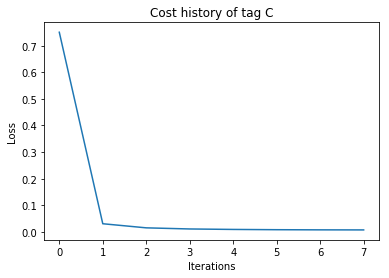

  (took 50.5868 seconds)
Training 0
iter: 0 cost: 0.9676618209600489
iter: 32 cost: 0.04835811753732206
iter: 64 cost: 0.022428314938109463
iter: 96 cost: 0.016447816892685905
iter: 128 cost: 0.013767757258211048
iter: 160 cost: 0.012215562251715054
iter: 192 cost: 0.01139847425223597
iter: 224 cost: 0.010882359445188696


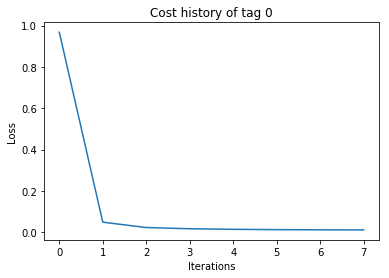

  (took 47.1522 seconds)
Training D
iter: 0 cost: 0.6181055035406252
iter: 32 cost: 0.04306493091375602
iter: 64 cost: 0.02489063161380782
iter: 96 cost: 0.017545715086042954
iter: 128 cost: 0.01634869995399964
iter: 160 cost: 0.023276680290481966
iter: 192 cost: 0.013838551437538767
iter: 224 cost: 0.016334275800329933


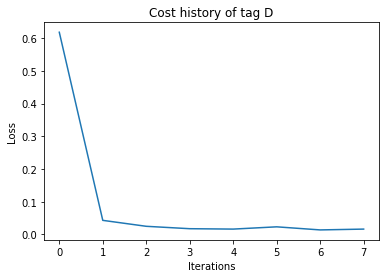

  (took 45.9578 seconds)
Training E
iter: 0 cost: 0.8324399812222384
iter: 32 cost: 0.030776643029673072
iter: 64 cost: 0.014812807107803846
iter: 96 cost: 0.010148583976291687
iter: 128 cost: 0.008277400383450088
iter: 160 cost: 0.007155896267257476
iter: 192 cost: 0.006627084333617341
iter: 224 cost: 0.006295158623343012


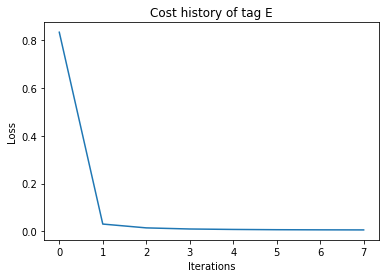

  (took 48.0821 seconds)
Training I
iter: 0 cost: 0.7876656864119461
iter: 32 cost: 0.09001424577690068
iter: 64 cost: 0.04625754497022046
iter: 96 cost: 0.035593212214017865
iter: 128 cost: 0.030032855042086238
iter: 160 cost: 0.027186646202760192
iter: 192 cost: 0.025784558823719522
iter: 224 cost: 0.043174991372288064


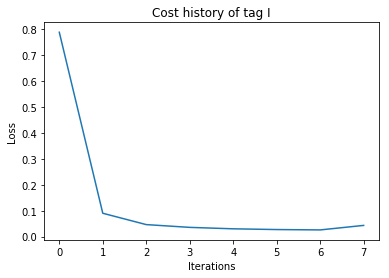

  (took 47.4804 seconds)
Training J
iter: 0 cost: 0.629834648256668
iter: 32 cost: 0.16911707325960867
iter: 64 cost: 0.1123589464446644
iter: 96 cost: 0.09463497450043734
iter: 128 cost: 0.08394545088323048
iter: 160 cost: 0.07606746011370163
iter: 192 cost: 0.07178944549187306
iter: 224 cost: 0.07007062127556499


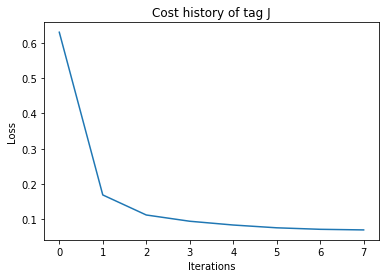

  (took 48.2356 seconds)
Training N
iter: 0 cost: 0.6849984743091958
iter: 32 cost: 0.2868909806941989
iter: 64 cost: 0.18369908312210642
iter: 96 cost: 0.16202554699456148
iter: 128 cost: 0.15948042410482638
iter: 160 cost: 0.15934884363607135
iter: 192 cost: 0.15986475807800618
iter: 224 cost: 0.41976377102622153


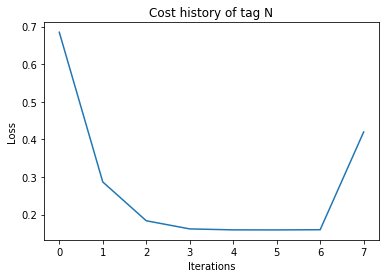

  (took 47.6845 seconds)
Training P
iter: 0 cost: 0.6878035575792153
iter: 32 cost: 0.028978851279073653
iter: 64 cost: 0.01599584329402086
iter: 96 cost: 0.01063878641380832
iter: 128 cost: 0.008717125337547614
iter: 160 cost: 0.007811802836539328
iter: 192 cost: 0.007321160071341591
iter: 224 cost: 0.006978353872739944


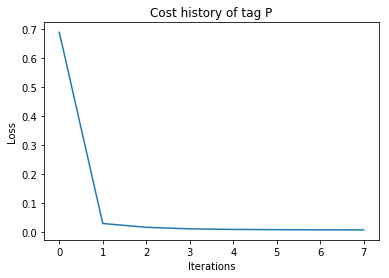

  (took 51.4559 seconds)
Training S
iter: 0 cost: 0.6788376250340853
iter: 32 cost: 0.030125523315805685
iter: 64 cost: 0.013995690052438241
iter: 96 cost: 0.009317862811488739
iter: 128 cost: 0.007675582275883722
iter: 160 cost: 0.006764954618188577
iter: 192 cost: 0.00624997974821951
iter: 224 cost: 0.006008714104362661


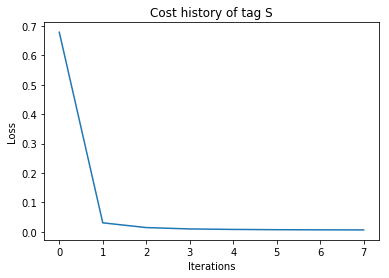

  (took 52.6597 seconds)
Training M
iter: 0 cost: 0.8030301947888494
iter: 32 cost: 0.05246089495027303
iter: 64 cost: 0.02382867327774615
iter: 96 cost: 0.0170917246614928
iter: 128 cost: 0.014204307693396702
iter: 160 cost: 0.012339780652272
iter: 192 cost: 0.011240434885524793
iter: 224 cost: 0.010582808878546488


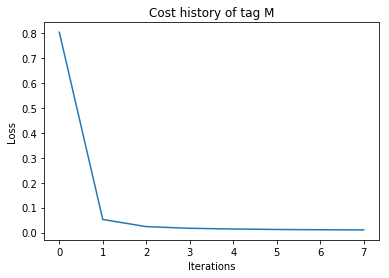

  (took 50.6443 seconds)
Training R
iter: 0 cost: 0.6192549296569343
iter: 32 cost: 0.09377560581126353
iter: 64 cost: 0.04962620849040456
iter: 96 cost: 0.03833968737865286
iter: 128 cost: 0.0326250831358546
iter: 160 cost: 0.02973167392930948
iter: 192 cost: 0.027899098694573497
iter: 224 cost: 0.026701909773844575


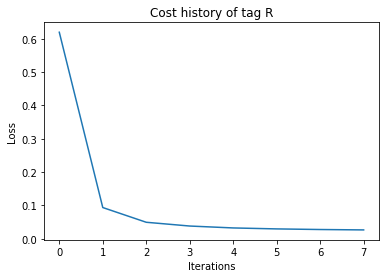

  (took 47.0663 seconds)
Training Z
iter: 0 cost: 0.7001160146662504
iter: 32 cost: 0.03667838460124121
iter: 64 cost: 0.018473843082016803
iter: 96 cost: 0.013252712883791672
iter: 128 cost: 0.010954618342537569
iter: 160 cost: 0.009975292863511044
iter: 192 cost: 0.009340129971462127
iter: 224 cost: 0.009080553051700893


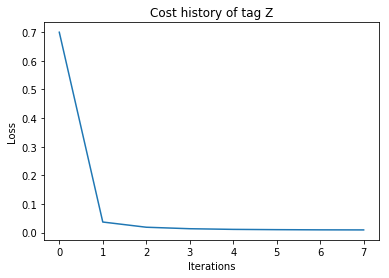

  (took 46.2447 seconds)
Training T
iter: 0 cost: 0.6467012948866948
iter: 32 cost: 0.04056024765089567
iter: 64 cost: 0.018020304064019266
iter: 96 cost: 0.012594419975313974
iter: 128 cost: 0.019968613395407543
iter: 160 cost: 0.007889564562162577
iter: 192 cost: 0.007524043707674483
iter: 224 cost: 0.015501324881559912


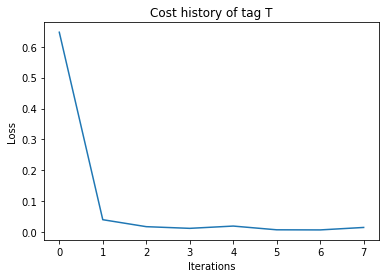

  (took 50.9463 seconds)
Training V
iter: 0 cost: 0.6895433213812665
iter: 32 cost: 0.2530180550114291
iter: 64 cost: 0.16175425237948188
iter: 96 cost: 0.12519300191369495
iter: 128 cost: 0.11920288704372782
iter: 160 cost: 0.11897991234695235
iter: 192 cost: 0.11896450408711473
iter: 224 cost: 0.11896120374215396


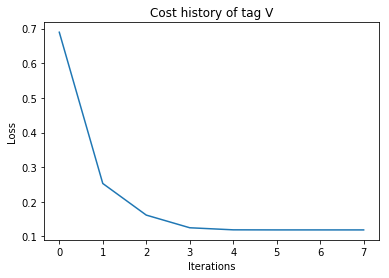

  (took 47.0724 seconds)
Training A
iter: 0 cost: 0.6454031018018536
iter: 32 cost: 0.032598664155665404
iter: 64 cost: 0.013738761769262456
iter: 96 cost: 0.009873686217852298
iter: 128 cost: 0.008532162947354607
iter: 160 cost: 0.007840057717435987
iter: 192 cost: 0.007405916286921707
iter: 224 cost: 0.007153188953135184


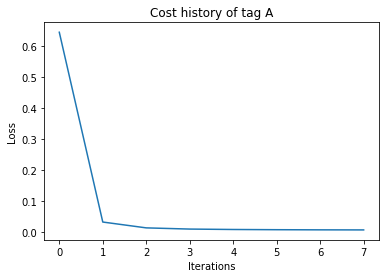

  (took 45.9213 seconds)
Training .
iter: 0 cost: 0.7889301685262524
iter: 32 cost: 0.033797798801218075
iter: 64 cost: 0.015991765622209057
iter: 96 cost: 0.010731137296651717
iter: 128 cost: 0.008899140596533565
iter: 160 cost: 0.00783817324316111
iter: 192 cost: 0.0073793956998210895
iter: 224 cost: 0.00714320075073367


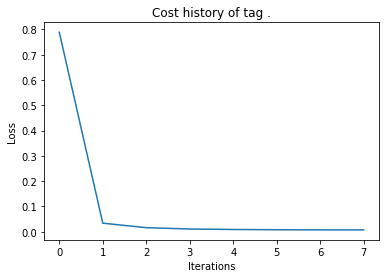

  (took 48.5462 seconds)
CPU times: user 33min 19s, sys: 1min 4s, total: 34min 23s
Wall time: 12min 57s


In [11]:
%%time
# Code to train a model for each reduced POS tag...
rpos_model = {}
for tag in rpos_desc:
    print('Training {}'.format(tag))
    rpos_model[tag] = train_tag_model(tag)

In [12]:
# You will want to train the models above, then fill in the below function to estimate POS tags...
def token_pos(sentence):
    """Given a sentence, as a list of tokens, this should return part of
    speech tags, as a list of strings (the codes in the rpos_desc dictionary).
    Basically calls the models for each tag and selects the tag with the
    highest probability."""
    
    # **************************************************************** some of the above marks
    
    sentence_vec = np.array(glove.decodes(sentence))
    
    # Make array of words in 16xN
    word_probs = np.zeros([len(rpos_model), len(sentence_vec)])
    
    i = 0
    
    # For each tag
    for tag in rpos_model:
        
        # Get weights and random noise from dict
        w = rpos_model[tag][0]
        rand_noise = rpos_model[tag][1]
        
        # Make extended X
        x = np.c_[np.array([1]*len(sentence_vec)), sentence_vec, numpy.sin(sentence_vec.dot(rand_noise))]
            
        # Get prediction probabilities for the entire sentence and add it to word probabilitis array
        word_probs[i] = sig(np.dot(x, w))

        # Increment
        i += 1
            
    # Now pick best prediction values's indices columnwise, ie the best tag's index for each word
    best_tag_indices = np.argmax(word_probs, axis=0)
    
    sentence_tags = []
    # Convert indices to tags, and return them
    for tag_indice in best_tag_indices:
        sentence_tags.append(num_to_rpos[tag_indice])
    
    return sentence_tags


# Code to test the performance of your POS tagger...
correct = 0
tested = 0
pershown = 0
stop_percent = 100 # If you want faster feedback you can reduce this

start = time.time()
for i in range(split, len(gmb)):
    percent = int(100 * (i - split) / (len(gmb) - split))
    if percent>pershown:
        pershown = percent
        print('\r{: 3d}%'.format(percent), end='')
    
    if percent>=stop_percent:
        break
    
    guess = token_pos(gmb[i])
    truth = gmb.pos(i)
    
    for g,t in zip(guess, truth):
        if g==pos_to_rpos[t]:
            correct += 1
        tested += 1
end = time.time()

print()
print('Percentage correct = {:.1f}%'.format(100 * correct / tested))
print('  (took {:g} seconds)'.format(end - start))


 99%
Percentage correct = 92.5%
  (took 271.297 seconds)


# 2. Part of speech tagging - sentence level

While the previous step works very well you need POS tags to be super accurate, as everything else depends on them. You will now introduce context. This is done by calculating transition probabilities between tags and solving a Markov random chain using the forward-backwards algorithm (or just forward if you keep links; it's dynamic programming) to find the maximum a posteriori (MAP) POS tag assignment for the entire sentence. The adjacency matrix should contain $\log P(\textrm{second pos tag} | \textrm{first pos tag})$.

Advice:
* Work in log space, to avoid underflow. Remember to `clip` the model probabilities to avoid `log(0)`.
* Include a prior for the adjacency probabilities. Some combinations have a probability of zero, which will otherwise end badly when you take the log.
* You need to use the probabilities from the logistic random kitchen sinks models. Remember to normalise them so they sum to 1 before taking the `log`.
* The performance boost from this is relatively slight: Only 1.5% for the model answer. But going from 90% to 92% remains a substantial boost (it gets harder the closer you get to 100%! With tweaks, primarily training for longer with more data and random features, this approach (Q1 and Q2) can hit 99%).

**(8 marks)**
* 2 for adjacency probabilities
* 6 marks for algorithm

In [13]:
def make_adjacency_matrix():
    '''Make transition/adjacency matrix'''

    # Keep in mind this doesn't use the whole dataset, but only the training bit ! (ie [:split])
    transitions = np.zeros(len(labels), dtype=int)

    # Convert from str pos tag to num, and add to array
    for i in range(len(labels)):
        transitions[i] = rpos_to_num[pos_to_rpos[labels[i]]]

    # Make empty matrix of 16x16 
    # By doing np.ones, we're essentially using a prior of one
    trans_matrix = np.ones([len(rpos_to_num),len(rpos_to_num)])

    # Zip together the same list of tag indices with 1 distance apart, and increment the counts
    # Remember i,j here are values of transitions, not indices
    for (i,j) in zip(transitions, transitions[1:]):
        trans_matrix[i,j] += 1

    # Normalise counts to probabilities, and take their log
    for row in trans_matrix:
        s = np.sum(row)
        if s > 0:
            row[:] = [np.log(f/s) for f in row]
            
    return trans_matrix

In [14]:
def make_emission_matrix(sentence):
    '''Make emission matrix'''

    sentence_vec = np.array(glove.decodes(sentence))
    
    # Make array of words in 16xN
    emission_matrix = np.zeros([len(rpos_model), len(sentence_vec)])
    
    i = 0
    
    # For each tag
    for tag in rpos_model:
        
        # Get weights and random noise from dict
        w = rpos_model[tag][0]
        rand_noise = rpos_model[tag][1]
        
        # Make extended X
        x = np.c_[np.array([1]*len(sentence_vec)), sentence_vec, numpy.sin(sentence_vec.dot(rand_noise))]
            
        # Get prediction probabilities for the entire sentence and add it to word probabilitis array
        emission_matrix[i] = sig(np.dot(x, w))

        # Increment
        i += 1
        
    return emission_matrix


In [15]:
def make_count_and_probs():

    # Initialise all counts and probabilities to 0
    rpos_count = {tag:0 for tag in rpos_to_num}
    rpos_probs = {tag:0 for tag in rpos_to_num}

    # Get counts
    for label in labels:
        rpos_count[pos_to_rpos[label]] += 1

    # Get probabilities
    for tag in rpos_count:
        rpos_probs[tag] = rpos_count[tag] / len(labels)
        
    return rpos_count, rpos_probs

In [16]:
def viterbi(sentence, rpos_probs, trans_matrix, emission_matrix):

    '''
    Viterbi algorithm (based on Wikipedia pseudocode): 
    https://en.wikipedia.org/wiki/Viterbi_algorithm#Pseudocode
    '''
    
    k = len(rpos_probs)
    t = len(sentence)

    T1 = np.zeros([k,t])
    T2 = np.zeros([k,t])

    # For each state/tag
    for j in range(len(trans_matrix)):
        T1[j,0] = rpos_probs[num_to_rpos[j]] * emission_matrix[j,0]
        T2[j,0] = 0

    # For each state/tag in each word
    for i in range(1, len(sentence)): 
        for j in range(len(rpos_probs)):
            T1[j,i] = np.max(T1[:,i-1] * trans_matrix[-1,j] * emission_matrix[j,i])
            T2[j,i] = np.argmax(T1[:,i-1] * trans_matrix[-1,j])

    # Storage lists
    zs = np.zeros([len(sentence)])
    xs = []
    
    z_t = np.argmax(T1[:,-1])
    zs[-1] = z_t
    
    # Get the actual corresponding actual tag, and append
    x_t = num_to_rpos[z_t]
    xs.append(x_t)
    
    # Loop in reverse
    for i in reversed(range(1, len(sentence))):
        z_i_minus_1 = int(T2[int(zs[i]), i])
        zs[i-1] = z_i_minus_1
        
        x_i_minus_1 = num_to_rpos[z_i_minus_1]
        xs.append(x_i_minus_1)
        
    return xs

In [17]:
# Make adjacency matrix
trans_matrix = make_adjacency_matrix()

# Make counts and probabilities
rpos_count, rpos_probs = make_count_and_probs()

# **************************************************************** 8 marks

def sentence_pos(sentence):
    """Given a sentence, as a list of tokens, this should return part of
    speech tags, as a list of strings (the codes in the rpos_desc dictionary).
    A more advanced version of token_pos that uses neighbours as well."""
    
    # This code runs but gives a very poor score, as there seems to be some
    # really small bug towards the end of my viterbi, which is almost fully working !!
    # I really tried hard to find it, since I went through the pain of implementing 
    # the entire algorithm, but hopefully some marks can nonetheless be allocated. 
    
    # Make emission matrix
    emission_matrix = make_emission_matrix(sentence)
    
    # Call vertebi algorithm
    sentence_tags = viterbi(sentence, rpos_probs, trans_matrix, emission_matrix)
    
    # **************************************************************** some of the above marks
    
    return sentence_tags


In [18]:
# Code to test the performance of your improved POS tagger...
correct = 0
tested = 0
pershown = 0
stop_percent = 100 # If you want faster feedback you can reduce this

start = time.time()
for i in range(split, len(gmb)):
    percent = int(100 * (i - split) / (len(gmb) - split))
    if percent>pershown:
        pershown = percent
        print('\r{: 3d}%'.format(percent), end='')
    
    if percent>=stop_percent:
        break
    
    guess = sentence_pos(gmb[i])
    truth = gmb.pos(i)
    
    for g,t in zip(guess, truth):
        if g==pos_to_rpos[t]:
            correct += 1
        tested += 1
end = time.time()

print()
print('Percentage correct = {:.1f}%'.format(100 * correct / tested))
print('  (took {:g} seconds)'.format(end - start))


 99%
Percentage correct = 19.3%
  (took 570.062 seconds)


# 3. Named entity recognition

The next step is to identify names, that is the entities that "facts" may apply to. While training a further classifier does work (same as above, inc. dynamic programming) there would be little point in repeating the exercise. Instead, a simple rule based approach using *regular expressions* is going to be used.

You will probably want to look at the Python 3 documentation:
https://docs.python.org/3/library/re.html
There is also the how to, a tutorial:
https://docs.python.org/3/howto/regex.html


Given part of speech tagging a name can be defined as:
* An optional *determiner*, e.g. *the* (1 or none)
* An arbitrary number of *adjectives* (could be none)
* A single *noun*

Convert this into a regular expression and finish the function `sentence_ner()` below.

Advice:
* `''.join(pos)` prepares the list of part of speech tags for applying a regular expression.
* Check out the `re.finditer` function as it makes it very easy!
* Fun fact: The above ML approach gets 95% accuracy on this task, 97% if you include a feature indicating if the word is uppercased, when this rule gets only 63% accuracy. However, the GMB data set is mostly news headlines, which doesn't translate well to other kinds of text. They also fail for different reasons: ML tries to balance the objectives, while this rule tends to think more things are names than really are. That works better for information extraction (sometimes the accuracy of individual parts can be a very poor indicator of how well a system as a whole will work!).

**(2 marks)**

In [19]:
def sentence_ner(sentence, pos):
    """Given a sentence as a list of tokens and it's part of speech tags
    this returns a list of the same length with True wherever it thinks
    there is a name."""
    
    # Decode
    sentence_vec = glove.decodes(sentence)
    
    # Make into one string
    string = ''.join(pos)
    pattern = 'D?J*N'
    
    # List
    ret = [False] * len(sentence)
    
    # Run pattern matching regex on the string
    for match in re.finditer(pattern, string):
        start = match.start()
        end = match.end()
        
        # Change relevant values
        for i in range(start, end):
            ret[i] = True
    
    # **************************************************************** 2 marks
    
    return ret


In [20]:
# Code to test the performance of the NER tagger...
correct = 0
tested = 0
pershown = 0
stop_percent = 100 # If you want faster feedback you can reduce this

start = time.time()
for i in range(split, len(gmb)):
    percent = int(100 * (i - split) / (len(gmb) - split))
    if percent>pershown:
        pershown = percent
        print('\r{: 3d}%'.format(percent), end='')
    
    if percent>=stop_percent:
        break
    
    guess = sentence_ner(gmb[i], [pos_to_rpos[p] for p in gmb.pos(i)])
    truth = [ner!='O' for ner in gmb.ner(i)]
    
    for g,t in zip(guess, truth):
        if g==t:
            correct += 1
        tested += 1
end = time.time()

print()
print('Percentage correct = {:.1f}%'.format(100 * correct / tested))
print('  (took {:g} seconds)'.format(end - start))


 99%
Percentage correct = 63.4%
  (took 1.77238 seconds)


# 4. Relation extraction

This is where the paper "*Identifying Relations for Open Information Extraction*" comes in, specifically one of its novel contributions. It extracts relations using this procedure:
1. Find relation text by matching a human-designed pattern to the POS tags
2. Identify the named entities to the left and right of the relation text.
3. Generate the relation tuple (left named entity, relation text, right named entity)

(all previous approaches found names then relations - turns out it works much better the other way around)

Relation text is identified as:
`(Ve (Wo* Pa)?)+`
where
* `Ve = Verb Particle? Adverb?`
* `Wo = Noun | Adjective | Adverb | Pronoun | Determiner`
* `Pa = Preposition or subordinating conjunction | Particle`
* `| =` or, so either of the options
* `? =` optional
* `+ =` at least one, but can be many
* `* =` an arbitrary number of repetitions, including the option for none.

You will need to convert the above rules into a regular expression - this one is harder than the above! You can then run it on a sentence, and for each match identify the named entity to the left and right and create a relation from that.

Advice:
* Most sentences will only generate one relation, but some will generate more.
* Remember that a named entity might be more than one token in length.

**(4 marks)**

In [21]:
def extract(sentence):
    """Given a sentence, as a list of tokens, this returns a list of all relations
    extracted from the sentence. Each relation is a tuple with three entries:
    (named entity one, relation, named entity two)"""
    
    # I'm using token_pos(sentence) instead of sentence_pos(sentence), 
    # as I wasn't able to implement a working version of it, 
    # but still implemented code for this exercise.
    
    # pos = sentence_pos(sentence) 
    pos = token_pos(sentence)
    ner = sentence_ner(sentence, pos)
    ret = []
    
    ve = 'VZ?R?'
    wo = 'N|J|R|M|D'
    pa = 'I|Z'
    
    string = ''.join(pos)
    pattern = f'(({ve})(({wo})*({pa}))?)+'
    
    # Run pattern matching regex on the string
    for match in re.finditer(pattern, string):
        
        # Get start and end of match
        start = match.start()
        end = match.end()
        relationship = []
        
        # Check
        if start!=0:
            relationship += [sentence[start-1]]
        
        relationship += [sentence[i] for i in range(start, end+1)]
        
        if end != len(sentence)-1:
            relationship += [sentence[end+1]]
        
        my_tuple = (relationship)
        ret.append(my_tuple)
    
    # **************************************************************** 4 marks
    
    return ret

In [22]:
# Small test of the above...
tests = ['London is full of pigeons.',
         'In 1781 William Herschel discovered Uranus', # 1
         "Trolls really don't like the sun.",
         'Giant owls would enjoy eatting people.',
         "Dragons collect gold, but they don't make microprocessors."] # 2

# 1. Seems to miss William - misclassified it, at least with the model answer.
# 2. Should extract two facts, first sensible, second absurd.

for sentence in tests:
    print(sentence)
    tokens = ogonek.Tokenise(sentence)
    
    rels = extract(tokens[0])
    for rel in rels:
        print('  ' + ' -- '.join(rel))
    print()
    

London is full of pigeons.
  London -- is -- full -- of -- pigeons -- .

In 1781 William Herschel discovered Uranus
  Herschel -- discovered -- Uranus

Trolls really don't like the sun.
  really -- do -- not -- like -- the -- sun

Giant owls would enjoy eatting people.

Dragons collect gold, but they don't make microprocessors.
  Dragons -- collect -- gold -- ,
  they -- do -- not -- make -- microprocessors -- .



## 20000 relations under the seas

While the above may have tested each step of the system, the below code runs it on the book "*20,000 leagues under the seas*" by Jules Verne (widely considered to be the first science fiction book, and full of fairly dubious claims about what goes on underwater). It's no fun to build a system without running it properly! The above does however miss out several important steps (using ML to filter out bad extractions, simplifying relation text, deleting relations that don't appear often enough in a large corpus etc.) so the below is going to have more mistakes than successes. It's actually kinda funny how terrible it is, but it would unfortunately take too much time to polish.

It's also an excuse for a terrible play on words. Sorry.

In [23]:
for index in range(len(under_the_seas)):
    sentence = under_the_seas[index]
    rels = extract(sentence)
    
    if len(rels)>0:
        print(' '.join(sentence))
        for rel in rels:
            print('  ' + ' -- '.join(rel))
        print()



Twenty Thousand Leagues Under the Seas An Underwater Tour of the World JULES VERNE Translated from the Original French by F. P. Walter Copyright ( C ) 1999 , Frederick Paul Walter .
  Thousand -- Leagues -- Under -- the -- Seas
  VERNE -- Translated -- from -- the -- Original

A complete , unabridged translation of Vingt mille lieues sous les mers by Jules Verne , based on the original French texts published in Paris by J. Hetzel et Cie. over the period 1869 - 71. The paintings of Illinois watercolorist Milo Winter ( 1888 - 1956 ) first appeared in a 1922 juvenile edition published by Rand McNally and Company .
  unabridged -- translation -- of -- Vingt -- mille
  texts -- published -- in -- Paris -- by
  first -- appeared -- in -- a -- 1922
  edition -- published -- by -- Rand -- McNally

VERNE'S TITLE The French title of this novel is Vingt mille lieues sous les mers .
  this -- novel -- is -- Vingt -- mille

This is accurately translated as Twenty Thousand Leagues Under the SEAS - r

Around the World in Eighty Days ( 1872 ) and Michael Strogoff ( 1876 ) are closer to " travelogs" - adventure yarns in far - away places .
  ) -- are -- closer -- to -- "

These observations partly apply here .
  observations -- partly -- apply -- here -- .

The subtitle of the present book is An Underwater Tour of the World , so in good travelog style , the Nautilu 's exploits supply an episodic story line .
  the -- present -- book -- is
  book -- is -- An -- Underwater -- Tour -- of -- the -- World
  story -- line -- .

Shark attacks , giant squid , cannibals , hurricanes , whale hunts , and other rip - roaring adventures erupt almost at random .
  adventures -- erupt -- almost -- at -- random -- .

Yet this loose structure gives the novel an air of documentary realism .
  this -- loose -- structure -- gives -- the -- novel
  the -- novel -- an -- air -- of -- documentary -- realism

What is more , Verne adds backbone to the action by developing three recurring motifs :
  What -- is

Striking an average of observations taken at different times - rejecting those timid estimates that gave the object a length of 200 feet , and ignoring those exaggerated views that saw it as a mile wide and three long - you could still assert that this phenomenal creature greatly exceeded the dimensions of anything then known to ichthyologists , if it existed at all .
  Striking -- an -- average -- of -- observations -- taken
  observations -- taken -- at -- different -- times
  - -- rejecting -- those -- timid
  timid -- estimates -- that -- gave -- the -- object -- a -- length -- of -- 200 -- feet
  and -- ignoring -- those -- exaggerated
  those -- exaggerated -- views -- that -- saw -- it
  creature -- greatly -- exceeded -- the -- dimensions -- of -- anything -- then
  then -- known -- to -- ichthyologists

Now then , it did exist , this was an undeniable fact ; and since the human mind dotes on objects of wonder , you can understand the worldwide excitement caused by this unearth

, at discussions in The Indian Archipelago , in Cosmos published by Father Moigno , in Peterman 's Mittheilungen , * and at scientific chronicles in the great French and foreign newspapers .
  Cosmos -- published -- by -- Father -- Moigno -- ,

When the monste 's detractors cited a saying by the botanist Linnaeus that " nature does not make leaps , " witty writers in the popular periodicals parodied it , maintaining in essence that " nature does not make lunatics , " and ordering their contemporaries never to give the lie to nature by believing in krakens , sea serpents , " Moby Dicks , " and other all - out efforts from drunken seamen .
  detractors -- cited -- a -- saying
  a -- saying -- by -- the -- botanist
  nature -- does -- not -- make -- leaps -- ,
  , -- maintaining -- in -- essence -- that
  nature -- does -- not -- make -- lunatics -- ,
  and -- ordering -- their -- contemporaries
  contemporaries -- never -- to -- give
  by -- believing -- in -- krakens -- ,

Finally , in 

This encounter seemed so minor that nobody on board would have been disturbed by it , had it not been for the shouts of crewmen in the hold , who climbed on deck yelling :
  encounter -- seemed -- so -- minor -- that -- nobody -- on
  would -- have -- been -- disturbed -- by -- it -- ,
  , -- had -- it -- not
  not -- been -- for -- the -- shouts
  the -- hold -- , -- who
  who -- climbed -- on -- deck -- yelling

" We are sinking !
  We -- are -- sinking -- !

We are sinking !
  We -- are -- sinking -- !

" At first the passengers were quite frightened , but Captain Anderson hastened to reassure them .
  passengers -- were -- quite -- frightened -- , -- but
  but -- Captain -- Anderson -- hastened
  to -- reassure -- them -- .

In fact , there could be no immediate danger .
  could -- be -- no -- immediate

Divided into seven compartments by watertight bulkheads , the Scotia could brave any leak with impunity .
  Divided -- into -- seven -- compartments

Captain Anderson immediately m

That a private individual had such a mechanism at his disposal was less than probable .
  individual -- had -- such -- a
  a -- mechanism -- at -- his -- disposal
  disposal -- was -- less -- than -- probable -- .

Where and when had he built it , and how could he have built it in secret ?
  when -- had -- he -- built
  he -- built -- it -- ,
  he -- have -- built -- it -- in -- secret -- ?

Only some government could own such an engine of destruction , and in these disaster - filled times , when men tax their ingenuity to build increasingly powerful aggressive weapons , it was possible that , unknown to the rest of the world , some nation could have been testing such a fearsome machine .
  to -- build -- increasingly -- powerful -- aggressive
  it -- was -- possible -- that -- , -- unknown
  could -- have -- been -- testing -- such

The Chassepot rifle led to the torpedo , and the torpedo has led to this underwater battering ram , which in turn will lead to the world putting its foot 

The museum at the Faculty of Medicine in Paris owns one of these tusks with a length of 2.25 meters and a width at its base of forty - eight centimeters !
  Paris -- owns -- one -- of

Imagine this weapon to be ten times stronger and the animal ten times more powerful , launch it at a speed of twenty miles per hour , multiply its mass times its velocity , and you get just the collision we need to cause the specified catastrophe .
  Imagine -- this -- weapon
  to -- be -- ten -- times
  , -- launch -- it -- at -- a -- speed
  , -- multiply -- its -- mass
  you -- get -- just -- the -- collision
  we -- need -- to -- cause
  to -- cause -- the -- specified
  the -- specified -- catastrophe -- .

" So , until information becomes more abundant , I plump for a sea unicorn of colossal dimensions , no longer armed with a mere lance but with an actual spur , like ironclad frigates or those warships called ‘rams , ' whose mass and motor power it would possess simultaneously . "
  information --

A pier is a type of wharf expressly set aside for an individual vessel .
  pier -- is -- a -- type -- of -- wharf -- expressly
  expressly -- set -- aside -- for -- an -- individual

Pierre Aronnax Professor at the Paris Museum Fifth Avenue Hotel New York Sir :
  Aronnax -- Professor -- at -- the -- Paris

If you would like to join the expedition on the Abraham Lincoln , the government of the Union will be pleased to regard you as Franc 's representative in this undertaking .
  to -- join -- the -- expedition
  the -- expedition -- on -- the -- Abraham
  will -- be -- pleased -- to

Commander Farragut has a cabin at your disposal .
  Farragut -- has -- a -- cabin -- at -- your -- disposal

CHAPTER 3 As Master Wishes THREE SECONDS before the arrival of J. B. Hobso 's letter , I no more dreamed of chasing the unicorn than of trying for the Northwest Passage .
  CHAPTER -- 3 -- As
  of -- trying -- for -- the -- Northwest
  Northwest -- Passage -- .

Three seconds after reading this lette

" Then we are not returning to Paris ? "
  we -- are -- not -- returning -- to -- Paris

Conseil asked .
  Conseil -- asked -- .

" Yes , we are .
  we -- are -- .

, " I replied evasively , " but after we make a detour . "
  I -- replied -- evasively -- ,
  we -- make -- a -- detour

" Oh , it is nothing really !
  it -- is -- nothing -- really

A route slightly less direct , that is all .
  that -- is -- all -- .

We are leaving on the Abraham Lincoln . "
  We -- are -- leaving -- on -- the -- Abraham

" As master thinks best , " Conseil replied placidly . "
  Conseil -- replied -- placidly -- .

You see , my friend , it is an issue of the monster , the notorious narwhale .
  my -- friend -- , -- it
  it -- is -- an -- issue -- of -- the -- monster

We are going to rid the seas of it !
  We -- are -- going -- to -- rid
  to -- rid -- the -- seas -- of -- it -- !

The author of a two - volume work , in quarto , on The Mysteries of the Great Ocean Depths has no excuse for not setting s

Steam rushed whistling into the gaping valves .
  Steam -- rushed -- whistling -- into -- the -- gaping
  gaping -- valves -- .

Long horizontal pistons groaned and pushed the tie rods of the drive shaft .
  pistons -- groaned -- and -- pushed
  and -- pushed -- the -- tie -- rods -- of -- the -- drive
  the -- drive -- shaft -- .

The blades of the propeller churned the waves with increasing speed , and the Abraham Lincoln moved out majestically amid a spectator - laden escort of some 100 ferries and tenders .
  the -- waves -- with -- increasing -- speed -- ,
  Lincoln -- moved -- out -- majestically -- amid

Tenders are small steamboats that assist the big liners .
  Tenders -- are -- small -- steamboats -- that -- assist -- the -- big

The wharves of Brooklyn , and every part of New York bordering the East River , were crowded with curiosity seekers .
  , -- were -- crowded -- with -- curiosity -- seekers

Departing from 500,000 throats , three cheers burst forth in succession .
  

So the Abraham Lincoln was not lacking in means of destruction .
  Lincoln -- was -- not -- lacking -- in -- means -- of

But it had better still .
  it -- had -- better -- still

It had Ned Land , the King of Harpooners .
  It -- had -- Ned -- Land

Gifted with uncommon manual ability , Ned Land was a Canadian who had no equal in his dangerous trade .
  Land -- was -- a -- Canadian
  who -- had -- no -- equal -- in -- his -- dangerous

Dexterity , coolness , bravery , and cunning were virtues he possessed to a high degree , and it took a truly crafty baleen whale or an exceptionally astute sperm whale to elude the thrusts of his harpoon .
  cunning -- were -- virtues -- he
  he -- possessed -- to -- a
  it -- took -- a -- truly

Ned Land was about forty years old .
  Land -- was -- about -- forty -- years

A man of great height - over six English feet - he was powerfully built , serious in manner , not very sociable , sometimes headstrong , and quite ill - tempered when crossed .
  he

" Wooden ships maybe , " the Canadian replied . "
  ships -- maybe -- , -- "
  Canadian -- replied -- . -- "

But I have never seen the like .
  I -- have -- never -- seen -- the -- like -- .

So till I have proof to the contrary , I will deny that baleen whales , sperm whales , or unicorns can do any such thing . "
  I -- have -- proof -- to
  the -- contrary -- , -- I
  will -- deny -- that -- baleen -- whales
  can -- do -- any -- such

" Listen to me , Ned - " " No , no , professor .
  " -- Listen -- to -- me
  to -- me -- , -- Ned
  , -- professor -- .

I will go along with anything you want except that .
  will -- go -- along -- with -- anything
  you -- want -- except -- that -- .

Some gigantic devilfish maybe . "
  devilfish -- maybe -- . -- "

The devilfish is merely a mollusk , and even this name hints at its semiliquid flesh , because it is Latin meaning soft one .
  devilfish -- is -- merely -- a -- mollusk
  it -- is -- Latin -- meaning
  Latin -- meaning -- soft -- one



That deep in the sea , such animals would need to be just as strong as you say - if they exist . "
  would -- need -- to -- be
  to -- be -- just -- as -- strong -- as
  you -- say -- - -- if

" But if they do not exist , my stubborn harpooner , how do you explain the accident that happened to the Scotia ? "
  they -- do -- not -- exist -- ,
  how -- do -- you -- explain
  you -- explain -- the -- accident -- that -- happened -- to -- the

" It is maybe .
  It -- is -- maybe -- .

, " Ned said , hesitating .
  Ned -- said -- , -- hesitating

" Go on ! "
  " -- Go -- on -- ! -- "

it just could not be true !
  not -- be -- true -- !

" the Canadian replied , unconsciously echoing a famous catchphrase of the scientist Arago .
  Canadian -- replied -- , -- unconsciously

But this reply proved nothing , other than how bullheaded the harpooner could be .
  reply -- proved -- nothing -- ,
  could -- be -- .

That day I pressed him no further .
  I -- pressed -- him -- no
  no -- further -- .

" If maste 's eyes would kindly stop bulging , master will see farther ! "
  's -- eyes -- would -- kindly
  kindly -- stop -- bulging -- ,

The Abraham Lincoln would change course and race after the animal sighted , only to find an ordinary baleen whale or a common sperm whale that soon disappeared amid a chorus of curses !
  would -- change -- course -- and
  to -- find -- an -- ordinary

However , the weather held good .
  weather -- held -- good -- .

Our voyage was proceeding under the most favorable conditions .
  voyage -- was -- proceeding -- under -- the -- most

By then it was the bad season in these southernmost regions , because July in this zone corresponds to our January in Europe ; but the sea remained smooth and easily visible over a vast perimeter .
  it -- was -- the -- bad -- season -- in -- these -- southernmost
  sea -- remained -- smooth -- and

Ned Land still kept up the most tenacious skepticism ; beyond his spells on watch , he pretended that he never even look

His sailors could not hide their discontent , and their work suffered because of it .
  not -- hide -- their -- discontent
  work -- suffered -- because -- of -- it

I am unwilling to say that there was mutiny on board , but after a reasonable period of intransigence , Commander Farragut , like Christopher Columbus before him , asked for a grace period of just three days more .
  I -- am -- unwilling -- to
  to -- say -- that -- there -- was
  there -- was -- mutiny -- on -- board -- ,
  , -- asked -- for -- a -- grace

After this three - day delay , if the monster had not appeared , our helmsman would give three turns of the wheel , and the Abraham Lincoln would chart a course toward European seas .
  monster -- had -- not -- appeared -- , -- our

This promise was given on November 2. It had the immediate effect of reviving the cre 's failing spirits .
  This -- promise -- was -- given -- on -- November -- 2.
  It -- had -- the -- immediate -- effect -- of -- reviving -- the -- cre
  

This was no mere phosphorescent phenomenon , that much was unmistakable .
  This -- was -- no -- mere
  much -- was -- unmistakable -- .

Submerged some fathoms below the surface of the water , the monster gave off that very intense but inexplicable glow that several captains had mentioned in their reports .
  monster -- gave -- off -- that -- very -- intense
  captains -- had -- mentioned -- in -- their -- reports
  their -- reports -- .

This magnificent radiance had to come from some force with a great illuminating capacity .
  radiance -- had -- to -- come
  to -- come -- from -- some -- force

The edge of its light swept over the sea in an immense , highly elongated oval , condensing at the center into a blazing core whose unbearable glow diminished by degrees outward .
  light -- swept -- over -- the -- sea
  an -- immense -- , -- highly
  glow -- diminished -- by -- degrees -- outward
  degrees -- outward -- .

" It is only a cluster of phosphorescent particles ! "
  It -- is --

But tell me , is not that the noise cetaceans make when they spurt water from their blowholes ? "
  But -- tell -- me -- , -- is
  , -- is -- not -- that -- the -- noise
  cetaceans -- make -- when -- they -- spurt -- water -- from -- their -- blowholes

So there can be no mistake .
  can -- be -- no -- mistake

Ther 's definitely a whale lurking in our waters .
  's -- definitely -- a -- whale -- lurking -- in -- our -- waters

With your permission , sir , " the harpooner added , " tomorrow at daybreak we will have words with it . "
  your -- permission -- , -- sir
  harpooner -- added -- , -- "
  will -- have -- words -- with -- it -- .

" If it is in a mood to listen to you , Mr. Land , " I replied in a tone far from convinced . "
  it -- is -- in -- a -- mood
  to -- listen -- to -- you
  I -- replied -- in -- a -- tone
  from -- convinced -- . -- "

Let me get within four harpoon lengths of it , " the Canadian shot back , " and it had better listen ! "
  Let -- me -- get -- within

" No , sir , " Ned Land replied , " because that beast wo not be caught against its will . "
  Land -- replied -- , -- "
  beast -- wo -- not -- be -- caught -- against -- its -- will

" Then what should we do ? "
  we -- do -- ? -- "

As for me , with your permission I will go perch on the bobstays under the bowsprit , and if we can get within a harpoon length , I will harpoon the brute . "
  for -- me -- , -- with
  your -- permission -- I -- will
  will -- go -- perch -- on -- the -- bobstays
  can -- get -- within -- a -- harpoon

" Go to it , Ned , " Commander Farragut replied . "
  " -- Go -- to -- it
  Farragut -- replied -- . -- "

Engineer , " he called , " keep the pressure mounting !
  he -- called -- , -- "
  " -- keep -- the -- pressure
  pressure -- mounting -- !

" Ned Land made his way to his post .
  Land -- made -- his -- way

The furnaces were urged into greater activity ; our propeller did forty - three revolutions per minute , and steam shot from the valves .
  fur

By then I thought our expedition had come to an end , that we would never see this fantastic animal again .
  I -- thought -- our -- expedition
  our -- expedition -- had -- come -- to -- an
  would -- never -- see -- this

I was mistaken .
  I -- was -- mistaken -- .

The narwhale seemed motionless .
  narwhale -- seemed -- motionless -- .

Was it asleep perhaps , weary from its workday , just riding with the waves ?
  Was -- it -- asleep
  just -- riding -- with -- the -- waves
  the -- waves -- ?

This was our chance , and Commander Farragut was determined to take full advantage of it .
  This -- was -- our -- chance
  Farragut -- was -- determined -- to -- take
  to -- take -- full -- advantage -- of -- it -- .

He gave his orders .
  He -- gave -- his -- orders
  his -- orders -- .

The Abraham Lincoln stayed at half steam , advancing cautiously so as not to awaken its adversary .
  Lincoln -- stayed -- at -- half -- steam
  , -- advancing -- cautiously -- so -- as -- not -- to

I

Conseil had coolly reasoned out this hypothesis and laid his plans accordingly .
  Conseil -- had -- coolly -- reasoned
  and -- laid -- his -- plans
  his -- plans -- accordingly -- .

An amazing character , this boy ; in midocean , this stoic lad seemed right at home !
  lad -- seemed -- right -- at -- home -- !

So , having concluded that our sole chance for salvation lay in being picked up by the Abraham Lincol 's longboats , we had to take steps to wait for them as long as possible .
  , -- having -- concluded -- that -- our -- sole
  salvation -- lay -- in -- being -- picked -- up -- by -- the -- Abraham
  we -- had -- to -- take
  to -- take -- steps -- to -- wait
  to -- wait -- for -- them -- as

Consequently , I decided to divide our energies so we would not both be worn out at the same time , and this was the arrangement :
  I -- decided -- to -- divide
  to -- divide -- our -- energies
  both -- be -- worn -- out -- at -- the
  this -- was -- the -- arrangement

while one o

For certain , I came to quickly , because someone was massaging me so vigorously it left furrows in my flesh .
  I -- came -- to -- quickly
  because -- someone -- was -- massaging -- me
  massaging -- me -- so -- vigorously -- it
  it -- left -- furrows -- in -- my -- flesh

I half opened my eyes .
  half -- opened -- my -- eyes
  my -- eyes -- .

" Did master ring for me ? "
  " -- Did -- master -- ring -- for -- me -- ? -- "

Conseil replied .
  Conseil -- replied -- .

Just then , in the last light of a moon settling on the horizon , I spotted a face that was not Consei 's but which I recognized at once .
  moon -- settling -- on -- the -- horizon
  I -- spotted -- a -- face -- that -- was -- not -- Consei -- 's
  I -- recognized -- at -- once -- .

I exclaimed .
  I -- exclaimed -- .

the Canadian replied .
  Canadian -- replied -- .

" You were thrown overboard after the frigat 's collision ? "
  You -- were -- thrown -- overboard -- after -- the -- frigat

" Yes , professor , bu

But aside from this occurring , I did not doubt the possibility of our making contact with them .
  But -- aside -- from -- this -- occurring
  this -- occurring -- , -- I
  I -- did -- not -- doubt -- the
  the -- possibility -- of -- our -- making
  our -- making -- contact -- with -- them -- .

In fact , if they did not produce their own air , they inevitably had to make periodic visits to the surface of the ocean to replenish their oxygen supply .
  they -- did -- not -- produce -- their -- own
  inevitably -- had -- to -- make
  to -- make -- periodic -- visits -- to
  to -- replenish -- their -- oxygen

Hence the need for some opening that put the boa 's interior in contact with the atmosphere .
  Hence -- the -- need
  the -- need -- for -- some -- opening
  some -- opening -- that -- put -- the -- boa

As for any hope of being rescued by Commander Farragut , that had to be renounced completely .
  of -- being -- rescued -- by -- Commander -- Farragut
  that -- had -- to -- be
 

A Bowie knife is a wide - bladed dagger that Americans are forever carrying around .
  Bowie -- knife -- is -- a -- wide
  Americans -- are -- forever -- carrying -- around -- .

" Do not be so irritable , Ned , " I then told the harpooner , " and do not ruin things for us with pointless violence .
  " -- Do -- not -- be -- so -- irritable -- ,
  then -- told -- the -- harpooner
  and -- do -- not -- ruin -- things -- for -- us -- with

Who knows whether they might be listening to us ?
  might -- be -- listening -- to

Instead , let us try to find out where we are !
  Instead -- , -- let
  , -- let -- us -- try
  us -- try -- to -- find
  to -- find -- out -- where -- we
  we -- are -- !

" I started moving , groping my way .
  I -- started -- moving -- , -- groping

After five steps I encountered an iron wall made of riveted boilerplate .
  five -- steps -- I -- encountered
  I -- encountered -- an -- iron
  wall -- made -- of -- riveted -- boilerplate

Then , turning around , I bumpe

Then , turning to his companion , he conversed with him in a language I did not recognize .
  , -- turning -- to -- his
  I -- did -- not -- recognize -- .

It was a sonorous , harmonious , flexible dialect whose vowels seemed to undergo a highly varied accentuation .
  It -- was -- a -- sonorous
  vowels -- seemed -- to -- undergo
  to -- undergo -- a -- highly
  highly -- varied -- accentuation -- .

The other replied with a shake of the head and added two or three utterly incomprehensible words .
  other -- replied -- with -- a -- shake
  and -- added -- two -- or

Then he seemed to question me directly with a long stare .
  he -- seemed -- to -- question
  question -- me -- directly -- with -- a -- long

I replied in clear French that I was not familiar with his language ; but he did not seem to understand me , and the situation grew rather baffling .
  I -- replied -- in -- clear -- French
  I -- was -- not -- familiar -- with -- his -- language
  he -- did -- not -- seem -- to --

" My gallant Ned , as yet that country is not clearly marked on maps of the world , but I admit that the nationality of these two strangers is hard to make out !
  country -- is -- not -- clearly -- marked -- on -- maps -- of
  I -- admit -- that -- the -- nationality
  strangers -- is -- hard -- to
  to -- make -- out -- !

Neither English , French , nor German , that is all we can say .
  Neither -- English -- ,
  that -- is -- all -- we
  can -- say -- .

But I am tempted to think that the commander and his chief officer were born in the low latitudes .
  I -- am -- tempted -- to
  officer -- were -- born -- in -- the -- low

There must be southern blood in them .
  must -- be -- southern -- blood -- in -- them -- .

But as to whether they're Spaniards , Turks , Arabs , or East Indians , their physical characteristics do not give me enough to go on .
  characteristics -- do -- not -- give -- me
  give -- me -- enough -- to
  to -- go -- on -- .

And as for their speech , it is utter

CHAPTER 9 The Tantrums of Ned Land I HAVE NO IDEA how long this slumber lasted ; but it must have been a good while , since we were completely over our exhaustion .
  CHAPTER -- 9 -- The
  I -- HAVE -- NO -- IDEA
  must -- have -- been -- a -- good -- while -- , -- since
  we -- were -- completely -- over -- our -- exhaustion

I was the first one to wake up .
  I -- was -- the -- first
  to -- wake -- up -- .

My companions were not yet stirring and still lay in their corners like inanimate objects .
  companions -- were -- not -- yet -- stirring -- and -- still
  still -- lay -- in -- their -- corners
  their -- corners -- like -- inanimate -- objects

I had barely gotten up from my passably hard mattress when I felt my mind clear , my brain go on the alert .
  I -- had -- barely -- gotten -- up -- from -- my
  I -- felt -- my -- mind
  brain -- go -- on -- the -- alert

So I began a careful reexamination of our cell .
  I -- began -- a -- careful -- reexamination -- of -- our -- cell

" All right , Ned , let us wait and see ! "
  , -- let -- us -- wait
  us -- wait -- and -- see

I replied .
  I -- replied -- .

" It is clear that these strangers do not intend to let us die of hunger , otherwise last evenin 's dinner would not make any sense . "
  It -- is -- clear -- that -- these -- strangers
  strangers -- do -- not -- intend -- to -- let
  to -- let -- us -- die -- of -- hunger -- ,
  , -- otherwise -- last -- evenin
  not -- make -- any -- sense

Ned shot back .
  Ned -- shot -- back -- .

" I object , " I replied . "
  I -- replied -- . -- "

We have not fallen into the hands of cannibals . "
  We -- have -- not -- fallen -- into -- the -- hands

" Just because they do not make a habit of it , " the Canadian replied in all seriousness , " does not mean they do not indulge from time to time .
  they -- do -- not -- make -- a -- habit
  Canadian -- replied -- in -- all -- seriousness
  " -- does -- not -- mean -- they -- do
  they -- do -- not -- indulge -- from

" But we fix things by kicking out all the jailers , guards , and wardens , " Ned Land added . "
  we -- fix -- things -- by -- kicking -- out
  Land -- added -- . -- "

What is this , Ned ?
  What -- is -- this -- ,

" I asked . "
  I -- asked -- . -- "

You'd seriously consider taking over this craft ? "
  seriously -- consider -- taking -- over -- this -- craft

" Very seriously , " the Canadian replied . "
  Canadian -- replied -- . -- "

It is impossible . "
  It -- is -- impossible -- .

" And why is that , sir ?
  why -- is -- that -- , -- sir

Some promising opportunity might come up , and I do not see what could stop us from taking advantage of it .
  promising -- opportunity -- might -- come
  might -- come -- up -- , -- and
  I -- do -- not -- see -- what
  could -- stop -- us -- from -- taking -- advantage -- of -- it -- .

If there are only about twenty men on board this machine , I do not think they can stave off two Frenchmen and a Canadian !
  there -- are -- only -- ab

Conseil was already trying to loosen the harpoone 's hands from his half - suffocated victim , and I had gone to join in the rescue , when I was abruptly nailed to the spot by these words pronounced in French :
  Conseil -- was -- already -- trying -- to -- loosen
  to -- loosen -- the -- harpoone
  - -- suffocated -- victim -- ,
  I -- had -- gone -- to -- join
  to -- join -- in -- the -- rescue
  I -- was -- abruptly -- nailed -- to

" Calm down , Mr. Land !
  " -- Calm -- down -- , -- Mr.

And you , professor , kindly listen to me !
  , -- professor -- , -- kindly
  kindly -- listen -- to -- me
  to -- me -- !

" CHAPTER 10 The Man of the Waters IT WAS THE shi 's commander who had just spoken .
  " -- CHAPTER -- 10 -- The
  IT -- WAS -- THE -- shi
  who -- had -- just -- spoken -- .

At these words Ned Land stood up quickly .
  Land -- stood -- up -- quickly -- .

Nearly strangled , the steward staggered out at a signal from his superior ; but such was the commande 's authority abo

Would not that be my right ? "
  that -- be -- my -- right

" Perhaps it would be the right of a savage , " I replied . "
  would -- be -- the -- right -- of -- a -- savage
  I -- replied -- . -- "

" Professor , " the commander replied swiftly , " I am not what you term a civilized man !
  " -- Professor -- , -- "
  commander -- replied -- swiftly -- , -- "
  I -- am -- not -- what -- you

I have severed all ties with society , for reasons that I alone have the right to appreciate .
  I -- have -- severed -- all -- ties -- with -- society -- ,
  alone -- have -- the -- right

Therefore I obey none of its regulations , and I insist that you never invoke them in front of me !
  Therefore -- I -- obey
  I -- obey -- none -- of -- its -- regulations
  I -- insist -- that -- you -- never
  you -- never -- invoke -- them -- in -- front -- of
  of -- me -- !

" This was plain speaking .
  This -- was -- plain -- speaking
  plain -- speaking -- .

A flash of anger and scorn lit up the strange

By keeping you on board , it is not you whom I care for , it is me !
  By -- keeping -- you -- on -- board -- ,
  it -- is -- not -- you -- whom -- I -- care -- for -- , -- it
  it -- is -- me -- !

" These words indicated that the commander pursued a policy impervious to arguments . "
  words -- indicated -- that -- the -- commander
  commander -- pursued -- a -- policy

Then , sir , " I went on , " you give us , quite simply , a choice between life and death ? "
  I -- went -- on -- , -- "
  quite -- simply -- , -- a

" Quite simply . "
  Quite -- simply -- . -- "

" My friends , " I said , " to a question couched in these terms , our answer can be taken for granted .
  I -- said -- , -- "
  can -- be -- taken -- for -- granted -- .

But no solemn promises bind us to the commander of this vessel . "
  solemn -- promises -- bind -- us

" None , sir , " the stranger replied .
  " -- None -- , -- sir
  stranger -- replied -- .

Then , in a gentler voice , he went on :
  gentler -- voice

Our breakfast consisted of several dishes whose contents were all supplied by the sea , and some foods whose nature and derivation were unknown to me .
  several -- dishes -- whose -- contents
  whose -- contents -- were -- all -- supplied
  all -- supplied -- by -- the -- sea
  derivation -- were -- unknown -- to
  to -- me -- .

They were good , I admit , but with a peculiar flavor to which I would soon grow accustomed .
  They -- were -- good -- ,
  I -- admit -- , -- but
  soon -- grow -- accustomed -- .

These various food items seemed to be rich in phosphorous , and I thought that they , too , must have been of marine origin .
  items -- seemed -- to -- be
  to -- be -- rich -- in -- phosphorous -- ,
  I -- thought -- that -- they -- ,
  must -- have -- been -- of -- marine -- origin

Captain Nemo stared at me .
  Captain -- Nemo -- stared -- at -- me -- .

I had asked him nothing , but he read my thoughts , and on his own he answered the questions I was itching to address him .


" Captain Nemo suddenly fell silent in the midst of this enthusiastic outpouring .
  " -- Captain -- Nemo -- suddenly
  Nemo -- suddenly -- fell -- silent -- in -- the -- midst
  the -- midst -- of -- this -- enthusiastic

Had he let himself get carried away , past the bounds of his habitual reserve ?
  Had -- he -- let
  he -- let -- himself -- get
  himself -- get -- carried -- away -- , -- past

Had he said too much ?
  Had -- he -- said
  he -- said -- too -- much -- ?

Then his nerves grew calmer , his facial features recovered their usual icy composure , and turning to me :
  nerves -- grew -- calmer -- ,
  facial -- features -- recovered -- their -- usual
  and -- turning -- to -- me
  to -- me -- :

" Now , professor , " he said , " if you'd like to inspect the Nautilus , I am yours to command . "
  , -- professor -- , -- "
  he -- said -- , -- "
  to -- inspect -- the -- Nautilus
  I -- am -- yours -- to

CHAPTER 11 The Nautilus CAPTAIN NEMO stood up .
  CHAPTER -- 11 -- The
 

" This room is not only a library , " Captain Nemo said , " it is also a smoking room . "
  room -- is -- not -- only -- a
  " -- Captain -- Nemo -- said
  Nemo -- said -- , -- "
  it -- is -- also -- a -- smoking

I exclaimed .
  I -- exclaimed -- .

" In that case , sir , I am forced to believe that you've kept up relations with Havana . "
  I -- am -- forced -- to -- believe
  to -- believe -- that -- you've -- kept
  you've -- kept -- up -- relations -- with -- Havana -- .

" None whatever , " the captain replied . "
  " -- None -- whatever -- ,
  the -- captain -- replied -- . -- "

Try this cigar , Professor Aronnax , and even though it does not come from Havana , it will satisfy you if you are a connoisseur .
  Try -- this -- cigar
  , -- Professor -- Aronnax -- ,
  it -- does -- not -- come -- from -- Havana -- ,
  you -- are -- a -- connoisseur

" I took the cigar offered me , whose shape recalled those from Cuba ; but it seemed to be made of gold leaf .
  I -- took -- the -- 

They consisted chiefly of plants , shells , and other exhibits from the ocean that must have been Captain Nem 's own personal finds .
  must -- have -- been -- Captain -- Nem -- 's

In the middle of the lounge , a jet of water , electrically lit , fell back into a basin made from a single giant clam .
  , -- fell -- back -- into -- a -- basin
  basin -- made -- from -- a -- single

The delicately festooned rim of this shell , supplied by the biggest mollusk in the class Acephala , measured about six meters in circumference ; so it was even bigger than those fine giant clams given to King Franτois I by the Republic of Venice , and which the Church of Saint - Sulpice in Paris has made into two gigantic holy - water fonts .
  , -- supplied -- by -- the -- biggest
  , -- measured -- about -- six -- meters
  it -- was -- even -- bigger -- than -- those -- fine
  clams -- given -- to -- King
  Paris -- has -- made -- into -- two -- gigantic

Around this basin , inside elegant glass cases fas

No museum in Europe owns such a collection of exhibits from the ocean .
  Europe -- owns -- such -- a -- collection -- of -- exhibits -- from

But if I exhaust all my wonderment on them , I will have nothing left for the ship that carries them !
  will -- have -- nothing -- left
  nothing -- left -- for -- the -- ship
  that -- carries -- them -- !

I have absolutely no wish to probe those secrets of yours !
  I -- have -- absolutely -- no -- wish

But I confess that my curiosity is aroused to the limit by this Nautilus , the motor power it contains , the equipment enabling it to operate , the ultra powerful force that brings it to life .
  curiosity -- is -- aroused -- to
  the -- motor -- power -- it
  it -- contains -- , -- the
  equipment -- enabling -- it -- to
  to -- operate -- , -- the

I see some instruments hanging on the walls of this lounge whose purposes are unknown to me .
  some -- instruments -- hanging -- on -- the -- walls
  purposes -- are -- unknown -- to
  to -- me

But I have tapped none of these land - based metals , and I wanted to make demands only on the sea itself for the sources of my electricity . "
  I -- have -- tapped -- none -- of -- these -- land
  I -- wanted -- to -- make
  to -- make -- demands -- only -- on -- the -- sea

" Yes , professor , and there was no shortage of such sources .
  , -- professor -- , -- and
  there -- was -- no -- shortage -- of -- such -- sources

In fact , by establishing a circuit between two wires immersed to different depths , I would be able to obtain electricity through the diverging temperatures they experience ; but I preferred to use a more practical procedure . "
  by -- establishing -- a -- circuit -- between -- two
  would -- be -- able -- to -- obtain
  to -- obtain -- electricity -- through -- the -- diverging
  to -- use -- a -- more

" And that is ? "
  that -- is -- ? -- "

" You are familiar with the composition of salt water .
  You -- are -- familiar -- with -- the -- composition

Hence 

Doors were cut into the watertight bulkheads and were shut hermetically by means of india - rubber seals , which insured complete safety aboard the Nautilus in the event of a leak in any one section .
  Doors -- were -- cut -- into -- the -- watertight
  and -- were -- shut -- hermetically -- by -- means -- of
  which -- insured -- complete -- safety
  safety -- aboard -- the -- Nautilus -- in -- the -- event

I followed Captain Nemo down gangways located for easy transit , and I arrived amidships .
  I -- followed -- Captain -- Nemo -- down -- gangways -- located
  gangways -- located -- for -- easy -- transit

There I found a sort of shaft heading upward between two watertight bulkheads .
  I -- found -- a -- sort -- of -- shaft -- heading -- upward -- between -- two -- watertight

An iron ladder , clamped to the wall , led to the shaf 's upper end .
  , -- clamped -- to -- the
  , -- led -- to -- the

I asked the captain what this ladder was for .
  I -- asked -- the -- captain
  th

Was it in the extraordinary voltage obtained from some new kind of induction coil ?
  Was -- it -- in -- the -- extraordinary
  extraordinary -- voltage -- obtained -- from -- some -- new

Could its transmission have been immeasurably increased by some unknown system of levers ?
  transmission -- have -- been -- immeasurably -- increased
  immeasurably -- increased -- by -- some -- unknown

* * This was the point I could not grasp .
  This -- was -- the -- point

And sure enough , ther 's now talk of such a discovery , in which a new set of levers generates considerable power .
  And -- sure -- enough -- ,
  now -- talk -- of -- such -- a
  new -- set -- of -- levers -- generates

Did its inventor meet up with Captain Nemo ?
  Did -- its -- inventor
  inventor -- meet -- up -- with -- Captain -- Nemo -- ?

" Captain Nemo , " I said , " I will vouch for the results and not try to explain them .
  " -- Captain -- Nemo -- ,
  I -- said -- , -- "
  not -- try -- to -- explain
  to -- expla

' Follow my logic here . "
  ' -- Follow -- my -- logic -- here -- . -- "

" I am all ears , captain . "
  I -- am -- all -- ears
  , -- captain -- . -- "

" When I wanted to determine what increase in weight the Nautilus needed to be given in order to submerge , I had only to take note of the proportionate reduction in volume that salt water experiences in deeper and deeper strata . "
  I -- wanted -- to -- determine
  to -- determine -- what -- increase -- in -- weight -- the
  Nautilus -- needed -- to -- be
  to -- be -- given -- in -- order -- to
  I -- had -- only -- to -- take
  to -- take -- note -- of -- the -- proportionate
  in -- deeper -- and -- deeper
  and -- deeper -- strata -- .

" That is obvious , " I replied . "
  That -- is -- obvious -- ,
  I -- replied -- . -- "

Now then , if water is not absolutely incompressible , at least it compresses very little .
  water -- is -- not -- absolutely -- incompressible -- ,

In fact , according to the most recent calculations ,

I was navigating two meters beneath the surface of the water when the collision occurred .
  I -- was -- navigating -- two

However , I could see that it had no dire consequences . "
  it -- had -- no -- dire

" None , sir .
  " -- None -- , -- sir

" Professor , that troubled me , because it is one of the best ships in the gallant American navy , but they attacked me and I had to defend myself !
  " -- Professor -- , -- that
  troubled -- me -- , -- because
  it -- is -- one -- of
  they -- attacked -- me -- and -- I
  I -- had -- to -- defend
  to -- defend -- myself -- !

All the same , I was content simply to put the frigate in a condition where it could do me no harm ; it wo not have any difficulty getting repairs at the nearest port . "
  I -- was -- content -- simply
  content -- simply -- to -- put
  to -- put -- the -- frigate -- in -- a -- condition
  could -- do -- me -- no -- harm
  it -- wo -- not -- have -- any -- difficulty
  difficulty -- getting -- repairs -- at -- the

It is the most tranquil of the seas ; its currents are wide and slow - moving , its tides moderate , its rainfall abundant .
  It -- is -- the -- most -- tranquil -- of -- the -- seas
  currents -- are -- wide -- and
  - -- moving -- , -- its

And this was the ocean that I was first destined to cross under these strangest of auspices .
  this -- was -- the -- ocean -- that -- I -- was
  I -- was -- first -- destined
  first -- destined -- to -- cross

" If you do not mind , professor , " Captain Nemo told me , " we will determine our exact position and fix the starting point of our voyage .
  you -- do -- not -- mind -- ,
  , -- professor -- , -- "
  " -- Captain -- Nemo -- told
  Nemo -- told -- me -- , -- "
  will -- determine -- our -- exact
  and -- fix -- the -- starting
  the -- starting -- point -- of -- our -- voyage

It is fifteen minutes before noon .
  It -- is -- fifteen -- minutes

I am going to rise to the surface of the water .
  I -- am -- going -- to -- rise
  to -- ri

Then my eyes focused on a huge world map displayed on the table , and I put my finger on the very spot where our just - determined longitude and latitude intersected .
  my -- eyes -- focused -- on -- a -- huge
  map -- displayed -- on -- the -- table
  I -- put -- my -- finger -- on -- the -- very
  - -- determined -- longitude -- and

Like the continents , the sea has its rivers .
  sea -- has -- its -- rivers

These are exclusive currents that can be identified by their temperature and color , the most remarkable being the one called the Gulf Stream .
  These -- are -- exclusive -- currents -- that -- can -- be
  can -- be -- identified -- by -- their -- temperature
  their -- temperature -- and -- color
  and -- color -- , -- the
  remarkable -- being -- the -- one
  one -- called -- the -- Gulf

Science has defined the global paths of five chief currents :
  Science -- has -- defined -- the

Also it is likely that a sixth current used to exist in the northern Indian Ocean , when t

The sea was clearly visible for a one - mile radius around the Nautilus .
  sea -- was -- clearly -- visible -- for -- a -- one

What pen could describe it ?
  could -- describe -- it -- ?

Who could portray the effects of this light through these translucent sheets of water , the subtlety of its progressive shadings into the ocea 's upper and lower strata ?
  could -- portray -- the -- effects -- of -- this -- light

The transparency of salt water has long been recognized .
  water -- has -- long -- been
  long -- been -- recognized -- .

Its clarity is believed to exceed that of spring water .
  clarity -- is -- believed -- to -- exceed
  to -- exceed -- that -- of -- spring

The mineral and organic substances it holds in suspension actually increase its translucency .
  it -- holds -- in -- suspension -- actually

In certain parts of the Caribbean Sea , you can see the sandy bottom with startling distinctness as deep as 145 meters down , and the penetrating power of the su 's rays s

" Quinto , " Conseil said , " the lophobranchians , which have fully formed , free - moving jaws but whose gills consist of little tufts arranged in pairs along their gill arches .
  Conseil -- said -- , -- "
  which -- have -- fully -- formed -- , -- free
  - -- moving -- jaws -- but
  tufts -- arranged -- in -- pairs -- along

the harpooner replied .
  harpooner -- replied -- .

" Sexto and last , " Conseil said , " the plectognaths , whose maxillary bone is firmly attached to the side of the intermaxillary that forms the jaw , and whose palate arch is locked to the skull by sutures that render the jaw immovable , an order lacking true pelvic fins and which consists of two families .
  Conseil -- said -- , -- "
  bone -- is -- firmly -- attached -- to -- the
  arch -- is -- locked -- to -- the
  order -- lacking -- true -- pelvic -- fins

" They're an insult to a frying pan ! "
  an -- insult -- to -- a

the Canadian exclaimed .
  Canadian -- exclaimed -- .

" Are you grasping all th

It consisted of turtle soup made from the daintiest hawksbill , a red mullet with white , slightly flaky flesh , whose liver , when separately prepared , makes delicious eating , plus loin of imperial angelfish , whose flavor struck me as even better than salmon .
  soup -- made -- from -- the -- daintiest
  separately -- prepared -- , -- makes
  , -- makes -- delicious -- eating
  delicious -- eating -- , -- plus
  flavor -- struck -- me -- as -- even -- better

I spent the evening in reading , writing , and thinking .
  I -- spent -- the -- evening -- in -- reading -- ,
  , -- writing -- , -- and
  and -- thinking -- .

Then drowsiness overtook me , I stretched out on my eelgrass mattress , and I fell into a deep slumber , while the Nautilus glided through the swiftly flowing Black Current .
  overtook -- me -- , -- I
  I -- stretched -- out -- on -- my
  I -- fell -- into -- a -- deep
  Nautilus -- glided -- through -- the -- swiftly

CHAPTER 15 An Invitation in Writing THE NEXT DAY

What it meant I was unable to say .
  it -- meant -- I -- was
  I -- was -- unable -- to
  to -- say -- .

These words pronounced , the chief officer went below again .
  officer -- went -- below -- again -- .

I thought the Nautilus was about to resume its underwater navigating .
  I -- thought -- the -- Nautilus
  Nautilus -- was -- about -- to -- resume
  to -- resume -- its -- underwater

So I went down the hatch and back through the gangways to my stateroom .
  I -- went -- down -- the -- hatch

Five days passed in this way with no change in our situation .
  days -- passed -- in -- this -- way
  no -- change -- in -- our -- situation

Every morning I climbed onto the platform .
  I -- climbed -- onto -- the -- platform

The same phrase was pronounced by the same individual .
  phrase -- was -- pronounced -- by -- the -- same

Captain Nemo did not appear .
  Captain -- Nemo -- did
  Nemo -- did -- not -- appear -- .

I was pursuing the policy that we had seen the last of him , whe

" These thoughts were clearly readable on my face ; but Captain Nemo remained content with inviting me to follow him , and I did so like a man resigned to the worst .
  thoughts -- were -- clearly -- readable -- on -- my -- face
  but -- Captain -- Nemo -- remained
  Nemo -- remained -- content -- with -- inviting -- me -- to -- follow
  to -- follow -- him -- ,
  I -- did -- so -- like -- a -- man
  man -- resigned -- to -- the

We arrived at the dining room , where we found breakfast served .
  we -- found -- breakfast -- served
  breakfast -- served -- .

" Professor Aronnax , " the captain told me , " I beg you to share my breakfast without formality .
  " -- Professor -- Aronnax -- ,
  the -- captain -- told -- me -- , -- "
  I -- beg -- you -- to
  to -- share -- my -- breakfast -- without -- formality -- .

We can chat while we eat .
  we -- eat -- .

Because , although I promised you a stroll in my forests , I made no pledge to arrange for your encountering a restaurant there .

having no gunpowder , I have replaced it with air at high pressure , which is abundantly supplied me by the Nautilu 's pumps . "
  having -- no -- gunpowder
  I -- have -- replaced -- it -- with -- air -- at
  which -- is -- abundantly -- supplied
  abundantly -- supplied -- me -- by -- the -- Nautilu

" But this air must be swiftly depleted . "
  must -- be -- swiftly -- depleted -- . -- "

" Well , in a pinch can not my Rouquayrol tank supply me with more ?
  supply -- me -- with -- more -- ?

All I have to do is draw it from an ad hoc spigot .
  I -- have -- to -- do
  to -- do -- is -- draw -- it -- from -- an -- ad

* Besides , Professor Aronnax , you will see for yourself that during these underwater hunting trips , we make no great expenditure of either air or bullets .
  * -- Besides -- , -- Professor
  , -- Professor -- Aronnax -- ,
  we -- make -- no -- great -- expenditure -- of -- either -- air -- or

But it seems to me that in this semidarkness , amid this liquid that is s

Conseil and I did the same , but not without hearing the Canadian toss us a sarcastic " happy hunting .
  I -- did -- the -- same
  " -- happy -- hunting -- .

" On top , the suit ended in a collar of threaded copper onto which the metal helmet was screwed .
  suit -- ended -- in -- a -- collar
  helmet -- was -- screwed -- .

Three holes , protected by heavy glass , allowed us to see in any direction with simply a turn of the head inside the sphere .
  , -- allowed -- us -- to
  with -- simply -- a -- turn
  a -- turn -- of -- the -- head

Placed on our backs , the Rouquayrol device went into operation as soon as it was in position , and for my part , I could breathe with ease .
  Placed -- on -- our -- backs
  Rouquayrol -- device -- went -- into -- operation -- as
  it -- was -- in -- position -- ,

The Ruhmkorff lamp hanging from my belt , my rifle in hand , I was ready to go forth .
  lamp -- hanging -- from -- my -- belt
  I -- was -- ready -- to -- go
  to -- go -- forth -- .

B

Obviously , in the presence of these zoophyte and mollusk specimens , the fine lad was classifying his head off .
  lad -- was -- classifying -- his -- head -- off -- .

various isis coral , cornularian coral living in isolation , tufts of virginal genus Oculina formerly known by the name " white coral , " prickly fungus coral in the shape of mushrooms , sea anemone holding on by their muscular disks , providing a literal flowerbed adorned by jellyfish from the genus Porpita wearing collars of azure tentacles , and starfish that spangled the sand , including veinlike feather stars from the genus Asterophyton that were like fine lace embroidered by the hands of water nymphs , their festoons swaying to the faint undulations caused by our walking .
  Oculina -- formerly -- known -- by -- the -- name
  anemone -- holding -- on -- by -- their
  , -- providing -- a -- literal -- flowerbed -- adorned -- by -- jellyfish -- from
  Porpita -- wearing -- collars -- of -- azure -- tentacles
  , --

I soon grew accustomed to this bizarre arrangement , likewise to the comparative darkness surrounding us .
  soon -- grew -- accustomed -- to -- this
  , -- likewise -- to -- the

The seafloor in this forest was strewn with sharp chunks of stone that were hard to avoid .
  forest -- was -- strewn -- with -- sharp
  that -- were -- hard -- to
  to -- avoid -- .

Here the range of underwater flora seemed pretty comprehensive to me , as well as more abundant than it might have been in the arctic or tropical zones , where such exhibits are less common .
  flora -- seemed -- pretty -- comprehensive -- to
  to -- me -- , -- as
  might -- have -- been -- in -- the -- arctic
  exhibits -- are -- less -- common

But for a few minutes I kept accidentally confusing the two kingdoms , mistaking zoophytes for water plants , animals for vegetables .
  I -- kept -- accidentally -- confusing -- the

And who has not made the same blunder ?
  who -- has -- not -- made -- the -- same

Flora and fauna are

Captain Nemo continued to plummet into the dark depths of this forest , whose shrubbery grew ever more sparse .
  Captain -- Nemo -- continued
  Nemo -- continued -- to -- plummet
  shrubbery -- grew -- ever -- more -- sparse

I observed that vegetable life was disappearing more quickly than animal life .
  I -- observed -- that -- vegetable -- life
  life -- was -- disappearing -- more -- quickly

The open - sea plants had already left behind the increasingly arid seafloor , where a prodigious number of animals were still swarming :
  The -- open -- - -- sea
  plants -- had -- already -- left -- behind -- the -- increasingly
  animals -- were -- still -- swarming -- :

While we were walking , I thought the lights of our Ruhmkorff devices would automatically attract some inhabitants of these dark strata .
  we -- were -- walking -- , -- I
  I -- thought -- the -- lights -- of -- our -- Ruhmkorff
  automatically -- attract -- some -- inhabitants -- of -- these -- dark

But if they did a

I was lagging behind some twenty paces when I saw Captain Nemo suddenly come back toward me .
  I -- was -- lagging -- behind -- some -- twenty
  saw -- Captain -- Nemo -- suddenly
  Nemo -- suddenly -- come -- back -- toward -- me -- .

With his powerful hands he sent me buckling to the ground , while his companion did the same to Conseil .
  sent -- me -- buckling -- to
  companion -- did -- the -- same

At first I did not know what to make of this sudden assault , but I was reassured to observe the captain lying motionless beside me .
  I -- did -- not -- know -- what
  to -- make -- of -- this -- sudden
  I -- was -- reassured -- to -- observe
  to -- observe -- the -- captain
  the -- captain -- lying -- motionless
  motionless -- beside -- me -- .

I was stretched out on the seafloor directly beneath some bushes of algae , when I raised my head and spied two enormous masses hurtling by , throwing off phosphorescent glimmers .
  I -- was -- stretched -- out -- on -- the
  I -- rai

Last evening it went to sleep just as we did , and there it is , waking up after a peaceful night !
  it -- went -- to -- sleep
  we -- did -- , -- and
  it -- is -- , -- waking

You would have thought this eccentric individual was simply continuing a conversation we had already started !
  would -- have -- thought -- this -- eccentric
  individual -- was -- simply -- continuing -- a -- conversation
  we -- had -- already -- started -- !

he went on .
  he -- went -- on -- .

" It is waking up under the su 's caresses !
  It -- is -- waking -- up -- under -- the

It is going to relive its daily existence !
  It -- is -- going -- to -- relive

What a fascinating field of study lies in watching the play of its organism .
  in -- watching -- the -- play
  the -- play -- of -- its -- organism

It owns a pulse and arteries , it has spasms , and I side with the scholarly Commander Maury , who discovered that it has a circulation as real as the circulation of blood in animals .
  It -- owns -

The propeller was instantly set in motion , and the log gave our speed as twenty miles per hour .
  propeller -- was -- instantly -- set -- in -- motion -- ,
  log -- gave -- our -- speed -- as -- twenty -- miles

Over the ensuing days and weeks , Captain Nemo was very frugal with his visits .
  , -- Captain -- Nemo -- was
  Nemo -- was -- very -- frugal -- with -- his -- visits

His chief officer regularly fixed the positions I found reported on the chart , and in such a way that I could exactly plot the Nautilu 's course .
  regularly -- fixed -- the -- positions
  I -- found -- reported -- on -- the -- chart
  could -- exactly -- plot -- the

Conseil and Land spent the long hours with me .
  Land -- spent -- the -- long -- hours -- with -- me -- .

Conseil had told his friend about the wonders of our undersea stroll , and the Canadian was sorry he had not gone along .
  Conseil -- had -- told -- his -- friend
  his -- friend -- about -- the -- wonders
  Canadian -- was -- sorry -- h

Its hull looked in good condition , and it must have gone under only a few hours before .
  hull -- looked -- in -- good -- condition
  must -- have -- gone -- under -- only -- a

The stumps of three masts , chopped off two feet above the deck , indicated a flooding ship that had been forced to sacrifice its masting .
  , -- indicated -- a -- flooding -- ship -- that -- had -- been -- forced -- to -- sacrifice
  to -- sacrifice -- its -- masting

But it had heeled sideways , filling completely , and it was listing to port even yet .
  it -- had -- heeled -- sideways
  it -- was -- listing -- to

A sorry sight , this carcass lost under the waves , but sorrier still was the sight on its deck , where , lashed with ropes to prevent their being washed overboard , some human corpses still lay !
  carcass -- lost -- under -- the -- waves
  the -- waves -- , -- but
  still -- was -- the -- sight -- on -- its -- deck
  , -- lashed -- with -- ropes -- to
  to -- prevent -- their -- being
  their

One day , carried off by a hurricane from neighboring shores , some seed fell onto these limestone beds , mixing with decomposed particles of fish and marine plants to form vegetable humus .
  , -- carried -- off -- by -- a -- hurricane
  seed -- fell -- onto -- these -- limestone

Propelled by the waves , a coconut arrived on this new coast .
  Propelled -- by -- the -- waves
  the -- waves -- , -- a

Its germ took root .
  germ -- took -- root -- .

Its tree grew tall , catching steam off the water .
  tree -- grew -- tall -- ,
  , -- catching -- steam -- off -- the -- water

A brook was born .
  brook -- was -- born -- .

Little by little , vegetation spread .
  vegetation -- spread -- .

Tiny animals - worms , insects - rode ashore on tree trunks snatched from islands to windward .
  trunks -- snatched -- from -- islands -- to

Turtles came to lay their eggs .
  Turtles -- came -- to -- lay
  to -- lay -- their -- eggs
  their -- eggs -- .

In this way animal life developed , and d

We were facing the island of Vanikoro proper , to which Captain Dumont d'Urville had given the name " Island of the Search " ; we lay right in front of the little harbor of Vana , located in latitude 16 degrees 4 ' south and longitude 164 degrees 32 ' east .
  We -- were -- facing -- the -- island -- of -- Vanikoro -- proper
  which -- Captain -- Dumont -- d'Urville
  d'Urville -- had -- given -- the -- name
  we -- lay -- right -- in -- front -- of
  , -- located -- in -- latitude -- 16

Its shores seemed covered with greenery from its beaches to its summits inland , crowned by Mt .
  shores -- seemed -- covered -- with -- greenery -- from

Kapogo , which is 476 fathoms high .
  which -- is -- 476 -- fathoms

After clearing the outer belt of rocks via a narrow passageway , the Nautilus lay inside the breakers where the sea had a depth of thirty to forty fathoms .
  the -- outer -- belt -- of -- rocks -- via
  Nautilus -- lay -- inside -- the -- breakers
  sea -- had -- a -- depth -- o

A launch and whaleboat from the new Astrolabe were steered to this locality , and after going to exhausting lengths , their crews managed to dredge up an anchor weighing 1,800 pounds , a cast - iron eight - pounder cannon , a lead ingot , and two copper swivel guns .
  A -- launch -- and -- whaleboat
  Astrolabe -- were -- steered -- to
  after -- going -- to -- exhausting
  crews -- managed -- to -- dredge
  a -- cast -- - -- iron
  a -- lead -- ingot -- ,

Questioning the natives , Captain Dumont d'Urville also learned that after La PΘrous 's two ships had miscarried on the islan 's reefs , the count had built a smaller craft , only to go off and miscarry a second time .
  , -- Captain -- Dumont -- d'Urville
  also -- learned -- that -- after -- La
  ships -- had -- miscarried -- on -- the -- islan
  count -- had -- built -- a -- smaller
  to -- go -- off -- and -- miscarry

Nobody knew .
  Nobody -- knew -- .

The commander of the new Astrolabe then had a monument erected under a tu

" Therefore , with all due respect to master , I think a ‘happy year ' would be a year that lets us see everything - " " Everything , Conseil ?
  " -- Therefore -- , -- with
  would -- be -- a -- year -- that -- lets -- us

No year could be that long .
  could -- be -- that -- long -- .

But what does Ned Land think about all this ? "
  what -- does -- Ned -- Land -- think -- about -- all -- this

" Ned Lan 's thoughts are exactly the opposite of mine , " Conseil replied . "
  thoughts -- are -- exactly -- the -- opposite -- of -- mine
  of -- mine -- , -- "
  Conseil -- replied -- . -- "

He has a practical mind and a demanding stomach .
  He -- has -- a -- practical
  a -- demanding -- stomach -- .

He is tired of staring at fish and eating them day in and day out .
  He -- is -- tired -- of -- staring -- at
  and -- eating -- them -- day -- in -- and -- day

This shortage of wine , bread , and meat is not suitable for an upstanding Anglo - Saxon , a man accustomed to beefsteak and u

Under my eyes I had the excellent charts of the Torres Strait that had been surveyed and drawn up by the hydrographic engineer Vincendon Dumoulin and Sublieutenant ( now Admiral ) Coupvent - Desbois , who were part of Dumont d'Urvill 's general staff during his final voyage to circumnavigate the globe .
  my -- eyes -- I -- had
  I -- had -- the -- excellent -- charts -- of -- the -- Torres
  that -- had -- been -- surveyed -- and -- drawn
  and -- drawn -- up -- by -- the -- hydrographic
  who -- were -- part -- of -- Dumont -- d'Urvill

These , along with the efforts of Captain King , are the best charts for untangling the snarl of this narrow passageway , and I consulted them with scrupulous care .
  of -- Captain -- King -- ,
  , -- are -- the -- best -- charts -- for -- untangling -- the
  I -- consulted -- them -- with -- scrupulous -- care

Around the Nautilus the sea was boiling furiously .
  sea -- was -- boiling -- furiously

A stream of waves , bearing from southeast to nort

The seaman in him was talking now .
  him -- was -- talking -- now -- .

" Sir , " he answered , " you can trust me when I say this hunk of iron will never navigate again , on the seas or under them .
  he -- answered -- , -- "
  trust -- me -- when -- I -- say
  I -- say -- this -- hunk -- of -- iron -- will
  will -- never -- navigate -- again

It is only fit to be sold for its weight .
  It -- is -- only -- fit -- to -- be
  to -- be -- sold -- for -- its -- weight

So I think it is time we gave Captain Nemo the slip . "
  it -- is -- time -- we
  we -- gave -- Captain -- Nemo -- the
  the -- slip -- . -- "

" Ned my friend , " I replied , " unlike you , I have not given up on our valiant Nautilus , and in four days we will know where we stand on these Pacific tides .
  my -- friend -- , -- "
  I -- replied -- , -- "
  I -- have -- not -- given -- up -- on -- our -- valiant
  we -- stand -- on -- these -- Pacific

Besides , an escape attempt might be timely if we were in sight of th

The soil was almost entirely madreporic , but certain dry stream beds were strewn with granite rubble , proving that this island was of primordial origin .
  soil -- was -- almost -- entirely -- madreporic -- ,
  beds -- were -- strewn -- with -- granite
  , -- proving -- that -- this -- island
  island -- was -- of -- primordial -- origin

The entire horizon was hidden behind a curtain of wonderful forests .
  horizon -- was -- hidden -- behind -- a -- curtain

Enormous trees , sometimes as high as 200 feet , were linked to each other by garlands of tropical creepers , genuine natural hammocks that swayed in a mild breeze .
  , -- were -- linked -- to -- each

There were mimosas , banyan trees , beefwood , teakwood , hibiscus , screw pines , palm trees , all mingling in wild profusion ; and beneath the shade of their green canopies , at the feet of their gigantic trunks , there grew orchids , leguminous plants , and ferns .
  There -- were -- mimosas -- ,
  there -- grew -- orchids --

Some still were not ripe enough , and their thick skins covered white , slightly fibrous pulps .
  still -- were -- not -- ripe -- enough
  skins -- covered -- white -- ,

But a great many others were yellowish and gelatinous , just begging to be picked .
  others -- were -- yellowish -- and
  just -- begging -- to -- be
  to -- be -- picked -- .

This fruit contained no pits .
  fruit -- contained -- no -- pits

Conseil brought a dozen of them to Ned Land , who cut them into thick slices and placed them over a fire of live coals , all the while repeating :
  Conseil -- brought -- a -- dozen -- of -- them -- to
  who -- cut -- them -- into -- thick -- slices
  and -- placed -- them -- over -- a -- fire
  while -- repeating -- :

" You will see , sir , how tasty this bread is ! "
  bread -- is -- ! -- "

" Especially since we have gone without baked goods for so long , " Conseil said . "
  we -- have -- gone -- without -- baked -- goods
  Conseil -- said -- . -- "

It is more than just 

He began by removing from each trunk an inch - thick strip of bark that covered a network of long , hopelessly tangled fibers that were puttied with a sort of gummy flour .
  He -- began -- by -- removing -- from -- each -- trunk
  that -- covered -- a -- network -- of -- long -- ,
  that -- were -- puttied -- with -- a -- sort

This flour was the starch - like sago , an edible substance chiefly consumed by the Melanesian peoples .
  flour -- was -- the -- starch
  chiefly -- consumed -- by -- the -- Melanesian

For the time being , Ned Land was content to chop these trunks into pieces , as if he were making firewood ; later he would extract the flour by sifting it through cloth to separate it from its fibrous ligaments , let it dry out in the sun , and leave it to harden inside molds .
  time -- being -- , -- Ned
  Land -- was -- content -- to
  he -- were -- making -- firewood -- ;
  would -- extract -- the -- flour -- by -- sifting -- it
  , -- let -- it -- dry -- out -- in -- the



While these fascinating animals were cooking , Ned prepared some bread from the artocarpus .
  animals -- were -- cooking -- ,
  Ned -- prepared -- some -- bread -- from -- the -- artocarpus

Then the pigeon and ringdove were devoured to the bones and declared excellent .
  ringdove -- were -- devoured -- to -- the
  and -- declared -- excellent -- .

Nutmeg , on which these birds habitually gorge themselves , sweetens their flesh and makes it delicious eating .
  and -- makes -- it -- delicious
  delicious -- eating -- .

" They taste like chicken stuffed with truffles , " Conseil said . "
  Conseil -- said -- . -- "

All right , Ned , " I asked the Canadian , " now what do you need ? "
  I -- asked -- the -- Canadian
  what -- do -- you -- need
  you -- need -- ? -- "

" Game with four paws , Professor Aronnax , " Ned Land replied . "
  , -- Professor -- Aronnax -- ,
  Land -- replied -- . -- "

All these pigeons are only appetizers , snacks .
  pigeons -- are -- only -- appetizers -

A gleeful Ned proposed that we return the next day to this magic island , which he planned to depopulate of its every edible quadruped .
  Ned -- proposed -- that -- we -- return
  he -- planned -- to -- depopulate

But he was reckoning without events .
  he -- was -- reckoning -- without -- events -- .

By six o'clock in the evening , we were back on the beach .
  we -- were -- back -- on -- the -- beach

The skiff was aground in its usual place .
  skiff -- was -- aground -- in -- its -- usual

The Nautilus , looking like a long reef , emerged from the waves two miles offshore .
  , -- looking -- like -- a -- long
  , -- emerged -- from -- the -- waves
  the -- waves -- two -- miles

Without further ado , Ned Land got down to the important business of dinner .
  Without -- further -- ado -- ,
  Land -- got -- down -- to -- the

He came wonderfully to terms with its entire cooking .
  He -- came -- wonderfully -- to

Grilling over the coals , those cutlets from the " bari - outang " s

" Professor Aronnax , " replied Captain Nemo , whose fingers took their places again on the organ keys , " if every islander in Papua were to gather on that beach , the Nautilus would still have nothing to fear from their attacks ! "
  " -- Professor -- Aronnax -- ,
  " -- replied -- Captain -- Nemo -- ,
  fingers -- took -- their -- places -- again -- on -- the -- organ
  Papua -- were -- to -- gather
  still -- have -- nothing -- to

The captai 's fingers then ran over the instrumen 's keyboard , and I noticed that he touched only its black keys , which gave his melodies a basically Scottish color .
  then -- ran -- over -- the -- instrumen
  he -- touched -- only -- its -- black
  which -- gave -- his -- melodies
  Scottish -- color -- .

Soon he had forgotten my presence and was lost in a reverie that I no longer tried to dispel .
  he -- had -- forgotten -- my -- presence
  and -- was -- lost -- in -- a -- reverie
  longer -- tried -- to -- dispel
  to -- dispel -- .

I climbed on

" With all due respect to master , they do not strike me as very wicked ! "
  they -- do -- not -- strike -- me
  strike -- me -- as -- very -- wicked

" A person can be both a cannibal and a decent man , " Conseil replied , " just as a person can be both gluttonous and honorable .
  can -- be -- both -- a
  Conseil -- replied -- , -- "
  can -- be -- both -- gluttonous

The one does not exclude the other . "
  one -- does -- not -- exclude -- the -- other

And I agree that there are honorable cannibals who decently devour their prisoners .
  I -- agree -- that -- there -- are
  there -- are -- honorable -- cannibals

However , I am opposed to being devoured , even in all decency , so I will keep on my guard , especially since the Nautilu 's commander seems to be taking no precautions .
  I -- am -- opposed -- to -- being
  to -- being -- devoured -- , -- even
  will -- keep -- on -- my -- guard
  commander -- seems -- to -- be
  to -- be -- taking -- no -- precautions

And now let us 

But this long , iron cylinder lying in the bay , with no masts or funnels - what were they to make of it ?
  what -- were -- they -- to
  to -- make -- of -- it -- ?

Nothing good , because at first they kept it at a respectful distance .
  they -- kept -- it -- at -- a -- respectful

However , seeing that it stayed motionless , they regained confidence little by little and tried to become more familiar with it .
  , -- seeing -- that -- it -- stayed
  it -- stayed -- motionless -- ,
  they -- regained -- confidence -- little -- by -- little -- and
  and -- tried -- to -- become
  to -- become -- more -- familiar -- with -- it -- .

Now then , it was precisely this familiarity that we needed to prevent .
  it -- was -- precisely -- this -- familiarity -- that -- we -- needed
  we -- needed -- to -- prevent
  to -- prevent -- .

Since our weapons made no sound when they went off , they would have only a moderate effect on these islanders , who reputedly respect nothing but noisy mechani

Constantly tossed about by hurricanes , the Zealous and the new Astrolabe could not compare with the Nautilus , a quiet work room truly at rest in the midst of the waters ! "
  the -- midst -- of -- the -- waters

" Even so , captain , " I said , " there is one major similarity between Dumont d'Urvill 's sloops of war and the Nautilus . "
  , -- captain -- , -- "
  I -- said -- , -- "
  there -- is -- one -- major

" What is that , sir ? "
  What -- is -- that -- , -- sir

" Like them , the Nautilus has run aground ! "
  Nautilus -- has -- run -- aground -- !

" The Nautilus is not aground , sir , " Captain Nemo replied icily . "
  Nautilus -- is -- not -- aground -- ,
  " -- Captain -- Nemo -- replied
  Nemo -- replied -- icily -- .

The Nautilus was built to rest on the ocean floor , and I do not need to undertake the arduous labors , the maneuvers d'Urville had to attempt in order to float off his sloops of war .
  Nautilus -- was -- built -- to -- rest
  I -- do -- not -- need -- t

he exclaimed .
  he -- exclaimed -- .

" I have been struck by a lightning bolt ! "
  I -- have -- been -- struck -- by -- a -- lightning
  lightning -- bolt -- ! -- "

These words explained everything to me .
  words -- explained -- everything -- to
  to -- me -- .

It was not just a railing that led to the platform , it was a metal cable fully charged with the shi 's electricity .
  It -- was -- not -- just -- a -- railing -- that -- led -- to -- the
  it -- was -- a -- metal
  fully -- charged -- with -- the -- shi

Anyone who touched it got a fearsome shock - and such a shock would have been fatal if Captain Nemo had thrown the full current from his equipment into this conducting cable !
  who -- touched -- it -- got
  it -- got -- a -- fearsome
  would -- have -- been -- fatal -- if -- Captain -- Nemo -- had
  Nemo -- had -- thrown -- the -- full -- current -- from -- his -- equipment
  this -- conducting -- cable -- !

It could honestly be said that he had stretched between himse

Be that as it may , Captain Nemo also introduced me to the different data he had obtained on the relative densities of the water in our glob 's chief seas .
  Be -- that -- as -- it
  , -- Captain -- Nemo -- also
  also -- introduced -- me -- to -- the
  he -- had -- obtained -- on -- the -- relative

From this news I derived some personal enlightenment having nothing to do with science .
  I -- derived -- some -- personal
  enlightenment -- having -- nothing -- to
  to -- do -- with -- science -- .

It happened the morning of January 15. The captain , with whom I was strolling on the platform , asked me if I knew how salt water differs in density from sea to sea .
  It -- happened -- the -- morning -- of -- January -- 15.
  The -- captain -- , -- with
  I -- was -- strolling -- on -- the
  , -- asked -- me -- if -- I -- knew
  I -- knew -- how -- salt -- water -- differs -- in -- density -- from

I said no , adding that there was a lack of rigorous scientific observations on this subj

On January 18 the Nautilus lay in longitude 105 degrees and latitude 15 degrees south .
  Nautilus -- lay -- in -- longitude -- 105

The weather was threatening , the sea rough and billowy .
  weather -- was -- threatening -- , -- the

The wind was blowing a strong gust from the east .
  wind -- was -- blowing -- a -- strong -- gust -- from -- the -- east

The barometer , which had been falling for some days , forecast an approaching struggle of the elements .
  which -- had -- been -- falling -- for -- some -- days
  an -- approaching -- struggle -- of -- the -- elements
  the -- elements -- .

I had climbed onto the platform just as the chief officer was taking his readings of hour angles .
  I -- had -- climbed -- onto -- the -- platform
  officer -- was -- taking -- his -- readings

Out of habit I waited for him to pronounce his daily phrase .
  I -- waited -- for -- him -- to

But that day it was replaced by a different phrase , just as incomprehensible .
  it -- was -- replaced -

They were as astonished as I was , but no wiser .
  They -- were -- as -- astonished -- as -- I -- was
  I -- was -- , -- but

Then I sank into deep speculation , and Captain Nem 's strange facial seizure kept haunting me .
  I -- sank -- into -- deep -- speculation
  and -- Captain -- Nem -- 's
  seizure -- kept -- haunting -- me
  haunting -- me -- .

I was incapable of connecting two ideas in logical order , and I had strayed into the most absurd hypotheses , when I was snapped out of my mental struggles by these words from Ned Land :
  I -- was -- incapable -- of -- connecting -- two -- ideas
  I -- had -- strayed -- into -- the -- most
  I -- was -- snapped -- out -- of -- my

" Well , look here !
  , -- look -- here -- !

Lunch is served !
  Lunch -- is -- served -- !

" Indeed , the table had been laid .
  table -- had -- been -- laid -- .

Apparently Captain Nemo had given this order at the same time he commanded the Nautilus to pick up speed .
  Apparently -- Captain -- Nemo -

As for Captain Nemo , he did not appear .
  for -- Captain -- Nemo -- ,
  he -- did -- not -- appear -- .

Of the other men on board , I saw only my emotionless steward , who served me with his usual mute efficiency .
  who -- served -- me -- with -- his -- usual

Near two o'clock I was busy organizing my notes in the lounge , when the captain opened the door and appeared .
  I -- was -- busy -- organizing -- my -- notes -- in -- the -- lounge
  the -- captain -- opened -- the -- door
  and -- appeared -- .

I bowed to him .
  I -- bowed -- to -- him

He gave me an almost imperceptible bow in return , without saying a word to me .
  He -- gave -- me -- an -- almost -- imperceptible -- bow -- in -- return -- ,
  without -- saying -- a -- word
  to -- me -- .

I resumed my work , hoping he might give me some explanation of the previous afternoo 's events .
  I -- resumed -- my -- work
  , -- hoping -- he -- might
  give -- me -- some -- explanation
  some -- explanation -- of -- the -- p

" Nothing can save him ? "
  can -- save -- him -- ?

Captain Nemo clenched his fists , and tears slid from his eyes , which I had thought incapable of weeping .
  Captain -- Nemo -- clenched
  tears -- slid -- from -- his -- eyes
  his -- eyes -- , -- which
  I -- had -- thought -- incapable -- of -- weeping -- .

For a few moments more I observed the dying man , whose life was ebbing little by little .
  I -- observed -- the -- dying
  the -- dying -- man -- ,
  life -- was -- ebbing -- little -- by -- little -- .

He grew still more pale under the electric light that bathed his deathbed .
  He -- grew -- still -- more -- pale -- under -- the -- electric
  that -- bathed -- his -- deathbed

I looked at his intelligent head , furrowed with premature wrinkles that misfortune , perhaps misery , had etched long before .
  I -- looked -- at -- his -- intelligent
  , -- had -- etched -- long -- before -- .

I was hoping to detect the secret of his life in the last words that might escape f

But as the bushes shrank , the tree forms magnified .
  forms -- magnified -- .

Actual petrified thickets and long alcoves from some fantastic school of architecture kept opening up before our steps .
  architecture -- kept -- opening -- up -- before -- our -- steps
  our -- steps -- .

Captain Nemo entered beneath a dark gallery whose gentle slope took us to a depth of 100 meters .
  Captain -- Nemo -- entered
  Nemo -- entered -- beneath -- a -- dark
  slope -- took -- us -- to

The light from our glass coils produced magical effects at times , lingering on the wrinkled roughness of some natural arch , or some overhang suspended like a chandelier , which our lamps flecked with fiery sparks .
  coils -- produced -- magical -- effects -- at -- times -- ,
  overhang -- suspended -- like -- a -- chandelier

Amid these shrubs of precious coral , I observed other polyps no less unusual :
  I -- observed -- other -- polyps

melita coral , rainbow coral with jointed outgrowths , then a few 

And now he rests beside his companions in that coral cemetery ? "
  rests -- beside -- his -- companions -- in -- that -- coral
  coral -- cemetery -- ? -- "

We dig the graves , then entrust the polyps with sealing away our dead for eternity !
  We -- dig -- the -- graves

" And with a sudden gesture , the captain hid his face in his clenched fists , vainly trying to hold back a sob .
  the -- captain -- hid -- his -- face -- in -- his -- clenched
  vainly -- trying -- to -- hold
  to -- hold -- back -- a -- sob

Then he added :
  he -- added -- :

" There lies our peaceful cemetery , hundreds of feet beneath the surface of the waves ! "
  peaceful -- cemetery -- , -- hundreds
  the -- waves -- ! -- "

" At least , captain , your dead can sleep serenely there , out of the reach of sharks ! "
  , -- captain -- , -- your
  the -- reach -- of -- sharks -- !

" Yes , sir , " Captain Nemo replied solemnly , " of sharks and men ! "
  " -- Captain -- Nemo -- replied
  Nemo -- replied -- sole

This was an important savings for Captain Nemo , who could not easily renew them .
  This -- was -- an -- important -- savings -- for -- Captain -- Nemo -- ,
  easily -- renew -- them -- .

But under these conditions , wear and tear were almost nonexistent .
  , -- wear -- and -- tear
  tear -- were -- almost -- nonexistent -- .

When the Nautilus was ready to resume its underwater travels , I went below again to the lounge .
  Nautilus -- was -- ready -- to -- resume
  to -- resume -- its -- underwater
  I -- went -- below -- again -- to

The hatches closed once more , and our course was set due west .
  hatches -- closed -- once -- more -- ,
  course -- was -- set -- due -- west

We then plowed the waves of the Indian Ocean , vast liquid plains with an area of 550,000,000 hectares , whose waters are so transparent it makes you dizzy to lean over their surface .
  then -- plowed -- the -- waves
  the -- waves -- of -- the -- Indian
  waters -- are -- so -- transparent -- it
  it -- ma

Our dragnets brought up many specimens of polyps and echinoderms plus some unusual shells from the branch Mollusca .
  dragnets -- brought -- up -- many -- specimens -- of -- polyps -- and

Captain Nem 's treasures were enhanced by some valuable exhibits from the delphinula snail species , to which I joined some pointed star coral , a sort of parasitic polypary that often attaches itself to seashells .
  Captain -- Nem -- 's
  treasures -- were -- enhanced -- by
  I -- joined -- some -- pointed -- star -- coral -- , -- a

Soon Keeling Island disappeared below the horizon , and our course was set to the northwest , toward the tip of the Indian peninsula .
  course -- was -- set -- to -- the

Ned Land told me that day .
  Land -- told -- me -- that -- day -- .

" Much better than those Papuan Islands where we ran into more savages than venison !
  we -- ran -- into -- more -- savages

On this Indian shore , professor , there are roads and railways , English , French , and Hindu villages 

Just then night fell suddenly , and the waves barely surged in the breeze , spreading placidly around the Nautilu 's side plates .
  night -- fell -- suddenly -- , -- and
  the -- waves -- barely -- surged -- in -- the -- breeze

The next day , January 26 , we cut the equator on the 82nd meridian and we reentered the northern hemisphere .
  we -- cut -- the -- equator -- on -- the -- 82nd

During that day a fearsome school of sharks provided us with an escort .
  sharks -- provided -- us -- with -- an -- escort

Dreadful animals that teem in these seas and make them extremely dangerous .
  and -- make -- them -- extremely

There were Port Jackson sharks with a brown back , a whitish belly , and eleven rows of teeth , bigeye sharks with necks marked by a large black spot encircled in white and resembling an eye , and Isabella sharks whose rounded snouts were strewn with dark speckles .
  There -- were -- Port -- Jackson -- sharks -- with -- a -- brown
  of -- teeth -- , -- bigeye
  neck

Soon the Nautilus reentered its liquid element , and the pressure gauge indicated that it was staying at a depth of thirty feet .
  gauge -- indicated -- that -- it -- was
  it -- was -- staying -- at -- a -- depth

With the chart under my eyes , I looked for the Gulf of Mannar .
  my -- eyes -- , -- I
  I -- looked -- for -- the -- Gulf

I found it by the 9th parallel off the northwestern shores of Ceylon .
  I -- found -- it -- by -- the -- 9th

It was formed by the long curve of little Mannar Island .
  It -- was -- formed -- by -- the -- long

To reach it we had to go all the way up Ceylo 's west coast .
  To -- reach -- it -- we
  we -- had -- to -- go
  to -- go -- all -- the -- way -- up -- Ceylo -- 's

" Professor , " Captain Nemo then told me , " there are pearl fisheries in the Bay of Bengal , the seas of the East Indies , the seas of China and Japan , plus those seas south of the United States , the Gulf of Panama and the Gulf of California ; but it is off Ceylon that such f

I know that in certain countries , particularly the Andaman Islands , Negroes do not hesitate to attack sharks , dagger in one hand and noose in the other ; but I also know that many who face those fearsome animals do not come back alive .
  Negroes -- do -- not -- hesitate -- to
  animals -- do -- not -- come -- back -- alive -- .

Besides , I am not a Negro , and even if I were a Negro , in this instance I do not think a little hesitation on my part would be out of place .
  Besides -- , -- I
  I -- am -- not -- a -- Negro
  I -- were -- a -- Negro
  I -- do -- not -- think -- a -- little -- hesitation -- on -- my -- part
  would -- be -- out -- of -- place

" And there I was , fantasizing about sharks , envisioning huge jaws armed with multiple rows of teeth and capable of cutting a man in half .
  I -- was -- , -- fantasizing
  of -- teeth -- and -- capable
  and -- capable -- of -- cutting -- a -- man -- in -- half -- .

I could already feel a definite pain around my pelvic girdle

" Did I say sharks ? "
  " -- Did -- I -- say
  I -- say -- sharks -- ?

I exclaimed hastily .
  I -- exclaimed -- hastily -- .

" I meant 150 pearls .
  I -- meant -- 150 -- pearls

Sharks would not make sense . "
  not -- make -- sense -- .

" Indeed , " Conseil said . "
  Conseil -- said -- . -- "

But will master now tell us how one goes about extracting these pearls ? "
  now -- tell -- us -- how
  about -- extracting -- these -- pearls

" One proceeds in several ways , and often when pearls stick to the valves , fishermen even pull them loose with pliers .
  One -- proceeds -- in -- several -- ways
  the -- valves -- , -- fishermen
  them -- loose -- with -- pliers -- .

But usually the shellfish are spread out on mats made from the esparto grass that covers the beaches .
  shellfish -- are -- spread -- out -- on -- mats
  mats -- made -- from -- the -- esparto
  that -- covers -- the -- beaches

Thus they die in the open air , and by the end of ten days they have rotted sufficie

It comes from the scales of a European carp , it is nothing more than a silver substance that collects in the water and is preserved in ammonia .
  it -- is -- nothing -- more -- than -- a -- silver
  and -- is -- preserved -- in -- ammonia -- .

It is worthless . "
  It -- is -- worthless -- .

" Maybe that is why Kate Tender married somebody else , " replied Mr. Land philosophically . "
  " -- Maybe -- that -- is -- why -- Kate -- Tender
  Tender -- married -- somebody -- else -- , -- "
  " -- replied -- Mr. -- Land

But , " I said , " getting back to pearls of great value , I do not think any sovereign ever possessed one superior to the pearl owned by Captain Nemo . "
  I -- said -- , -- "
  " -- getting -- back -- to -- pearls
  I -- do -- not -- think -- any
  ever -- possessed -- one -- superior
  pearl -- owned -- by -- Captain -- Nemo -- .

Conseil said , pointing to a magnificent jewel in its glass case .
  Conseil -- said -- , -- pointing

" Exactly .
  " -- Exactly -- .

And

We were silent .
  We -- were -- silent -- .

What was Captain Nemo thinking ?
  What -- was -- Captain -- Nemo -- thinking
  Nemo -- thinking -- ?

Perhaps that this approaching shore was too close for comfort , contrary to the Canadia 's views in which it still seemed too far away .
  this -- approaching -- shore -- was
  shore -- was -- too -- close -- for -- comfort -- ,
  , -- contrary -- to -- the
  still -- seemed -- too -- far -- away

As for Conseil , he had come along out of simple curiosity .
  he -- had -- come -- along -- out -- of

Near 5:30 the first glimmers of light on the horizon defined the upper lines of the coast with greater distinctness .
  upper -- lines -- of -- the -- coast

Five miles still separated it from us , and its beach merged with the misty waters .
  still -- separated -- it -- from -- us -- ,
  beach -- merged -- with -- the -- misty

Between us and the shore , the sea was deserted .
  sea -- was -- deserted -- .

As Captain Nemo had commented , we 

From the butterfish genus , whose oval bodies are very flat , I observed several adorned in brilliant colors and sporting a dorsal fin like a sickle , edible fish that , when dried and marinated , make an excellent dish known by the name " karawade " ; then some sea poachers , fish belonging to the genus Aspidophoroides , whose bodies are covered with scaly armor divided into eight lengthwise sections .
  bodies -- are -- very -- flat -- , -- I
  I -- observed -- several -- adorned -- in -- brilliant -- colors
  , -- make -- an -- excellent -- dish -- known -- by -- the -- name
  bodies -- are -- covered -- with -- scaly -- armor
  armor -- divided -- into -- eight -- lengthwise

Meanwhile , as the sun got progressively higher , it lit up the watery mass more and more .
  sun -- got -- progressively -- higher

The seafloor changed little by little .
  seafloor -- changed -- little -- by -- little -- .

Its fine - grained sand was followed by a genuine causeway of smooth crags covered b

I then understood Captain Nem 's intent .
  then -- understood -- Captain -- Nem -- 's

By leaving the pearl buried beneath the giant cla 's mantle , he allowed it to grow imperceptibly .
  By -- leaving -- the -- pearl
  pearl -- buried -- beneath -- the -- giant
  he -- allowed -- it -- to
  to -- grow -- imperceptibly -- .

With each passing year the mollus 's secretions added new concentric layers .
  secretions -- added -- new -- concentric

The captain alone was familiar with the cave where this wonderful fruit of nature was " ripening " ; he alone reared it , so to speak , in order to transfer it one day to his dearly beloved museum .
  The -- captain -- alone -- was -- familiar -- with -- the -- cave
  the -- cave -- where -- this -- wonderful -- fruit -- of -- nature -- was
  nature -- was -- " -- ripening
  to -- speak -- , -- in

Perhaps , following the examples of oyster farmers in China and India , he had even predetermined the creation of this pearl by sticking under the 

The shark bellowed , so to speak .
  to -- speak -- .

Blood was pouring into the waves from its wounds .
  Blood -- was -- pouring -- into -- the -- waves
  the -- waves -- from -- its -- wounds
  its -- wounds -- .

The sea was dyed red , and through this opaque liquid I could see nothing else .
  sea -- was -- dyed -- red

Nothing else until the moment when , through a rift in the clouds , I saw the daring captain clinging to one of the anima 's fins , fighting the monster at close quarters , belaboring his enem 's belly with stabs of the dagger yet unable to deliver the deciding thrust , in other words , a direct hit to the heart .
  daring -- captain -- clinging -- to -- one
  at -- close -- quarters -- ,
  to -- deliver -- the -- deciding
  the -- deciding -- thrust -- ,
  direct -- hit -- to -- the

In its struggles the man - eater churned the watery mass so furiously , its eddies threatened to knock me over .
  eddies -- threatened -- to -- knock
  knock -- me -- over -- .

I w

It likewise hugged Kiltan Island , a shore of madreporic origin discovered by Vasco da Gama in 1499 and one of nineteen chief islands in the island group of the Laccadives , located between latitude 10 degrees and 14 degrees 30 ' north , and between longitude 50 degrees 72 ' and 69 degrees east .
  It -- likewise -- hugged -- Kiltan
  origin -- discovered -- by -- Vasco -- da
  , -- located -- between -- latitude -- 10

By then we had fared 16,220 miles , or 7,500 leagues , from our starting point in the seas of Japan .
  we -- had -- fared -- 16,220
  7,500 -- leagues -- , -- from
  our -- starting -- point -- in -- the -- seas

The next day , January 30 , when the Nautilus rose to the surface of the ocean , there was no more land in sight .
  there -- was -- no -- more -- land -- in -- sight -- .

Setting its course to the north - northwest , the ship headed toward the Gulf of Oman , carved out between Arabia and the Indian peninsula and providing access to the Persian Gulf .
  Setti

There were many English and French steamers plowing this narrow passageway , liners going from Suez to Bombay , Calcutta , Melbourne , RΘunion Island , and Mauritius ; far too much traffic for the Nautilus to make an appearance on the surface .
  There -- were -- many -- English
  liners -- going -- from -- Suez -- to
  , -- Melbourne -- , -- RΘunion
  to -- make -- an -- appearance -- on -- the -- surface

So it wisely stayed in midwater .
  wisely -- stayed -- in -- midwater -- .

Finally , at noon , we were plowing the waves of the Red Sea .
  we -- were -- plowing -- the
  the -- waves -- of -- the -- Red

that great lake so famous in biblical traditions , seldom replenished by rains , fed by no important rivers , continually drained by a high rate of evaporation , its water level dropping a meter and a half every year !
  biblical -- traditions -- , -- seldom
  , -- fed -- by -- no -- important
  level -- dropping -- a -- meter

If it were fully landlocked like a lake , this odd g

rays , including spotted rays that were oval in shape and brick red in color , their bodies strewn with erratic blue speckles and identifiable by their jagged double stings , silver - backed skates , common stingrays with stippled tails , butterfly rays that looked like huge two - meter cloaks flapping at middepth , toothless guitarfish that were a type of cartilaginous fish closer to the shark , trunkfish known as dromedaries that were one and a half feet long and had humps ending in backward - curving stings , serpentine moray eels with silver tails and bluish backs plus brown pectorals trimmed in gray piping , a species of butterfish called the fiatola decked out in thin gold stripes and the three colors of the French flag , Montague blennies four decimeters long , superb jacks handsomely embellished by seven black crosswise streaks with blue and yellow fins plus gold and silver scales , snooks , standard mullet with yellow heads , parrotfish , wrasse , triggerfish , gobies , etc .


I recall seeing the bay of El Tur completely red , like a lake of blood . "
  recall -- seeing -- the -- bay -- of -- El -- Tur

" And you attribute this color to the presence of microscopic algae ? "
  this -- color -- to -- the

It is a purplish , mucilaginous substance produced by those tiny buds known by the name trichodesmia , 40,000 of which are needed to occupy the space of one square millimeter .
  It -- is -- a -- purplish
  substance -- produced -- by -- those -- tiny
  buds -- known -- by -- the -- name
  which -- are -- needed -- to -- occupy
  to -- occupy -- the -- space -- of -- one -- square

Perhaps you will encounter them when we reach El Tur . "
  we -- reach -- El -- Tur

" Hence , Captain Nemo , this is not the first time you've gone through the Red Sea aboard the Nautilus ? "
  " -- Hence -- , -- Captain
  , -- Captain -- Nemo -- ,
  this -- is -- not -- the -- first
  you've -- gone -- through -- the -- Red
  Sea -- aboard -- the -- Nautilus

" Then , since you'v

Under that tongue of land , nature long ago made what man today is making on its surface . "
  ago -- made -- what -- man
  today -- is -- making -- on -- its -- surface

" Yes , an underground passageway that I have named the Arabian Tunnel .
  I -- have -- named -- the -- Arabian

It starts below Suez and leads to the Bay of Pelusium . "
  It -- starts -- below -- Suez -- and

" But is not that isthmus only composed of quicksand ? "
  But -- is -- not -- that -- isthmus -- only
  only -- composed -- of -- quicksand -- ?

But at merely fifty meters , one encounters a firm foundation of rock . "
  at -- merely -- fifty -- meters

" And it is by luck that you discovered this passageway ? "
  it -- is -- by -- luck -- that
  you -- discovered -- this -- passageway

I asked , more and more startled .
  I -- asked -- , -- more

" Luck plus logic , professor , and logic even more than luck . "
  , -- professor -- , -- and

" Captain , I hear you , but I can not believe my ears . "
  " -- Ca

" Let us wait and see , " Conseil said . "
  " -- Let -- us -- wait
  us -- wait -- and -- see
  Conseil -- said -- . -- "

The Nautilus is heading that direction , and we will soon know what we are in for .
  Nautilus -- is -- heading -- that -- direction -- ,
  we -- are -- in -- for -- .

" In fact , that blackish object was soon only a mile away from us .
  object -- was -- soon -- only -- a -- mile -- away -- from -- us -- .

It looked like a huge reef stranded in midocean .
  It -- looked -- like -- a -- huge
  reef -- stranded -- in -- midocean -- .

What was it ?
  What -- was -- it -- ?

I still could not make up my mind .
  not -- make -- up -- my -- mind

" Oh , it is moving off !
  it -- is -- moving -- off -- !

It is diving !
  It -- is -- diving -- !

" Ned Land exclaimed . "
  Land -- exclaimed -- . -- "

What can that animal be ?
  animal -- be -- ?

It does not have a forked tail like baleen whales or sperm whales , and its fins look like sawed - off limbs . "
  It --

exclaimed the furious Canadian .
  exclaimed -- the -- furious
  the -- furious -- Canadian -- .

" I missed it ! "
  I -- missed -- it -- !

" No , " I said , " the anima 's wounded , ther 's its blood ; but your weapon did not stick in its body . "
  I -- said -- , -- "
  's -- wounded -- , -- ther
  weapon -- did -- not -- stick -- in -- its -- body

Get my harpoon !
  Get -- my -- harpoon

" Ned Land exclaimed .
  Land -- exclaimed -- .

The sailors went back to their sculling , and the coxswain steered the longboat toward the floating barrel .
  sailors -- went -- back -- to -- their

We fished up the harpoon , and the skiff started off in pursuit of the animal .
  skiff -- started -- off -- in -- pursuit -- of

The latter returned from time to time to breathe at the surface of the sea .
  latter -- returned -- from -- time -- to

Its wound had not weakened it because it went with tremendous speed .
  Its -- wound -- had -- not -- weakened -- it -- because -- it -- went
  it -- we

It seemed to me that the strait was getting narrower and narrower .
  It -- seemed -- to -- me
  to -- me -- that -- the -- strait
  strait -- was -- getting -- narrower -- and

At 9:15 when our boat returned to the surface , I climbed onto the platform .
  boat -- returned -- to -- the
  I -- climbed -- onto -- the -- platform

I was quite impatient to clear Captain Nem 's tunnel , could not sit still , and wanted to breathe the fresh night air .
  I -- was -- quite -- impatient -- to
  clear -- Captain -- Nem -- 's
  not -- sit -- still -- , -- and
  and -- wanted -- to -- breathe

Soon , in the shadows , I spotted a pale signal light glimmering a mile away , half discolored by mist .
  I -- spotted -- a -- pale
  pale -- signal -- light -- glimmering

" A floating lighthouse , " said someone next to me .
  " -- said -- someone -- next -- to
  to -- me -- .

I turned and discovered the captain .
  I -- turned -- and -- discovered
  and -- discovered -- the -- captain
  the -- captain

" Yes , last night , in a matter of minutes , we cleared that insuperable isthmus . "
  we -- cleared -- that -- insuperable -- isthmus

" I do not believe a word of it , " the Canadian replied . "
  I -- do -- not -- believe -- a -- word -- of -- it -- ,
  Canadian -- replied -- . -- "

And you are in the wrong , Mr. Land , " I went on .
  you -- are -- in -- the -- wrong
  the -- wrong -- , -- Mr.
  I -- went -- on -- .

" That flat coastline curving southward is the coast of Egypt . "
  southward -- is -- the -- coast -- of -- Egypt -- .

" Tell it to the marines , sir , " answered the stubborn Canadian . "
  " -- Tell -- it -- to
  " -- answered -- the -- stubborn

But if master says so , " Conseil told him , " then so be it . "
  master -- says -- so -- , -- "
  Conseil -- told -- him -- ,
  so -- be -- it -- .

" What is more , Ned , " I said , " Captain Nemo himself did the honors in his tunnel , and I stood beside him in the pilothouse while he steered the Nautilus through that

" I did not reply . "
  I -- did -- not -- reply -- .

And what thinks our friend Conseil ?
  our -- friend -- Conseil -- ?

" Ned Land asked . "
  Land -- asked -- . -- "

Your friend Conseil , " the fine lad replied serenely , " has nothing to say for himself .
  Your -- friend -- Conseil -- ,
  lad -- replied -- serenely -- ,
  " -- has -- nothing -- to
  to -- say -- for -- himself -- .

He is a completely disinterested party on this question .
  He -- is -- a -- completely -- disinterested -- party -- on -- this -- question

Like his master , like his comrade Ned , he is a bachelor .
  he -- is -- a -- bachelor -- .

Neither wife , parents , nor children are waiting for him back home .
  Neither -- wife -- , -- parents
  children -- are -- waiting -- for -- him -- back

He is in maste 's employ , he thinks like master , he speaks like master , and much to his regret , he can not be counted on to form a majority .
  He -- is -- in -- maste -- 's
  's -- employ -- , -- he
  not -- b

I had not a guess , and for my part , I spent my time studying the fish that passed before my eyes .
  I -- had -- not -- a -- guess
  I -- spent -- my -- time -- studying -- the -- fish -- that -- passed -- before -- my -- eyes
  my -- eyes -- .

Among others I noted that sand goby mentioned by Aristotle and commonly known by the name sea loach , which is encountered exclusively in the salty waters next to the Nile Delta .
  I -- noted -- that -- sand -- goby
  goby -- mentioned -- by -- Aristotle -- and
  and -- commonly -- known -- by -- the -- name
  which -- is -- encountered -- exclusively -- in -- the -- salty

Near them some semiphosphorescent red porgy rolled by , a variety of gilthead that the Egyptians ranked among their sacred animals , lauding them in religious ceremonies when their arrival in the rive 's waters announced the fertile flood season .
  porgy -- rolled -- by -- , -- a
  Egyptians -- ranked -- among -- their -- sacred
  waters -- announced -- the -- fertile

I

I realized that the skiff was being detached and launched to sea .
  I -- realized -- that -- the -- skiff
  skiff -- was -- being -- detached -- and
  and -- launched -- to -- sea

For an instant it bumped the Nautilu 's side , then all sounds ceased .
  all -- sounds -- ceased -- .

Two hours later , the same noises , the same comings and goings , were repeated .
  , -- were -- repeated -- .

Hoisted on board , the longboat was readjusted into its socket , and the Nautilus plunged back beneath the waves .
  longboat -- was -- readjusted -- into -- its -- socket
  Nautilus -- plunged -- back -- beneath -- the -- waves
  the -- waves -- .

So those millions had been delivered to their address .
  millions -- had -- been -- delivered -- to -- their
  their -- address -- .

Who was the recipient of Captain Nem 's gold ?
  Who -- was -- the -- recipient -- of -- Captain -- Nem -- 's

The next day I related the nigh 's events to Conseil and the Canadian , events that had aroused my curiosi

So it is obvious that Nea and Palea will join in days to come .
  it -- is -- obvious -- that -- Nea -- and
  will -- join -- in -- days -- to
  to -- come -- .

In the middle of the Pacific , tiny infusoria build continents , but here they're built by volcanic phenomena .
  infusoria -- build -- continents -- ,
  they're -- built -- by -- volcanic -- phenomena

Look , sir !
  Look -- , -- sir

Look at the construction work going on under these waves .
  Look -- at -- the -- construction
  work -- going -- on -- under -- these
  these -- waves -- .

" I returned to the window .
  I -- returned -- to -- the

The Nautilus was no longer moving .
  Nautilus -- was -- no -- longer
  longer -- moving -- .

The heat had become unbearable .
  heat -- had -- become -- unbearable -- .

From the white it had recently been , the sea was turning red , a coloration caused by the presence of iron salts .
  it -- had -- recently -- been -- , -- the
  sea -- was -- turning -- red -- ,
  coloration -- c

Magnificent sturgeons , nine to ten meters long and extremely fast , banged their powerful tails against the glass of our panels , showing bluish backs with small brown spots ; they resemble sharks , without equaling their strength , and are encountered in every sea ; in the spring they delight in swimming up the great rivers , fighting the currents of the Volga , Danube , Po , Rhine , Loire , and Oder , while feeding on herring , mackerel , salmon , and codfish ; although they belong to the class of cartilaginous fish , they rate as a delicacy ; they're eaten fresh , dried , marinated , or salt - preserved , and in olden times they were borne in triumph to the table of the Roman epicure Lucullus .
  , -- banged -- their -- powerful
  , -- showing -- bluish -- backs -- with -- small -- brown
  without -- equaling -- their -- strength
  and -- are -- encountered -- in -- every -- sea
  while -- feeding -- on -- herring -- ,
  - -- preserved -- , -- and
  they -- were -- borne -- in -- t

" If master will allow me to finish , I mean that if this phenomenon occurs , it might prove distressing to Mr. de Lesseps , who has gone to such pains to cut through his isthmus ! "
  will -- allow -- me -- to -- finish
  to -- finish -- , -- I
  I -- mean -- that -- if -- this
  might -- prove -- distressing -- to
  who -- has -- gone -- to -- such
  to -- cut -- through -- his -- isthmus

" Agreed , but I repeat , Conseil :
  " -- Agreed -- , -- but

such a phenomenon wo not occur .
  phenomenon -- wo -- not -- occur -- .

The intensity of these underground forces continues to diminish .
  to -- diminish -- .

Volcanoes were quite numerous in the worl 's early days , but they're going extinct one by one ; the heat inside the earth is growing weaker , the temperature in the glob 's lower strata is cooling appreciably every century , and to our glob 's detriment , because its heat is its life . "
  Volcanoes -- were -- quite -- numerous -- in -- the -- worl
  they're -- going -- extin

hardshells , burrowers , crayfish , prawns , and ghost crabs ) Conseil mentions some common spiny lobsters whose females supply a meat highly prized , slipper lobsters or common shrimp , waterside gebia shrimp , and all sorts of edible species , but he says nothing of the crayfish subdivision that includes the true lobster , because spiny lobsters are the only type in the Mediterranean .
  he -- says -- nothing -- of -- the -- crayfish
  the -- true -- lobster -- ,
  lobsters -- are -- the -- only -- type -- in -- the -- Mediterranean

Finally , among the Anomura , he saw common drocina crabs dwelling inside whatever abandoned seashells they could take over , homola crabs with spiny fronts , hermit crabs , hairy porcelain crabs , etc .
  whatever -- abandoned -- seashells -- they
  could -- take -- over -- , -- homola

There Consei 's work came to a halt .
  work -- came -- to -- a
  a -- halt -- .

He did not have time to finish off the class Crustacea through an examination of its st

And so it turned out .
  it -- turned -- out -- .

The Nautilus took full advantage of this countercurrent .
  Nautilus -- took -- full -- advantage -- of -- this -- countercurrent

For an instant I could glimpse the wonderful ruins of the Temple of Hercules , buried undersea , as Pliny and Avianus have mentioned , together with the flat island they stand on ; and a few minutes later , we were floating on the waves of the Atlantic .
  of -- Hercules -- , -- buried
  , -- buried -- undersea -- ,
  Avianus -- have -- mentioned -- , -- together
  they -- stand -- on -- ; -- and
  we -- were -- floating -- on -- the -- waves
  the -- waves -- of -- the -- Atlantic

CHAPTER 8 The Bay of Vigo THE ATLANTIC !
  CHAPTER -- 8 -- The

A vast expanse of water whose surface area is 25,000,000 square miles , with a length of 9,000 miles and an average width of 2,700. A major sea nearly unknown to the ancients , except perhaps the Carthaginians , those Dutchmen of antiquity who went along the west co

Besides , the longboa 's solidly built , and a few miles with the wind behind us is no big deal .
  Besides -- , -- the
  solidly -- built -- , -- and
  us -- is -- no -- big

By tomorrow , who knows if this ship wo not be 100 leagues out to sea ?
  ship -- wo -- not -- be -- 100 -- leagues
  100 -- leagues -- out -- to -- sea

If circumstances are in our favor , between ten and eleven this evening we will be landing on some piece of solid ground , or we will be dead .
  circumstances -- are -- in -- our -- favor
  our -- favor -- , -- between
  will -- be -- landing -- on -- some -- piece
  will -- be -- dead -- .

So we are in Go 's hands , and I will see you this evening !
  we -- are -- in -- Go -- 's -- hands

" This said , the Canadian withdrew , leaving me close to dumbfounded .
  This -- said -- , -- the
  , -- leaving -- me -- close -- to -- dumbfounded

I had imagined that if it came to this , I would have time to think about it , to talk it over .
  I -- had -- imagined -- t

The possibility of perishing in our reckless undertaking was the least of my worries ; my heart was pounding at the thought that our plans might be discovered before we had left the Nautilus , at the thought of being hauled in front of Captain Nemo and finding him angered , or worse , saddened by my deserting him .
  The -- possibility -- of -- perishing -- in
  undertaking -- was -- the -- least -- of -- my -- worries
  heart -- was -- pounding -- at -- the -- thought
  the -- thought -- that -- our -- plans
  our -- plans -- might -- be
  might -- be -- discovered -- before -- we -- had
  we -- had -- left -- the -- Nautilus
  the -- thought -- of -- being -- hauled -- in -- front -- of
  of -- Captain -- Nemo -- and
  and -- finding -- him -- angered
  him -- angered -- , -- or
  , -- saddened -- by -- my -- deserting

I wanted to see the lounge one last time .
  I -- wanted -- to -- see

I went down the gangways and arrived at the museum where I had spent so many pleasant and produ

" Even if he knew it by heart , a man in my disturbed , befuddled condition could not have quoted a syllable of his own countr 's history . "
  he -- knew -- it -- by -- heart -- ,
  my -- disturbed -- , -- befuddled
  not -- have -- quoted -- a -- syllable -- of -- his -- own

" Captain Nemo went on . "
  " -- Captain -- Nemo -- went
  Nemo -- went -- on -- . -- "

Did you hear my question ?
  Did -- you -- hear
  you -- hear -- my -- question

Do you know the history of Spain ? "
  Do -- you -- know -- the -- history -- of -- Spain -- ?

" Very little of it , " I replied . "
  I -- replied -- . -- "

The most learned men , " the captain said , " still have much to learn .
  most -- learned -- men -- ,
  the -- captain -- said -- , -- "
  still -- have -- much -- to -- learn
  to -- learn -- .

Have a seat , " he added , " and I will tell you about an unusual episode in this body of history .
  Have -- a -- seat
  a -- seat -- , -- "
  he -- added -- , -- "
  will -- tell -- you -- ab

It was for him , for him alone , that America had yielded up its precious metals .
  It -- was -- for -- him -- ,
  America -- had -- yielded -- up

He was the direct , sole heir to these treasures wrested from the Incas and those peoples conquered by Hernando Cortez !
  He -- was -- the -- direct
  treasures -- wrested -- from -- the -- Incas
  peoples -- conquered -- by -- Hernando -- Cortez

" Did you know , professor , " he asked me with a smile , " that the sea contained such wealth ? "
  " -- Did -- you -- know
  , -- professor -- , -- "
  he -- asked -- me -- with -- a -- smile
  sea -- contained -- such -- wealth

" I know it is estimated , " I replied , " that there are 2,000,000 metric tons of silver held in suspension in seawater . "
  it -- is -- estimated -- , -- "
  I -- replied -- , -- "
  there -- are -- 2,000,000 -- metric -- tons -- of -- silver -- held
  silver -- held -- in -- suspension -- in

" Surely , but in extracting that silver , your expenses would outweigh 

A few sails were on the horizon , no doubt ships going as far as Cape São Roque to find favorable winds for doubling the Cape of Good Hope .
  sails -- were -- on -- the -- horizon
  ships -- going -- as -- far -- as
  to -- find -- favorable -- winds -- for -- doubling -- the

The sky was overcast .
  sky -- was -- overcast -- .

A squall was on the way .
  squall -- was -- on -- the -- way

Furious , Ned tried to see through the mists on the horizon .
  Furious -- , -- Ned
  Ned -- tried -- to -- see

He still hoped that behind all that fog there lay those shores he longed for .
  still -- hoped -- that -- behind -- all
  there -- lay -- those -- shores
  he -- longed -- for -- .

At noon the sun made a momentary appearance .
  sun -- made -- a -- momentary

Taking advantage of this rift in the clouds , the chief officer took the or 's altitude .
  Taking -- advantage -- of -- this -- rift
  officer -- took -- the -- or

Then the sea grew turbulent , we went below again , and the hat

I wanted to ask the captain , but I still did not grasp that sign language that allowed him to chat with his companions when they went with him on his underwater excursions .
  I -- wanted -- to -- ask
  to -- ask -- the -- captain
  the -- captain -- , -- but
  still -- did -- not -- grasp -- that -- sign -- language
  that -- allowed -- him -- to
  they -- went -- with -- him -- on

Meanwhile the reddish light guiding us had expanded and inflamed the horizon .
  light -- guiding -- us -- had
  us -- had -- expanded -- and -- inflamed
  and -- inflamed -- the -- horizon

The presence of this furnace under the waters had me extremely puzzled .
  waters -- had -- me -- extremely -- puzzled -- .

Was it some sort of electrical discharge ?
  Was -- it -- some -- sort -- of -- electrical -- discharge

Was I approaching some natural phenomenon still unknown to scientists on shore ?
  Was -- I -- approaching
  I -- approaching -- some -- natural

Or , rather ( and this thought did cross my m

They were the eyes of gigantic crustaceans crouching in their lairs , giant lobsters rearing up like spear carriers and moving their claws with a scrap - iron clanking , titanic crabs aiming their bodies like cannons on their carriages , and hideous devilfish intertwining their tentacles like bushes of writhing snakes .
  They -- were -- the -- eyes
  the -- eyes -- of -- gigantic -- crustaceans
  and -- moving -- their -- claws -- with -- a -- scrap
  crabs -- aiming -- their -- bodies -- like -- cannons -- on

What was this astounding world that I did not yet know ?
  What -- was -- this -- astounding -- world -- that -- I -- did
  I -- did -- not -- yet -- know

In what order did these articulates belong , these creatures for which the rocks provided a second carapace ?
  order -- did -- these -- articulates -- belong -- , -- these
  rocks -- provided -- a -- second

Where had nature learned the secret of their vegetating existence , and for how many centuries had they lived in the 

I would have gone down the steep slopes of this mountain , crossed this entire immense continent , which surely connects Africa with America , and visited its great prehistoric cities .
  would -- have -- gone -- down -- the -- steep -- slopes -- of -- this -- mountain
  this -- mountain -- , -- crossed
  , -- crossed -- this -- entire
  entire -- immense -- continent -- ,
  and -- visited -- its -- great

Under my eyes there perhaps lay the warlike town of Makhimos or the pious village of Eusebes , whose gigantic inhabitants lived for whole centuries and had the strength to raise blocks of stone that still withstood the action of the waters .
  my -- eyes -- there -- perhaps
  perhaps -- lay -- the -- warlike -- town -- of -- Makhimos -- or
  inhabitants -- lived -- for -- whole -- centuries
  and -- had -- the -- strength
  to -- raise -- blocks -- of -- stone -- that
  still -- withstood -- the -- action -- of -- the -- waters

One day perhaps , some volcanic phenomenon will bring t

I expected these long plains to change into mountain regions , and in fact , as the Nautilus was executing certain turns , I noticed that the southerly horizon was blocked by a high wall that seemed to close off every exit .
  I -- expected -- these -- long
  to -- change -- into -- mountain -- regions -- ,
  Nautilus -- was -- executing -- certain -- turns
  horizon -- was -- blocked -- by -- a -- high
  that -- seemed -- to -- close
  to -- close -- off -- every -- exit
  every -- exit -- .

Its summit obviously poked above the level of the ocean .
  obviously -- poked -- above -- the -- level

It had to be a continent or at least an island , either one of the Canaries or one of the Cape Verde Islands .
  It -- had -- to -- be
  to -- be -- a -- continent
  , -- either -- one -- of

Our bearings had not been marked on the chart - perhaps deliberately - and I had no idea what our position was .
  bearings -- had -- not -- been -- marked -- on -- the -- chart
  I -- had -- no -- idea
 

" Yes , its crater , a crater formerly filled with lava , steam , and flames , but which now lets in this life - giving air we are breathing . "
  crater -- formerly -- filled -- with -- lava -- ,
  and -- flames -- , -- but
  - -- giving -- air -- we
  we -- are -- breathing -- . -- "

" But which volcanic mountain is this ? "
  volcanic -- mountain -- is -- this -- ?

I asked .
  I -- asked -- .

" It is one of the many islets with which this sea is strewn .
  It -- is -- one -- of
  sea -- is -- strewn -- .

For ships a mere reef , for us an immense cavern .
  an -- immense -- cavern -- .

I discovered it by chance , and chance served me well . "
  I -- discovered -- it -- by -- chance -- ,
  chance -- served -- me -- well -- . -- "

" But could not someone enter through the mouth of its crater ? "
  not -- someone -- enter -- through -- the -- mouth

" No more than I could exit through it .
  could -- exit -- through -- it -- .

You can climb about 100 feet up the inner base of thi

Sometimes they were cut across by deep pits that had to be cleared .
  they -- were -- cut -- across -- by -- deep
  that -- had -- to -- be
  to -- be -- cleared -- .

Masses of overhanging rock had to be gotten around .
  rock -- had -- to -- be
  to -- be -- gotten -- around -- .

You slid on your knees , you crept on your belly .
  You -- slid -- on -- your -- knees

But helped by the Canadia 's strength and Consei 's dexterity , we overcame every obstacle .
  But -- helped -- by -- the -- Canadia
  we -- overcame -- every -- obstacle

At an elevation of about thirty meters , the nature of the terrain changed without becoming any easier .
  terrain -- changed -- without -- becoming -- any -- easier

Pudding stones and trachyte gave way to black basaltic rock :
  trachyte -- gave -- way -- to

here , lying in slabs all swollen with blisters ; there , shaped like actual prisms and arranged into a series of columns that supported the springings of this immense vault , a wonderful samp

My companions and I took great pleasure in stretching out on its fine - grained sand .
  I -- took -- great -- pleasure -- in -- stretching -- out

Fire had polished the sparkling enamel of its inner walls , sprinkled all over with mica - rich dust .
  Fire -- had -- polished -- the -- sparkling -- enamel -- of -- its -- inner

Ned Land tapped these walls and tried to probe their thickness .
  Land -- tapped -- these -- walls
  and -- tried -- to -- probe

I could not help smiling .
  not -- help -- smiling -- .

Our conversation then turned to his everlasting escape plans , and without going too far , I felt I could offer him this hope :
  then -- turned -- to -- his
  escape -- plans -- , -- and
  without -- going -- too -- far -- ,
  I -- felt -- I -- could
  could -- offer -- him -- this

Captain Nemo had gone down south only to replenish his sodium supplies .
  Captain -- Nemo -- had
  Nemo -- had -- gone -- down -- south -- only
  to -- replenish -- his -- sodium

So I hoped he w

The explanation he gives seems to entail a set of conditions that everybody knows :
  The -- explanation -- he -- gives
  he -- gives -- seems -- to -- entail
  a -- set -- of -- conditions -- that

" Now , " Maury says , " if bits of cork or chaff , or any floating substance , be put into a basin , and a circular motion be given to the water , all the light substances will be found crowding together near the center of the pool , where there is the least motion .
  Maury -- says -- , -- "
  , -- be -- put -- into -- a -- basin
  motion -- be -- given -- to -- the
  will -- be -- found -- crowding -- together -- near -- the -- center
  there -- is -- the -- least

Just such a basin is the Atlantic Ocean to the Gulf Stream , and the Sargasso Sea is the center of the whirl .
  basin -- is -- the -- Atlantic
  Sea -- is -- the -- center -- of -- the -- whirl

" I share Maur 's view , and I was able to study the phenomenon in this exclusive setting where ships rarely go .
  I -- share -- Ma

They went in groups of five or six , hunting in packs like wolves over the countryside ; moreover , they're just as voracious as dogfish , if I can believe a certain Copenhagen professor who says that from one dolphi 's stomach , he removed thirteen porpoises and fifteen seals .
  They -- went -- in -- groups -- of
  can -- believe -- a -- certain
  Copenhagen -- professor -- who -- says
  who -- says -- that -- from -- one
  's -- stomach -- , -- he
  he -- removed -- thirteen -- porpoises

True , it was a killer whale , belonging to the biggest known species , whose length sometimes exceeds twenty - four feet .
  True -- , -- it
  it -- was -- a -- killer
  biggest -- known -- species -- ,
  sometimes -- exceeds -- twenty -- -

The family Delphinia numbers ten genera , and the dolphins I saw were akin to the genus Delphinorhynchus , remarkable for an extremely narrow muzzle four times as long as the cranium .
  saw -- were -- akin -- to

Measuring three meters , their bodies were bla

" My eyes flew back to the pressure gauge .
  My -- eyes -- flew -- back -- to -- the

The instrument indicated a depth of 6,000 meters .
  instrument -- indicated -- a -- depth -- of -- 6,000 -- meters

Our submergence had been going on for an hour .
  submergence -- had -- been -- going -- on -- for -- an

The Nautilus slid downward on its slanting fins , still sinking .
  Nautilus -- slid -- downward -- on -- its -- slanting
  still -- sinking -- .

These deserted waters were wonderfully clear , with a transparency impossible to convey .
  waters -- were -- wonderfully -- clear
  to -- convey -- .

An hour later we were at 13,000 meters - about three and a quarter vertical leagues - and the ocean floor was nowhere in sight .
  we -- were -- at -- 13,000 -- meters
  vertical -- leagues -- - -- and
  floor -- was -- nowhere -- in -- sight -- .

However , at 14,000 meters I saw blackish peaks rising in the midst of the waters .
  peaks -- rising -- in -- the -- midst
  the -- midst -- 

That day , March 14 , he and Conseil managed to find me in my stateroom .
  Conseil -- managed -- to -- find
  to -- find -- me -- in -- my -- stateroom

I asked them the purpose of their visit .
  I -- asked -- them -- the -- purpose -- of -- their -- visit

" To put a simple question to you , sir , " the Canadian answered me . "
  To -- put -- a -- simple
  Canadian -- answered -- me -- . -- "

Go on , Ned . "
  Go -- on -- , -- Ned

" How many men do you think are on board the Nautilus ? "
  men -- do -- you -- think
  think -- are -- on -- board -- the

" I am unable to say , my friend . "
  I -- am -- unable -- to
  to -- say -- , -- my
  my -- friend -- . -- "

" It seems to me , " Ned Land went on , " that it would not take much of a crew to run a ship like this one . "
  It -- seems -- to -- me
  to -- me -- , -- "
  Land -- went -- on -- , -- "
  not -- take -- much -- of -- a -- crew
  to -- run -- a -- ship -- like -- this -- one

" Correct , " I replied . "
  I -- replied -

Old legends even claim that these cetaceans led fishermen to within a mere seven leagues of the North Pole .
  cetaceans -- led -- fishermen -- to
  seven -- leagues -- of -- the -- North

Although this feat is fictitious , it will someday come true , because it is likely that by hunting whales in the Arctic or Antarctic regions , man will finally reach this unknown spot on the globe .
  feat -- is -- fictitious -- ,
  someday -- come -- true -- , -- because
  it -- is -- likely -- that -- by -- hunting
  finally -- reach -- this -- unknown -- spot -- on -- the -- globe

We were seated on the platform next to a tranquil sea .
  We -- were -- seated -- on -- the

The month of March , since it is the equivalent of October in these latitudes , was giving us some fine autumn days .
  it -- is -- the -- equivalent
  , -- was -- giving -- us -- some

It was the Canadian - on this topic he was never mistaken - who sighted a baleen whale on the eastern horizon .
  It -- was -- the -- Canadian


" I do not say nay . "
  I -- do -- not -- say -- nay -- .

" But what you undoubtedly do not know , Professor Aronnax , is that at the beginning of the world , whales traveled even quicker . "
  undoubtedly -- do -- not -- know -- ,
  , -- Professor -- Aronnax -- ,
  , -- is -- that -- at -- the
  whales -- traveled -- even -- quicker -- .

" Because in those days their tails moved side to side , like those on fish , in other words , their tails were straight up , thrashing the water from left to right , right to left .
  tails -- moved -- side -- to
  tails -- were -- straight -- up -- , -- thrashing
  from -- left -- to -- right
  to -- left -- .

But spotting that they swam too fast , our Creator twisted their tails , and ever since they have been thrashing the waves up and down , at the expense of their speed . "
  they -- have -- been -- thrashing -- the
  the -- waves -- up -- and -- down

" Fine , Ned , " I said , then resurrected one of the Canadia 's expressions . "
  I -- sa

" Mouth and teeth !
  and -- teeth -- !

Ther 's no better way to describe the long - skulled sperm whale , whose length sometimes exceeds twenty - five meters .
  to -- describe -- the -- long
  sometimes -- exceeds -- twenty -- -

The enormous head of this cetacean occupies about a third of its body .
  cetacean -- occupies -- about -- a -- third

Better armed than a baleen whale , whose upper jaw is adorned solely with whalebone , the sperm whale is equipped with twenty - five huge teeth that are twenty centimeters high , have cylindrical , conical summits , and weigh two pounds each .
  jaw -- is -- adorned -- solely
  adorned -- solely -- with -- whalebone -- ,
  whale -- is -- equipped -- with -- twenty -- -
  huge -- teeth -- that -- are -- twenty -- centimeters
  , -- have -- cylindrical -- ,
  and -- weigh -- two -- pounds

In the top part of this enormous head , inside big cavities separated by cartilage , you will find 300 to 400 kilograms of that valuable oil called " sperm

Anatomically , it is distinguished from the white whale and the black right whale by the fusion of its seven cervical vertebrae , and it numbers two more ribs than its relatives .
  it -- is -- distinguished -- from -- the -- white

Floating on its side , its belly riddled with bites , the poor cetacean was dead .
  cetacean -- was -- dead -- .

Still hanging from the tip of its mutilated fin was a little baby whale that it had been unable to rescue from the slaughter .
  Still -- hanging -- from -- the -- tip
  its -- mutilated -- fin -- was
  fin -- was -- a -- little -- baby -- whale -- that -- it -- had
  it -- had -- been -- unable -- to

Its open mouth let water flow through its whalebone like a murmuring surf .
  Its -- open -- mouth -- let
  mouth -- let -- water -- flow -- through -- its -- whalebone

Captain Nemo guided the Nautilus next to the anima 's corpse .
  Captain -- Nemo -- guided
  Nemo -- guided -- the -- Nautilus

Two of his men climbed onto the whal 's flank , an

Going along the 55th meridian , the Nautilus cut the Antarctic Circle on March 16 near eight o'clock in the morning .
  Going -- along -- the -- 55th
  Nautilus -- cut -- the -- Antarctic -- Circle -- on -- March -- 16

Ice completely surrounded us and closed off the horizon .
  and -- closed -- off -- the -- horizon

Nevertheless , Captain Nemo went from passageway to passageway , always proceeding south .
  , -- Captain -- Nemo -- went
  Nemo -- went -- from -- passageway -- to
  , -- always -- proceeding -- south -- .

" But wher 's he going ? "
  he -- going -- ? -- "

I asked .
  I -- asked -- .

" Straight ahead , " Conseil replied . "
  Conseil -- replied -- . -- "

Ultimately , when he can not go any farther , he'll stop . "
  Ultimately -- , -- when
  not -- go -- any -- farther
  he'll -- stop -- . -- "

I replied .
  I -- replied -- .

And in all honesty , I confess that this venturesome excursion was far from displeasing to me .
  excursion -- was -- far -- from -- displeas

" Sir , " Ned Land told me that day , " if your captain goes any farther . "
  Land -- told -- me -- that -- day -- ,
  your -- captain -- goes -- any -- farther

" He'll be a superman . "
  He'll -- be -- a -- superman

Your captai 's a powerful man , but damnation , he is not more powerful than nature .
  he -- is -- not -- more -- powerful -- than -- nature -- .

If she draws a boundary line , there you stop , like it or not ! "
  she -- draws -- a -- boundary
  boundary -- line -- , -- there
  you -- stop -- , -- like

" Correct , Ned Land , but I still want to know what is behind this Ice Bank !
  still -- want -- to -- know
  what -- is -- behind -- this -- Ice

" Master is right , " Conseil said . "
  Master -- is -- right -- ,
  Conseil -- said -- . -- "

Walls were invented simply to frustrate scientists .
  Walls -- were -- invented -- simply -- to -- frustrate

All walls should be banned . "
  should -- be -- banned -- . -- "

the Canadian put in .
  Canadian -- put -- in --

If a continent emerges at the pole , we will stop at that continent .
  will -- stop -- at -- that -- continent

But on the other hand , if open sea washes the pole , we will go to that very place ! "
  if -- open -- sea -- washes
  will -- go -- to -- that

" Right , " I said , carried away by the captai 's logic . "
  I -- said -- , -- carried
  , -- carried -- away -- by -- the -- captai

Even though the surface of the sea has solidified into ice , its lower strata are still open , thanks to that divine justice that puts the maximum density of salt water one degree above its freezing point .
  sea -- has -- solidified -- into -- ice -- ,
  strata -- are -- still -- open -- , -- thanks
  that -- puts -- the -- maximum
  the -- maximum -- density -- of -- salt -- water

And if I am not mistaken , the submerged part of this Ice Bank is in a four - to - one ratio to its emerging part . "
  I -- am -- not -- mistaken -- , -- the
  Bank -- is -- in -- a -- four
  its -- emerging -- part -

I took a last look at the dense Ice Bank we were going to conquer .
  I -- took -- a -- last
  last -- look -- at -- the -- dense
  we -- were -- going -- to -- conquer
  to -- conquer -- .

The weather was fair , the skies reasonably clear , the cold quite brisk , namely - 12 degrees centigrade ; but after the wind had lulled , this temperature did not seem too unbearable .
  weather -- was -- fair -- ,
  wind -- had -- lulled -- ,
  this -- temperature -- did -- not -- seem -- too -- unbearable -- .

Equipped with picks , some ten men climbed onto the Nautilu 's sides and cracked loose the ice around the shi 's lower plating , which was soon set free .
  Equipped -- with -- picks -- ,
  men -- climbed -- onto -- the -- Nautilu
  and -- cracked -- loose -- the -- ice -- around -- the -- shi
  which -- was -- soon -- set -- free -- .

This operation was swiftly executed because the fresh ice was still thin .
  operation -- was -- swiftly -- executed -- because -- the -- fresh
  ice -- 

So only 150 feet separated us from the surface of the water .
  feet -- separated -- us -- from -- the -- surface

Little by little the Ice Bank was turning into an ice field again .
  Bank -- was -- turning -- into -- an -- ice

The mountains were changing back into plains .
  mountains -- were -- changing -- back -- into -- plains -- .

My eyes did not leave the pressure gauge .
  My -- eyes -- did -- not -- leave -- the

We kept rising on a diagonal , going along this shiny surface that sparkled beneath our electric rays .
  We -- kept -- rising -- on -- a -- diagonal
  , -- going -- along -- this -- shiny

Above and below , the Ice Bank was subsiding in long gradients .
  Bank -- was -- subsiding -- in -- long -- gradients

Mile after mile it was growing thinner .
  it -- was -- growing -- thinner -- .

Finally , at six o'clock in the morning on that memorable day of March 19 , the lounge door opened .
  door -- opened -- .

Captain Nemo appeared .
  Captain -- Nemo -- appeared
  N

The open waters at the shoreline were alive with these delightful pteropods , true butterflies of the sea .
  The -- open -- waters -- at -- the -- shoreline
  shoreline -- were -- alive -- with -- these -- delightful
  , -- true -- butterflies -- of -- the -- sea

Among other zoophytes present in these shallows , there were a few coral tree forms that , according to Sir James Clark Ross , live in these Antarctic seas at depths as great as 1,000 meters ; then small alcyon coral belonging to the species Procellaria pelagica , also a large number of starfish unique to these climes , plus some feather stars spangling the sand .
  zoophytes -- present -- in -- these -- shallows
  there -- were -- a -- few -- coral -- tree -- forms
  James -- Clark -- Ross -- ,

But it was in the air that life was superabundant .
  it -- was -- in -- the -- air
  life -- was -- superabundant -- .

There various species of birds flew and fluttered by the thousands , deafening us with their calls .
  birds --

" Every animal may be overstating it , but in truth I doubt we could keep our Canadian friend from harpooning some of these magnificent cetaceans .
  may -- be -- overstating -- it
  could -- keep -- our -- Canadian
  Canadian -- friend -- from -- harpooning -- some

Which would be an affront to Captain Nemo , since he hates to slay harmless beasts needlessly . "
  would -- be -- an -- affront
  to -- Captain -- Nemo -- ,
  beasts -- needlessly -- . -- "

" He is right . "
  He -- is -- right -- .

But tell me , have not you finished classifying these superb specimens of marine fauna ? "
  But -- tell -- me -- , -- have
  , -- have -- not -- you -- finished
  you -- finished -- classifying -- these
  marine -- fauna -- ? -- "

" Master is well aware , " Conseil replied , " that I am not seasoned in practical application .
  Master -- is -- well -- aware -- ,
  Conseil -- replied -- , -- "
  I -- am -- not -- seasoned -- in -- practical -- application

When master has told me these anim

Accordingly , walruses are the victims of a mindless hunting that soon will destroy them all , since their hunters indiscriminately slaughter pregnant females and youngsters , and over 4,000 individuals are destroyed annually .
  Accordingly -- , -- walruses
  walruses -- are -- the -- victims -- of -- a -- mindless
  will -- destroy -- them -- all
  hunters -- indiscriminately -- slaughter -- pregnant
  individuals -- are -- destroyed -- annually -- .

Passing near these unusual animals , I could examine them at my leisure since they did not stir .
  could -- examine -- them -- at -- my -- leisure
  they -- did -- not -- stir -- .

Their hides were rough and heavy , a tan color leaning toward a reddish brown ; their coats were short and less than abundant .
  hides -- were -- rough -- and
  tan -- color -- leaning -- toward -- a -- reddish
  coats -- were -- short -- and

Some were four meters long .
  Some -- were -- four -- meters

More tranquil and less fearful than their northern 

It lay well out , a good league from the coast , which was crowned by a sharp peak 400 to 500 meters high .
  It -- lay -- well -- out -- , -- a
  which -- was -- crowned -- by -- a -- sharp

In addition to me , the skiff carried Captain Nemo , two crewmen , and the instruments - in other words , a chronometer , a spyglass , and a barometer .
  to -- me -- , -- the
  skiff -- carried -- Captain -- Nemo -- ,
  the -- instruments -- - -- in

the bowhead whale ( or " right whale , " according to the English ) , which has no dorsal fin ; the humpback whale from the genus Balaenoptera ( in other words , " winged whales " ) , beasts with wrinkled bellies and huge whitish fins that , genus name regardless , do not yet form wings ; and the finback whale , yellowish brown , the swiftest of all cetaceans .
  which -- has -- no -- dorsal
  , -- do -- not -- yet -- form

This powerful animal is audible from far away when it sends up towering spouts of air and steam that resemble swirls of smoke .


So saying , Captain Nemo unfurled a black flag bearing a gold " N " on its quartered bunting .
  So -- saying -- , -- Captain
  , -- Captain -- Nemo -- unfurled
  Nemo -- unfurled -- a -- black

Then , turning toward the orb of day , whose last rays were licking at the se 's horizon :
  , -- turning -- toward -- the -- orb
  rays -- were -- licking -- at -- the -- se

he called .
  he -- called -- .

Retire beneath this open sea , and let six months of night spread their shadows over my new domains !
  Retire -- beneath -- this -- open
  this -- open -- sea -- ,
  and -- let -- six -- months
  night -- spread -- their -- shadows

" CHAPTER 15 Accident or Incident ?
  " -- CHAPTER -- 15 -- Accident

THE NEXT DAY , March 22 , at six o'clock in the morning , preparations for departure began .
  departure -- began -- .

The last gleams of twilight were melting into night .
  twilight -- were -- melting -- into -- night -- .

The cold was brisk .
  cold -- was -- brisk -- .

The constellati

It is easy to find out , " I answered .
  It -- is -- easy -- to
  to -- find -- out -- , -- "
  I -- answered -- .

I consulted the pressure gauge .
  I -- consulted -- the -- pressure

Much to my surprise , it indicated a depth of 360 meters .
  it -- indicated -- a -- depth -- of -- 360 -- meters

" What is the meaning of this ? "
  What -- is -- the -- meaning
  the -- meaning -- of -- this -- ?

I exclaimed .
  I -- exclaimed -- .

" We must confer with Captain Nemo , " Conseil said . "
  must -- confer -- with -- Captain -- Nemo -- ,
  Conseil -- said -- . -- "

But where do we find him ?
  where -- do -- we -- find
  we -- find -- him -- ?

" Ned Land asked . "
  Land -- asked -- . -- "

Follow me , " I told my two companions .
  Follow -- me -- , -- "
  I -- told -- my -- two

We left the lounge .
  We -- left -- the -- lounge

I assumed that Captain Nemo was stationed in the pilothouse .
  I -- assumed -- that -- Captain -- Nemo -- was
  Nemo -- was -- stationed -- in -- the -

So the ship could easily exit by going either ahead or astern , sinking a few hundred meters deeper , and then taking an open passageway beneath the Ice Bank .
  easily -- exit -- by -- going -- either -- ahead -- or -- astern
  , -- sinking -- a -- few
  meters -- deeper -- , -- and
  then -- taking -- an -- open
  an -- open -- passageway -- beneath -- the -- Ice

The ceiling lights were off , yet the lounge was still brightly lit .
  lights -- were -- off -- , -- yet
  lounge -- was -- still -- brightly -- lit -- .

This was due to the reflecting power of the walls of ice , which threw the beams of our beacon right back at us .
  This -- was -- due -- to
  the -- reflecting -- power -- of -- the -- walls
  which -- threw -- the -- beams -- of -- our -- beacon

Words cannot describe the effects produced by our galvanic rays on these huge , whimsically sculpted blocks , whose every angle , ridge , and facet gave off a different glow depending on the nature of the veins running inside 

My companions kept their seats and did not move .
  companions -- kept -- their -- seats
  and -- did -- not -- move -- .

Soon I threw myself down on a couch and picked up a book , which my eyes skimmed mechanically .
  I -- threw -- myself -- down -- on
  and -- picked -- up -- a -- book
  my -- eyes -- skimmed -- mechanically

A quarter of an hour later , Conseil approached me , saying :
  Conseil -- approached -- me -- , -- saying
  , -- saying -- :

" Is it deeply fascinating , this volume master is reading ? "
  " -- Is -- it -- deeply
  master -- is -- reading -- ?

" Tremendously fascinating , " I replied . "
  I -- replied -- . -- "

I believe it .
  I -- believe -- it -- .

Master is reading his own book ! "
  Master -- is -- reading -- his

Indeed , my hands were holding my own work on the great ocean depths .
  hands -- were -- holding -- my -- own -- work -- on -- the -- great

I had not even suspected .
  I -- had -- not -- even -- suspected

I closed the book and resumed

Before digging into the ice , the captain had to obtain borings , to insure working in the best direction .
  Before -- digging -- into -- the -- ice
  the -- captain -- had -- to -- obtain
  to -- obtain -- borings -- ,
  to -- insure -- working -- in -- the -- best

Long bores were driven into the side walls ; but after fifteen meters , the instruments were still impeded by the thickness of those walls .
  bores -- were -- driven -- into -- the -- side
  the -- instruments -- were -- still -- impeded -- by -- the -- thickness

It was futile to attack the ceiling since that surface was the Ice Bank itself , more than 400 meters high .
  It -- was -- futile -- to
  surface -- was -- the -- Ice

Captain Nemo then bored into the lower surface .
  Captain -- Nemo -- then -- bored -- into -- the -- lower

There we were separated from the sea by a ten - meter barrier .
  we -- were -- separated -- from -- the -- sea

That is how thick the iceberg was .
  That -- is -- how -- thick -- the --

When I returned on board , I was wellnigh asphyxiated by the carbon dioxide saturating the air .
  I -- returned -- on -- board -- ,
  I -- was -- wellnigh -- asphyxiated -- by -- the -- carbon
  the -- carbon -- dioxide -- saturating

Oh , if only we had the chemical methods that would enable us to drive out this noxious gas !
  we -- had -- the -- chemical -- methods -- that -- would -- enable
  would -- enable -- us -- to
  to -- drive -- out -- this -- noxious

There was no lack of oxygen .
  There -- was -- no -- lack -- of -- oxygen -- .

All this water contained a considerable amount , and after it was decomposed by our powerful batteries , this life - giving elastic fluid could have been restored to us .
  water -- contained -- a -- considerable
  it -- was -- decomposed -- by -- our -- powerful
  - -- giving -- elastic -- fluid
  could -- have -- been -- restored -- to -- us

I had thought it all out , but to no avail because the carbon dioxide produced by our breathing permea

We are shut up in a relatively confined area .
  We -- are -- shut -- up -- in -- a -- relatively
  relatively -- confined -- area -- .

If the Nautilu 's pumps continually injected streams of boiling water into this space , would not that raise its temperature and delay its freezing ? "
  continually -- injected -- streams -- of -- boiling -- water
  that -- raise -- its -- temperature
  its -- temperature -- and -- delay

" It is worth trying ! "
  It -- is -- worth -- trying -- ! -- "

I said resolutely .
  I -- said -- resolutely -- .

" So let us try it , professor . "
  So -- let -- us -- try
  us -- try -- it -- ,
  , -- professor -- . -- "

By then the thermometer gave - 7 degrees centigrade outside .
  thermometer -- gave -- - -- 7

Captain Nemo led me to the galley where a huge distilling mechanism was at work , supplying drinking water via evaporation .
  Captain -- Nemo -- led
  Nemo -- led -- me -- to -- the
  distilling -- mechanism -- was -- at -- work -- ,
  , -- supply

At his orders the craft was eased off , in other words , it was raised from its icy bed by a change in its specific gravity .
  his -- orders -- the -- craft
  craft -- was -- eased -- off -- , -- in
  it -- was -- raised -- from -- its -- icy
  a -- change -- in -- its -- specific

When it was afloat , the crew towed it , leading it right above the immense trench outlined to match the shi 's waterline .
  it -- was -- afloat -- ,
  crew -- towed -- it -- ,
  , -- leading -- it -- right -- above -- the -- immense
  the -- immense -- trench -- outlined
  trench -- outlined -- to -- match

Next the ballast tanks filled with water , the boat sank , and was fitted into its socket .
  boat -- sank -- , -- and
  and -- was -- fitted -- into -- its -- socket

Just then the whole crew returned on board , and the double outside door was closed .
  crew -- returned -- on -- board -- ,
  door -- was -- closed -- .

By this point the Nautilus was resting on a bed of ice only one meter thick and dr

Next to me my two companions were getting tipsy on the fresh oxygen particles .
  to -- me -- my -- two
  companions -- were -- getting -- tipsy -- on -- the -- fresh

Poor souls who have suffered from long starvation must not pounce heedlessly on the first food given them .
  who -- have -- suffered -- from -- long -- starvation
  food -- given -- them -- .

We , on the other hand , did not have to practice such moderation :
  , -- did -- not -- have -- to -- practice

we could suck the atoms from the air by the lungful , and it was the breeze , the breeze itself , that poured into us this luxurious intoxication !
  it -- was -- the -- breeze

Conseil was putting in .
  Conseil -- was -- putting -- in -- .

Let master have no fears about breathing .
  Let -- master -- have
  master -- have -- no -- fears -- about -- breathing -- .

" As for Ned Land , he did not say a word , but his wide - open jaws would have scared off a shark .
  he -- did -- not -- say -- a -- word
  - -- open -- 

The Nautilus passed over these lush , luxuriant depths with tremendous speed .
  Nautilus -- passed -- over -- these -- lush

Near evening it approached the Falkland Islands , whose rugged summits I recognized the next day .
  it -- approached -- the -- Falkland
  I -- recognized -- the -- next

The sea was of moderate depth .
  sea -- was -- of -- moderate -- depth

So not without good reason , I assumed that these two islands , plus the many islets surrounding them , used to be part of the Magellan coastline .
  I -- assumed -- that -- these -- two
  , -- used -- to -- be
  to -- be -- part -- of -- the -- Magellan

The Falkland Islands were probably discovered by the famous navigator John Davis , who gave them the name Davis Southern Islands .
  Islands -- were -- probably -- discovered -- by -- the -- famous
  who -- gave -- them -- the

Later Sir Richard Hawkins called them the Maidenland , after the Blessed Virgin .
  Hawkins -- called -- them -- the

Subsequently , at the beginn

some brook lamprey , a type of eel fifteen inches long , head greenish , fins violet , back bluish gray , belly a silvery brown strewn with bright spots , iris of the eye encircled in gold , unusual animals that the Amazo 's current must have swept out to sea because their natural habitat is fresh water ; sting rays , the snout pointed , the tail long , slender , and armed with an extensive jagged sting ; small one - meter sharks with gray and whitish hides , their teeth arranged in several backward - curving rows , fish commonly known by the name carpet shark ; batfish , a sort of reddish isosceles triangle half a meter long , whose pectoral fins are attached by fleshy extensions that make these fish look like bats , although an appendage made of horn , located near the nostrils , earns them the nickname of sea unicorns ; lastly , a couple species of triggerfish , the cucuyo whose stippled flanks glitter with a sparkling gold color , and the bright purple leatherjacket whose hues glis

But our suckerfish would effect their capture with extraordinary certainty and precision .
  their -- capture -- with -- extraordinary -- certainty

In truth , this animal is a living fishhook , promising wealth and happiness to the greenest fisherman in the business .
  animal -- is -- a -- living

The Nautilu 's men attached to each fis 's tail a ring that was big enough not to hamper its movements , and to this ring a long rope whose other end was moored on board .
  men -- attached -- to -- each
  that -- was -- big -- enough
  to -- hamper -- its -- movements
  long -- rope -- whose -- other
  end -- was -- moored -- on -- board -- .

Thrown into the sea , the suckerfish immediately began to play their roles , going and fastening themselves onto the breastplates of the turtles .
  Thrown -- into -- the -- sea
  suckerfish -- immediately -- began -- to -- play
  to -- play -- their -- roles
  their -- roles -- , -- going
  , -- going -- and -- fastening
  and -- fastening -- themse

Next came swarms of red mullet corseted in gold stripes from head to tail , their shining fins all aquiver , genuine masterpieces of jewelry , formerly sacred to the goddess Diana , much in demand by rich Romans , and about which the old saying goes :
  Next -- came -- swarms -- of -- red -- mullet
  , -- formerly -- sacred -- to
  old -- saying -- goes -- :

" He who catches them does not eat them ! "
  who -- catches -- them -- does
  them -- does -- not -- eat -- them -- !

Finally , adorned with emerald ribbons and dressed in velvet and silk , golden angelfish passed before our eyes like courtiers in the paintings of Veronese ; spurred gilthead stole by with their swift thoracic fins ; thread herring fifteen inches long were wrapped in their phosphorescent glimmers ; gray mullet thrashed the sea with their big fleshy tails ; red salmon seemed to mow the waves with their slicing pectorals ; and silver moonfish , worthy of their name , rose on the horizon of the waters like the whiti

The rock was a devilfish . "
  rock -- was -- a -- devilfish

" And that is everything we know ? "
  that -- is -- everything -- we

the Canadian asked .
  Canadian -- asked -- .

" No , " I replied , " another bishop , Pontoppidan of Bergen , also tells of a devilfish so large a whole cavalry regiment could maneuver on it . "
  I -- replied -- , -- "
  also -- tells -- of -- a -- devilfish

" They sure did go on , those oldtime bishops ! "
  They -- sure -- did -- go -- on -- , -- those

Ned Land said .
  Land -- said -- .

" Finally , the naturalists of antiquity mention some monsters with mouths as big as a gulf , which were too huge to get through the Strait of Gibraltar . "
  antiquity -- mention -- some -- monsters -- with -- mouths -- as
  which -- were -- too -- huge -- to
  to -- get -- through -- the -- Strait

the Canadian put in .
  Canadian -- put -- in -- .

" But in all these stories , is there any truth ? "
  , -- is -- there -- any

Conseil asked .
  Conseil -- asked -

The Nautilus was certainly afloat , but it was no longer in motion .
  Nautilus -- was -- certainly -- afloat -- ,
  it -- was -- no -- longer -- in -- motion -- .

The blades of its propeller were not churning the waves .
  propeller -- were -- not -- churning -- the
  the -- waves -- .

A minute passed .
  minute -- passed -- .

Followed by his chief officer , Captain Nemo entered the lounge .
  Followed -- by -- his -- chief
  , -- Captain -- Nemo -- entered
  Nemo -- entered -- the -- lounge

I had not seen him for a good while .
  I -- had -- not -- seen -- him -- for -- a -- good

He looked gloomy to me .
  He -- looked -- gloomy -- to
  to -- me -- .

Without speaking to us , without even seeing us perhaps , he went to the panel , stared at the devilfish , and said a few words to his chief officer .
  Without -- speaking -- to -- us
  even -- seeing -- us -- perhaps
  he -- went -- to -- the
  the -- panel -- , -- stared
  and -- said -- a -- few

The latter went out .
  latter 

Oh , my heart nearly exploded with excitement and horror !
  nearly -- exploded -- with -- excitement -- and

The squi 's fearsome beak was wide open over Ned Land .
  beak -- was -- wide -- open
  wide -- open -- over -- Ned -- Land

The poor man was about to be cut in half .
  man -- was -- about -- to -- be
  to -- be -- cut -- in -- half -- .

I ran to his rescue .
  I -- ran -- to -- his

But Captain Nemo got there first .
  But -- Captain -- Nemo -- got
  Nemo -- got -- there -- first

His ax disappeared between the two enormous mandibles , and the Canadian , miraculously saved , stood and plunged his harpoon all the way into the devilfis 's triple heart .
  miraculously -- saved -- , -- stood
  , -- stood -- and -- plunged
  and -- plunged -- his -- harpoon -- all -- the -- way -- into -- the -- devilfis

" Tit for tat , " Captain Nemo told the Canadian . "
  " -- Captain -- Nemo -- told
  Nemo -- told -- the -- Canadian

I owed it to myself !
  I -- owed -- it -- to

" Ned bowe

Leaving Old Bahama Channel , which is fourteen leagues wide by 350 meters deep , the Gulf Stream moves at the rate of eight kilometers per hour .
  Leaving -- Old -- Bahama
  which -- is -- fourteen -- leagues
  fourteen -- leagues -- wide -- by -- 350 -- meters

Its speed steadily decreases as it advances northward , and we must pray that this steadiness continues , because , as experts agree , if its speed and direction were to change , the climates of Europe would undergo disturbances whose consequences are incalculable .
  it -- advances -- northward -- , -- and
  experts -- agree -- , -- if
  direction -- were -- to -- change
  to -- change -- , -- the
  would -- undergo -- disturbances -- whose
  consequences -- are -- incalculable -- .

Near noon I was on the platform with Conseil .
  I -- was -- on -- the -- platform

I shared with him the relevant details on the Gulf Stream .
  I -- shared -- with -- him -- the

When my explanation was over , I invited him to dip his hands int

I had a sense of what he was suffering because I also was gripped by homesickness .
  I -- had -- a -- sense -- of -- what -- he
  he -- was -- suffering -- because -- I -- also
  also -- was -- gripped -- by -- homesickness -- .

Nearly seven months had gone by without our having any news from shore .
  months -- had -- gone -- by -- without -- our
  our -- having -- any -- news -- from -- shore -- .

Moreover , Captain Nem 's reclusiveness , his changed disposition , and especially his total silence since the battle with the devilfish all made me see things in a different light .
  , -- Captain -- Nem -- 's
  his -- changed -- disposition -- ,
  all -- made -- me -- see -- things -- in -- a -- different

I no longer felt the enthusiasm of our first days on board .
  longer -- felt -- the -- enthusiasm -- of -- our -- first

You needed to be Flemish like Conseil to accept these circumstances , living in a habitat designed for cetaceans and other denizens of the deep .
  You -- needed 

" Yes , sir , and that is the subject on which I wanted to confer with you .
  that -- is -- the -- subject -- on -- which -- I
  I -- wanted -- to -- confer
  to -- confer -- with -- you -- .

For seven months we have been aboard your vessel , and I ask you today , in the name of my companions as well as myself , if you intend to keep us here forever . "
  we -- have -- been -- aboard -- your -- vessel
  I -- ask -- you -- today
  you -- intend -- to -- keep
  to -- keep -- us -- here -- forever -- . -- "

" Professor Aronnax , " Captain Nemo said , " I will answer you today just as I did seven months ago :
  " -- Professor -- Aronnax -- ,
  " -- Captain -- Nemo -- said
  Nemo -- said -- , -- "
  I -- did -- seven -- months

whoever boards the Nautilus must never leave it . "
  must -- never -- leave -- it

" What you are inflicting on us is outright slavery ! "
  you -- are -- inflicting -- on -- us -- is
  us -- is -- outright -- slavery
  outright -- slavery -- ! -- "

" Call it an

I hoisted and attached myself to the same place , dividing my wonderment between the storm and this incomparable man who faced it head - on .
  and -- attached -- myself -- to -- the
  , -- dividing -- my -- wonderment -- between -- the -- storm
  who -- faced -- it -- head

The raging sea was swept with huge tattered clouds drenched by the waves .
  sea -- was -- swept -- with -- huge -- tattered
  the -- waves -- .

Just long , soot - colored undulations with crests so compact they did not foam .
  they -- did -- not -- foam -- .

They kept growing taller .
  They -- kept -- growing -- taller -- .

They were spurring each other on .
  They -- were -- spurring -- each -- other -- on -- .

The Nautilus , sometimes lying on its side , sometimes standing on end like a mast , rolled and pitched frightfully .
  sometimes -- standing -- on -- end -- like
  , -- rolled -- and -- pitched

Near five o'clock a torrential rain fell , but it lulled neither wind nor sea .
  rain -- fell -- , -- bu

Conseil and I no longer left each other .
  longer -- left -- each -- other

As I said , the Nautilus veered to the east .
  I -- said -- , -- the

To be more accurate , I should have said to the northeast .
  To -- be -- more -- accurate
  should -- have -- said -- to -- the

Sometimes on the surface of the waves , sometimes beneath them , the ship wandered for days amid these mists so feared by navigators .
  the -- waves -- , -- sometimes
  so -- feared -- by -- navigators -- .

These are caused chiefly by melting ice , which keeps the air extremely damp .
  These -- are -- caused -- chiefly -- by -- melting -- ice
  which -- keeps -- the -- air

How many ships have perished in these waterways as they tried to get directions from the hazy lights on the coast !
  ships -- have -- perished -- in -- these -- waterways
  they -- tried -- to -- get
  to -- get -- directions -- from -- the -- hazy

How many casualties have been caused by these opaque mists !
  casualties -- have -- been -

" Fine , " Conseil replied , " I will take maste 's word for it .
  Conseil -- replied -- , -- "
  will -- take -- maste -- 's

I wo not count them . "
  I -- wo -- not -- count -- them

" Those 11,000,000 eggs .
  11,000,000 -- eggs -- .

But I will make one comment . "
  will -- make -- one -- comment

" What is that ? "
  What -- is -- that -- ? -- "

" If all their eggs hatched , just four codfish could feed England , America , and Norway . "
  their -- eggs -- hatched -- ,
  could -- feed -- England -- ,

As we skimmed the depths of the Grand Banks , I could see perfectly those long fishing lines , each armed with 200 hooks , that every boat dangled by the dozens .
  fishing -- lines -- , -- each
  the -- dozens -- .

The lower end of each line dragged the bottom by means of a small grappling iron , and at the surface it was secured to the buoy - rope of a cork float .
  each -- line -- dragged -- the -- bottom
  the -- bottom -- by -- means -- of
  it -- was -- secured -- to -- t

Much to my surprise , he went back down south and returned to European seas .
  he -- went -- back -- down -- south -- and
  and -- returned -- to -- European

As we swung around the Emerald Isle , I spotted Cape Clear for an instant , plus the lighthouse on Fastnet Rock that guides all those thousands of ships setting out from Glasgow or Liverpool .
  I -- spotted -- Cape -- Clear -- for -- an -- instant
  ships -- setting -- out -- from -- Glasgow

Would the Nautilus dare to tackle the English Channel ?
  to -- tackle -- the -- English

Ned Land ( who promptly reappeared after we hugged shore ) never stopped questioning me .
  who -- promptly -- reappeared -- after -- we -- hugged
  ) -- never -- stopped -- questioning -- me
  questioning -- me -- .

Captain Nemo remained invisible .
  Captain -- Nemo -- remained
  Nemo -- remained -- invisible -- .

After giving the Canadian a glimpse of American shores , was he about to show me the coast of France ?
  After -- giving -- the -- Cana

In this second year of the French Revolutionary Calendar , on the 11th and 12th days in the Month of Pasture , this squadron fought an encounter with English vessels .
  squadron -- fought -- an -- encounter -- with -- English -- vessels

Sir , today is June 1 , 1868 , or the 13th day in the Month of Pasture .
  today -- is -- June -- 1

Seventy - four years ago to the day , at this very spot in latitude 47 degrees 24 ' and longitude 17 degrees 28 ' , this ship sank after a heroic battle ; its three masts gone , water in its hold , a third of its crew out of action , it preferred to go to the bottom with its 356 seamen rather than surrender ; and with its flag nailed up on the afterdeck , it disappeared beneath the waves to shouts of ‘Long live the Republic !
  ship -- sank -- after -- a -- heroic
  masts -- gone -- , -- water
  its -- hold -- , -- a
  to -- go -- to -- the
  the -- bottom -- with -- its -- 356
  the -- waves -- to -- shouts

' " " This is the Avenger !
  This -- is --

Then , a few seconds later , the waters splashed astern of the Nautilus , disturbed by the fall of a heavy object .
  , -- disturbed -- by -- the -- fall

Soon after , an explosion struck my ears .
  explosion -- struck -- my -- ears

" What is this ?
  What -- is -- this -- ?

They're firing at us !
  They're -- firing -- at -- us -- !

" I exclaimed . "
  I -- exclaimed -- . -- "

That means they do not see us as castaways clinging to some wreckage ! "
  they -- do -- not -- see -- us -- as -- castaways -- clinging

Conseil put in , shaking off the water that had sprayed over him from another shell .
  Conseil -- put -- in -- , -- shaking
  that -- had -- sprayed -- over -- him -- from

" With all due respect to master , they have discovered the narwhale and they're cannonading the same . "
  they -- have -- discovered -- the -- narwhale

" But it must be clear to them , " I exclaimed , " that they're dealing with human beings . "
  must -- be -- clear -- to
  I -- exclaimed -- , -- 

At least its nationality will remain a secret to you .
  will -- remain -- a -- secret

Go below !
  Go -- below -- !

" The Canadian , Conseil , and I could only obey .
  only -- obey -- .

Some fifteen of the Nautilu 's seamen surrounded their captain and stared with a feeling of implacable hate at the ship bearing down on them .
  their -- captain -- and -- stared
  a -- feeling -- of -- implacable -- hate

You could feel the same spirit of vengeance enkindling their every soul .
  could -- feel -- the -- same -- spirit -- of -- vengeance -- enkindling -- their

I went below just as another projectile scraped the Nautilu 's hull , and I heard the captain exclaim :
  I -- went -- below -- just -- as
  I -- heard -- the -- captain
  the -- captain -- exclaim -- :

You wo not escape the Nautilu 's spur !
  You -- wo -- not -- escape -- the
  's -- spur -- !

But this is not the place where you will perish !
  this -- is -- not -- the -- place

I do not want your wreckage mingling with 

At seven o'clock the log told me that the Nautilus had reduced speed .
  log -- told -- me -- that -- the -- Nautilus
  Nautilus -- had -- reduced -- speed -- .

I realized that it was letting the warship approach .
  I -- realized -- that -- it -- was
  it -- was -- letting -- the

Moreover , the explosions grew more intensely audible .
  explosions -- grew -- more -- intensely

Shells furrowed the water around us , drilling through it with an odd hissing sound .
  hissing -- sound -- .

" My friends , " I said , " it is time .
  I -- said -- , -- "
  it -- is -- time -- .

Let us shake hands , and may God be with us !
  Let -- us -- shake
  God -- be -- with -- us -- !

" Ned Land was determined , Conseil calm , I myself nervous and barely in control .
  Land -- was -- determined -- , -- Conseil
  Conseil -- calm -- , -- I

We went into the library .
  We -- went -- into -- the -- library

Just as I pushed open the door leading to the well of the central companionway , I heard the ha

The Nautilus was fleeing northward at a speed of twenty - five miles per hour , sometimes on the surface of the sea , sometimes thirty feet beneath it .
  Nautilus -- was -- fleeing -- northward -- at -- a -- speed

After our position had been marked on the chart , I saw that we were passing into the mouth of the English Channel , that our heading would take us to the northernmost seas with incomparable speed .
  position -- had -- been -- marked -- on -- the -- chart
  we -- were -- passing -- into -- the
  our -- heading -- would -- take
  would -- take -- us -- to

I could barely glimpse the swift passing of longnose sharks , hammerhead sharks , spotted dogfish that frequent these waters , big eagle rays , swarms of seahorse looking like knights on a chessboard , eels quivering like fireworks serpents , armies of crab that fled obliquely by crossing their pincers over their carapaces , finally schools of porpoise that held contests of speed with the Nautilus .
  , -- spotted -- dogf

What would I say to him ?
  I -- say -- to -- him

How could I hide the involuntary horror he inspired in me ?
  I -- hide -- the -- involuntary -- horror -- he -- inspired -- in -- me -- ?

It was best not to meet him face to face !
  It -- was -- best -- not
  to -- meet -- him -- face

Best to try and forget him !
  to -- try -- and -- forget
  and -- forget -- him -- !

How long that day seemed , the last I would spend aboard the Nautilus !
  day -- seemed -- , -- the
  would -- spend -- aboard -- the -- Nautilus

I was left to myself .
  I -- was -- left -- to -- myself

Ned Land and Conseil avoided speaking to me , afraid they would give themselves away .
  Conseil -- avoided -- speaking -- to -- me
  to -- me -- , -- afraid
  , -- afraid -- they -- would

At six o'clock I ate supper , but I had no appetite .
  I -- ate -- supper -- ,
  I -- had -- no -- appetite

Despite my revulsion , I forced it down , wanting to keep my strength up .
  I -- forced -- it -- down -- , -- wantin

I opened the door cautiously , but as it swung on its hinges , it seemed to make a frightful noise .
  I -- opened -- the -- door
  door -- cautiously -- , -- but
  it -- seemed -- to -- make
  to -- make -- a -- frightful

I crept forward through the Nautilu 's dark gangways , pausing after each step to curb the pounding of my heart .
  each -- step -- to -- curb
  to -- curb -- the -- pounding -- of -- my -- heart

I opened it gently .
  I -- opened -- it -- gently

The lounge was plunged in profound darkness .
  lounge -- was -- plunged -- in -- profound -- darkness

Chords from the organ were reverberating faintly .
  organ -- were -- reverberating -- faintly

Captain Nemo was there .
  Captain -- Nemo -- was
  Nemo -- was -- there -- .

He did not see me .
  He -- did -- not -- see -- me
  see -- me -- .

Even in broad daylight I doubt that he would have noticed me , so completely was he immersed in his trance .
  would -- have -- noticed -- me -- , -- so
  completely -- was -- he

Ultimately it is unimportant .
  Ultimately -- it -- is
  it -- is -- unimportant -- .

What I can now assert is that I have earned the right to speak of these seas , beneath which in less than ten months , I have cleared 20,000 leagues in this underwater tour of the world that has shown me so many wonders across the Pacific , the Indian Ocean , the Red Sea , the Mediterranean , the Atlantic , the southernmost and northernmost seas !
  assert -- is -- that -- I -- have
  I -- have -- earned -- the -- right
  to -- speak -- of -- these -- seas
  I -- have -- cleared -- 20,000 -- leagues
  20,000 -- leagues -- in -- this -- underwater
  that -- has -- shown -- me -- so -- many -- wonders -- across -- the -- Pacific

But what happened to the Nautilus ?
  what -- happened -- to -- the

Did it withstand the Maelstro 's clutches ?
  Did -- it -- withstand
  it -- withstand -- the -- Maelstro

Is Captain Nemo alive ?
  Is -- Captain -- Nemo -- alive
  Nemo -- alive -- ?

Is he still under the